# Libraries and source files

In [1]:
!pip install streamlit

  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ------------ --------------------------- 2.9/9.1 MB 16.8 MB/s eta 0:00:01
   -------------------------------------- - 8.7/9.1 MB 23.4 MB/s eta 0:00:01
   ---------------------------------------- 9.1/9.1 MB 17.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/731.2 kB ? eta -:--:--
   --------------------------------------- 731.2/731.2 kB 10.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.9 MB 13.4 MB/s eta 0:00:01
   ------------ --------------------------- 4.2/12.9 MB 9.7 MB/s eta 0:00:01
   -------------------- ------------------- 6.6/12.9 MB 10.3 MB/s eta 0:00:01
   -------------------------- ------------- 8.7/12.9 MB 10.3 MB/s eta 0:00:01
   --------------------------------

In [ ]:
folder_path = "folder_path..."

# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from sklearn.metrics import balanced_accuracy_score

# from google.colab import userdata
import google.generativeai as genai
from transformers import BertTokenizer, BertModel

import torch
import torchvision
import torchvision.transforms as transforms

c:\Users\NYE1BP\Documents\playground\GCD_VQA\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def rescale_image(im):
  if np.max(im) <= 1.0:
    im = im*255
  return im

# Models

## Language model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
def move_model_to_cuda(model):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # print(f"Moving model to {device}")
        try:
            for attr_name in ["transformer", "model", "decoder", "encoder"]:
                if hasattr(model, attr_name):
                    attr = getattr(model, attr_name)
                    if isinstance(attr, torch.nn.ModuleList):
                        for module in attr:
                            module.to(device)
                    elif isinstance(attr, torch.nn.ModuleDict):
                        for module in attr.values():
                            module.to(device)
                    elif isinstance(attr, torch.nn.Module):
                        attr.to(device)
                    else:
                        print(f"Warning: Attribute '{attr_name}' is not a torch.nn.Module.")
            if hasattr(model, "embed_tokens"):
                model.embed_tokens.to(device)
            if hasattr(model, "wte"):
                model.wte.to(device)
            if hasattr(model, "lm_head"):
                model.lm_head.to(device)
            return model
        except Exception as e:
            raise RuntimeError(f"Error moving model to CUDA: {e}")
    else:
        print("CUDA is not available. Keeping model on CPU.")
        return model

In [ ]:
# Set Gemini API key
genai.configure(api_key=Gemini_API_KEY)

language_model = genai.GenerativeModel("gemini-1.5-flash")

# Set Gemini API key
# os.environ["Gemini_API_KEY"] = userdata.get('Gemini_API_KEY')
# genai.configure(api_key=os.environ["Gemini_API_KEY"])

def create_Gen_Model():
  model = genai.GenerativeModel("gemini-1.5-flash")
  if torch.cuda.is_available():
    # print("cuda available!")
    model = move_model_to_cuda(model)
    return model

## BERT

In [9]:
Bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
Bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# if torch.cuda.is_available():
#   print("cuda available!")
#   Bert_model = move_model_to_cuda(Bert_model)

# Data

## Load

In [11]:
DS = "cifar10"

In [ ]:
# testset = torchvision.datasets.INaturalist(root='./data', target_type = 'genus', version = '2021_valid',
#                                        download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [99]:
testset[1]

(tensor([[[ 0.8431,  0.8118,  0.8196,  ...,  0.8275,  0.8275,  0.8196],
          [ 0.8667,  0.8431,  0.8431,  ...,  0.8510,  0.8510,  0.8431],
          [ 0.8588,  0.8353,  0.8353,  ...,  0.8431,  0.8431,  0.8353],
          ...,
          [-0.3176, -0.6627, -0.8510,  ...,  0.3255,  0.4275,  0.4745],
          [-0.3569, -0.6392, -0.7176,  ...,  0.3647,  0.4510,  0.4667],
          [-0.3333, -0.5137, -0.5451,  ...,  0.3176,  0.4118,  0.4588]],
 
         [[ 0.8431,  0.8118,  0.8196,  ...,  0.8275,  0.8275,  0.8196],
          [ 0.8667,  0.8431,  0.8431,  ...,  0.8510,  0.8510,  0.8431],
          [ 0.8588,  0.8353,  0.8353,  ...,  0.8431,  0.8431,  0.8353],
          ...,
          [-0.2235, -0.6000, -0.8196,  ...,  0.4431,  0.5451,  0.5843],
          [-0.2471, -0.5529, -0.6549,  ...,  0.4824,  0.5686,  0.5843],
          [-0.2078, -0.4118, -0.4745,  ...,  0.4353,  0.5294,  0.5686]],
 
         [[ 0.8431,  0.8118,  0.8196,  ...,  0.8275,  0.8275,  0.8196],
          [ 0.8667,  0.8431,

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          # shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

original_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:54<00:00, 3.12MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data


In [13]:
known_labels, unknown_labels = tuple(range(5)), tuple(range(5,10))
known_classes = original_classes[:5]
unknown_classes = original_classes[5:]

known_classes, unknown_classes, known_labels, unknown_labels

(('plane', 'car', 'bird', 'cat', 'deer'),
 ('dog', 'frog', 'horse', 'ship', 'truck'),
 (0, 1, 2, 3, 4),
 (5, 6, 7, 8, 9))

  cat  ship  ship plane


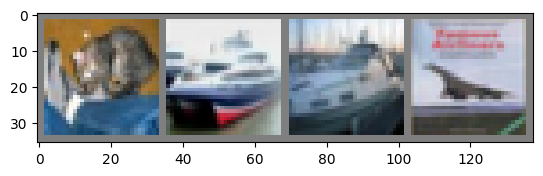

In [14]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % original_classes[labels[j]] for j in range(4)))

6


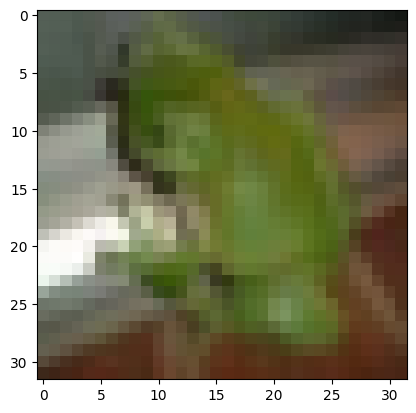

In [15]:
im, label = testset[7]
im = im / 2 + 0.5
# torch_tensor.detach().cpu().numpy()
im = im.detach().cpu().numpy()
im = rescale_image(im).astype(int)
im = np.transpose(im, (1, 2, 0))
print(label)
plt.imshow(im)

In [ ]:
# labels = list()

# for idx in range(2000,3000):
#   labels.append(testset[idx][1])

# np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([103,  89, 123,  96, 101, 105,  91,  93,  99, 100]))

## Embedding

In [16]:
def get_text_embeddings(text):
  inputs = Bert_tokenizer(text, return_tensors='pt')
  inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
  with torch.no_grad():
    outputs = Bert_model(**inputs)
  last_hidden_states = outputs.last_hidden_state
  return last_hidden_states[0][1]

def cosine_similarity(A, B):
  return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [17]:
known_classes_embed = list()

for c in known_classes:
  known_classes_embed.append(get_text_embeddings(c).cpu())
known_classes_embed = np.array(known_classes_embed)
known_classes_embed.shape

(5, 768)

In [18]:
t = "lizard"
t_embed = get_text_embeddings(t).cpu()

for embed, c in zip(known_classes_embed,known_classes):
  print(f"similarity to {c} is: {cosine_similarity(embed, t_embed)}")

similarity to plane is: 0.7635353803634644
similarity to car is: 0.5777745246887207
similarity to bird is: 0.8145835995674133
similarity to cat is: 0.7883412837982178
similarity to deer is: 0.6125531792640686


In [52]:
t1 = get_text_embeddings('bird').cpu()
t2 = get_text_embeddings('lizard').cpu()
cosine_similarity(t1,t2)

np.float32(0.8145836)

# Experiments

In [43]:
import streamlit as st
from PIL import Image

def get_a_category(prompt, image):
  language_model = create_Gen_Model()
  im = Image.fromarray(np.uint8(image)).convert('RGB')
  # input_text = st.text_input(prompt, key="input")
  # input_image = st.image(im, caption="Uploaded Image", use_column_width=True)
  category = language_model.generate_content([prompt, im]).text.strip('\n').strip('.').strip().lower()
  return category

## Benchmark

In [21]:
exp_type = "benchmark"

### One run

In [22]:
prompt_template = "what is the object in the image? answer with one word"

classes = list(known_classes)
novel_label_idx = 10

predicted_classes = list()
novel_classes_labels = dict()

for idx in tqdm(range(10)):
  im, label = testset[idx]
  prompt = prompt_template

  im = im / 2 + 0.5
  im = im.detach().cpu().numpy()
  im = rescale_image(im).astype(int)
  im = np.transpose(im, (1, 2, 0))

  pred_class = get_a_category(prompt, im)
  predicted_classes.append(pred_class)

  if not(pred_class in classes):
    classes.append(pred_class)
    novel_classes_labels[pred_class] = novel_label_idx
    novel_label_idx += 1

  0%|          | 0/10 [00:00<?, ?it/s]

cuda available!
Moving model to cuda


 10%|█         | 1/10 [00:01<00:09,  1.08s/it]

cuda available!
Moving model to cuda


 20%|██        | 2/10 [00:01<00:06,  1.20it/s]

cuda available!
Moving model to cuda


 30%|███       | 3/10 [00:02<00:05,  1.33it/s]

cuda available!
Moving model to cuda


 40%|████      | 4/10 [00:03<00:04,  1.35it/s]

cuda available!
Moving model to cuda


 50%|█████     | 5/10 [00:04<00:04,  1.11it/s]

cuda available!
Moving model to cuda


 60%|██████    | 6/10 [00:04<00:03,  1.22it/s]

cuda available!
Moving model to cuda


 70%|███████   | 7/10 [00:05<00:02,  1.36it/s]

cuda available!
Moving model to cuda


 80%|████████  | 8/10 [00:06<00:01,  1.45it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 9/10 [00:06<00:00,  1.53it/s]

cuda available!
Moving model to cuda


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


In [ ]:
np.unique(predicted_classes)

array(['aircraft', 'airplane', 'alligator', 'arrowhead', 'automobile',
       'bird', 'boat', 'car', 'cat', 'chair', 'chicken', 'convertible',
       'deer', 'dhow', 'dinosaur', 'dog', 'dolphin', 'donkey',
       'dumptruck', 'elk', 'emu', 'face', 'ferry', 'firetruck', 'frog',
       'horse', 'jeep', 'kitten', 'koala', 'moose', 'ostrich', 'puppy',
       'reindeer', 'sailboat', 'scorpion', 'ship', 'skull', 'statue',
       'toad', 'train', 'truck', 'tugboat', 'turkey', 'yacht'],
      dtype='<U11')

In [ ]:
novel_label_idx, classes

(50,
 ['plane',
  'car',
  'bird',
  'cat',
  'deer',
  'boat',
  'dinosaur',
  'frog',
  'kitten',
  'jeep',
  'aircraft',
  'truck',
  'dog',
  'horse',
  'alligator',
  'puppy',
  'dhow',
  'arrowhead',
  'dolphin',
  'firetruck',
  'turkey',
  'elk',
  'airplane',
  'emu',
  'automobile',
  'reindeer',
  'koala',
  'dumptruck',
  'tugboat',
  'ship',
  'sailboat',
  'face',
  'chicken',
  'chair',
  'statue',
  'donkey',
  'toad',
  'yacht',
  'train',
  'ferry',
  'convertible',
  'ostrich',
  'skull',
  'moose',
  'scorpion'])

In [ ]:
final_novel_classes_labels = dict()

for k, v in novel_classes_labels.items():
  final_novel_classes_labels[k] = v
  if k in unknown_classes:
    final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]

novel_classes_labels = final_novel_classes_labels.copy()

In [ ]:
novel_classes_labels

{'boat': 10,
 'dinosaur': 11,
 'frog': 6,
 'kitten': 13,
 'jeep': 14,
 'aircraft': 15,
 'truck': 9,
 'dog': 5,
 'horse': 7,
 'alligator': 19,
 'puppy': 20,
 'dhow': 21,
 'arrowhead': 22,
 'dolphin': 23,
 'firetruck': 24,
 'turkey': 25,
 'elk': 26,
 'airplane': 27,
 'emu': 28,
 'automobile': 29,
 'reindeer': 30,
 'koala': 31,
 'dumptruck': 32,
 'tugboat': 33,
 'ship': 8,
 'sailboat': 35,
 'face': 36,
 'chicken': 37,
 'chair': 38,
 'statue': 39,
 'donkey': 40,
 'toad': 41,
 'yacht': 42,
 'train': 43,
 'ferry': 44,
 'convertible': 45,
 'ostrich': 46,
 'skull': 47,
 'moose': 48,
 'scorpion': 49}

In [ ]:
# Known classes accuracy

pred_labels = list()

for pred_class in predicted_classes:
  if pred_class in known_classes:
    pred_labels.append(known_labels[known_classes.index(pred_class)])
  else:
    pred_labels.append(novel_classes_labels[pred_class])

In [ ]:
len(pred_labels)

100

In [ ]:
gt_labels = [testset[idx][1] for idx in tqdm(range(100))]
len(gt_labels)

100%|██████████| 100/100 [00:00<00:00, 1715.96it/s]


100

In [ ]:
pred_labels, gt_labels = np.array(pred_labels), np.array(gt_labels)

In [ ]:
overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
overall_acc

0.4799762737262737

In [ ]:
desiered_items = [l in known_labels for l in gt_labels]
known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
known_acc

0.32857142857142857

In [ ]:
desiered_items = [not(l in known_labels) for l in gt_labels]
unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
unknown_acc

0.6313811188811189

### loop

In [23]:
batches = (range(1000), range(1000, 2000), range(2000, 3000))

batches_results = list()

for batch in batches:

  batch_dict = dict()

  gt_labels = np.array([testset[idx][1] for idx in batch])

  prompt_template = "what is the object in the image? answer with one word"

  classes = list(known_classes)
  novel_label_idx = 10

  predicted_classes = list()
  novel_classes_labels = dict()

  for idx in tqdm(batch):
    im, label = testset[idx]
    prompt = prompt_template

    im = im / 2 + 0.5
    im = im.detach().cpu().numpy()
    im = rescale_image(im).astype(int)
    im = np.transpose(im, (1, 2, 0))

    pred_class = get_a_category(prompt, im)
    predicted_classes.append(pred_class)

    if not(pred_class in classes):
      classes.append(pred_class)
      novel_classes_labels[pred_class] = novel_label_idx
      novel_label_idx += 1

  # use correct unknown labels
  final_novel_classes_labels = dict()
  for k, v in novel_classes_labels.items():
    final_novel_classes_labels[k] = v
    if k in unknown_classes:
      final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]
  novel_classes_labels = final_novel_classes_labels.copy()

  # predicted labels list
  pred_labels = list()
  for pred_class in predicted_classes:
    if pred_class in known_classes:
      pred_labels.append(known_labels[known_classes.index(pred_class)])
    else:
      pred_labels.append(novel_classes_labels[pred_class])
  pred_labels = np.array(pred_labels)

  # Accuracy
  # overall
  overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
  # known
  desiered_items = [l in known_labels for l in gt_labels]
  known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
  # unknown
  desiered_items = [not(l in known_labels) for l in gt_labels]
  unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])

  batch_dict["gt_labels"] = gt_labels.copy()
  batch_dict["predicted_classes"] = predicted_classes.copy()
  batch_dict["novel_classes_labels"] = novel_classes_labels.copy()
  batch_dict["pred_labels"] = pred_labels.copy()
  batch_dict["accuracy"] = {"overall":overall_acc,
                            "known":known_acc,
                            "unknown":unknown_acc}

  batches_results.append(batch_dict.copy())

  0%|          | 0/1000 [00:00<?, ?it/s]

cuda available!
Moving model to cuda


  0%|          | 1/1000 [00:01<22:39,  1.36s/it]

cuda available!
Moving model to cuda


  0%|          | 2/1000 [00:01<12:52,  1.29it/s]

cuda available!
Moving model to cuda


  0%|          | 3/1000 [00:02<09:24,  1.77it/s]

cuda available!
Moving model to cuda


  0%|          | 4/1000 [00:02<07:34,  2.19it/s]

cuda available!
Moving model to cuda


  0%|          | 5/1000 [00:02<06:49,  2.43it/s]

cuda available!
Moving model to cuda


  1%|          | 6/1000 [00:02<06:01,  2.75it/s]

cuda available!
Moving model to cuda


  1%|          | 7/1000 [00:03<05:35,  2.96it/s]

cuda available!
Moving model to cuda


  1%|          | 8/1000 [00:03<05:28,  3.02it/s]

cuda available!
Moving model to cuda


  1%|          | 9/1000 [00:03<05:31,  2.99it/s]

cuda available!
Moving model to cuda


  1%|          | 10/1000 [00:04<05:19,  3.10it/s]

cuda available!
Moving model to cuda


  1%|          | 11/1000 [00:04<06:13,  2.65it/s]

cuda available!
Moving model to cuda


  1%|          | 12/1000 [00:05<06:36,  2.49it/s]

cuda available!
Moving model to cuda


  1%|▏         | 13/1000 [00:05<07:00,  2.35it/s]

cuda available!
Moving model to cuda


  1%|▏         | 14/1000 [00:06<07:46,  2.11it/s]

cuda available!
Moving model to cuda


  2%|▏         | 15/1000 [00:06<07:55,  2.07it/s]

cuda available!
Moving model to cuda


  2%|▏         | 16/1000 [00:07<07:54,  2.07it/s]

cuda available!
Moving model to cuda


  2%|▏         | 17/1000 [00:07<07:53,  2.07it/s]

cuda available!
Moving model to cuda


  2%|▏         | 18/1000 [00:08<08:13,  1.99it/s]

cuda available!
Moving model to cuda


  2%|▏         | 19/1000 [00:08<08:16,  1.98it/s]

cuda available!
Moving model to cuda


  2%|▏         | 20/1000 [00:09<08:05,  2.02it/s]

cuda available!
Moving model to cuda


  2%|▏         | 21/1000 [00:09<08:12,  1.99it/s]

cuda available!
Moving model to cuda


  2%|▏         | 22/1000 [00:10<08:11,  1.99it/s]

cuda available!
Moving model to cuda


  2%|▏         | 23/1000 [00:10<08:14,  1.97it/s]

cuda available!
Moving model to cuda


  2%|▏         | 24/1000 [00:11<08:43,  1.86it/s]

cuda available!
Moving model to cuda


  2%|▎         | 25/1000 [00:12<10:31,  1.54it/s]

cuda available!
Moving model to cuda


  3%|▎         | 26/1000 [00:12<10:08,  1.60it/s]

cuda available!
Moving model to cuda


  3%|▎         | 27/1000 [00:13<09:34,  1.69it/s]

cuda available!
Moving model to cuda


  3%|▎         | 28/1000 [00:13<09:28,  1.71it/s]

cuda available!
Moving model to cuda


  3%|▎         | 29/1000 [00:14<08:56,  1.81it/s]

cuda available!
Moving model to cuda


  3%|▎         | 30/1000 [00:14<09:08,  1.77it/s]

cuda available!
Moving model to cuda


  3%|▎         | 31/1000 [00:15<08:51,  1.82it/s]

cuda available!
Moving model to cuda


  3%|▎         | 32/1000 [00:16<09:07,  1.77it/s]

cuda available!
Moving model to cuda


  3%|▎         | 33/1000 [00:16<09:47,  1.65it/s]

cuda available!
Moving model to cuda


  3%|▎         | 34/1000 [00:17<10:21,  1.55it/s]

cuda available!
Moving model to cuda


  4%|▎         | 35/1000 [00:19<15:02,  1.07it/s]

cuda available!
Moving model to cuda


  4%|▎         | 36/1000 [00:20<16:17,  1.01s/it]

cuda available!
Moving model to cuda


  4%|▎         | 37/1000 [00:21<18:32,  1.16s/it]

cuda available!
Moving model to cuda


  4%|▍         | 38/1000 [00:23<20:09,  1.26s/it]

cuda available!
Moving model to cuda


  4%|▍         | 39/1000 [00:25<22:40,  1.42s/it]

cuda available!
Moving model to cuda


  4%|▍         | 40/1000 [00:25<18:32,  1.16s/it]

cuda available!
Moving model to cuda


  4%|▍         | 41/1000 [00:26<15:15,  1.05it/s]

cuda available!
Moving model to cuda


  4%|▍         | 42/1000 [00:26<13:25,  1.19it/s]

cuda available!
Moving model to cuda


  4%|▍         | 43/1000 [00:27<12:31,  1.27it/s]

cuda available!
Moving model to cuda


  4%|▍         | 44/1000 [00:27<11:08,  1.43it/s]

cuda available!
Moving model to cuda


  4%|▍         | 45/1000 [00:28<10:44,  1.48it/s]

cuda available!
Moving model to cuda


  5%|▍         | 46/1000 [00:30<15:40,  1.01it/s]

cuda available!
Moving model to cuda


  5%|▍         | 47/1000 [00:32<23:55,  1.51s/it]

cuda available!
Moving model to cuda


  5%|▍         | 48/1000 [00:35<29:14,  1.84s/it]

cuda available!
Moving model to cuda


  5%|▍         | 49/1000 [00:37<28:37,  1.81s/it]

cuda available!
Moving model to cuda


  5%|▌         | 50/1000 [00:38<24:20,  1.54s/it]

cuda available!
Moving model to cuda


  5%|▌         | 51/1000 [00:38<19:19,  1.22s/it]

cuda available!
Moving model to cuda


  5%|▌         | 52/1000 [00:39<15:43,  1.01it/s]

cuda available!
Moving model to cuda


  5%|▌         | 53/1000 [00:39<13:12,  1.20it/s]

cuda available!
Moving model to cuda


  5%|▌         | 54/1000 [00:40<11:35,  1.36it/s]

cuda available!
Moving model to cuda


  6%|▌         | 55/1000 [00:40<10:18,  1.53it/s]

cuda available!
Moving model to cuda


  6%|▌         | 56/1000 [00:41<09:29,  1.66it/s]

cuda available!
Moving model to cuda


  6%|▌         | 57/1000 [00:41<09:32,  1.65it/s]

cuda available!
Moving model to cuda


  6%|▌         | 58/1000 [00:42<08:50,  1.77it/s]

cuda available!
Moving model to cuda


  6%|▌         | 59/1000 [00:42<08:30,  1.84it/s]

cuda available!
Moving model to cuda


  6%|▌         | 60/1000 [00:43<08:11,  1.91it/s]

cuda available!
Moving model to cuda


  6%|▌         | 61/1000 [00:43<07:58,  1.96it/s]

cuda available!
Moving model to cuda


  6%|▌         | 62/1000 [00:44<07:46,  2.01it/s]

cuda available!
Moving model to cuda


  6%|▋         | 63/1000 [00:44<07:32,  2.07it/s]

cuda available!
Moving model to cuda


  6%|▋         | 64/1000 [00:44<07:33,  2.06it/s]

cuda available!
Moving model to cuda


  6%|▋         | 65/1000 [00:45<07:28,  2.09it/s]

cuda available!
Moving model to cuda


  7%|▋         | 66/1000 [00:45<07:30,  2.07it/s]

cuda available!
Moving model to cuda


  7%|▋         | 67/1000 [00:46<08:07,  1.91it/s]

cuda available!
Moving model to cuda


  7%|▋         | 68/1000 [00:47<08:14,  1.88it/s]

cuda available!
Moving model to cuda


  7%|▋         | 69/1000 [00:47<08:20,  1.86it/s]

cuda available!
Moving model to cuda


  7%|▋         | 70/1000 [00:48<08:01,  1.93it/s]

cuda available!
Moving model to cuda


  7%|▋         | 71/1000 [00:48<08:00,  1.93it/s]

cuda available!
Moving model to cuda


  7%|▋         | 72/1000 [00:49<08:35,  1.80it/s]

cuda available!
Moving model to cuda


  7%|▋         | 73/1000 [00:49<08:39,  1.79it/s]

cuda available!
Moving model to cuda


  7%|▋         | 74/1000 [00:50<08:22,  1.84it/s]

cuda available!
Moving model to cuda


  8%|▊         | 75/1000 [00:50<07:53,  1.95it/s]

cuda available!
Moving model to cuda


  8%|▊         | 76/1000 [00:51<07:44,  1.99it/s]

cuda available!
Moving model to cuda


  8%|▊         | 77/1000 [00:51<07:33,  2.04it/s]

cuda available!
Moving model to cuda


  8%|▊         | 78/1000 [00:52<07:24,  2.08it/s]

cuda available!
Moving model to cuda


  8%|▊         | 79/1000 [00:52<07:20,  2.09it/s]

cuda available!
Moving model to cuda


  8%|▊         | 80/1000 [00:53<07:25,  2.07it/s]

cuda available!
Moving model to cuda


  8%|▊         | 81/1000 [00:53<07:43,  1.98it/s]

cuda available!
Moving model to cuda


  8%|▊         | 82/1000 [00:54<07:47,  1.96it/s]

cuda available!
Moving model to cuda


  8%|▊         | 83/1000 [00:54<07:36,  2.01it/s]

cuda available!
Moving model to cuda


  8%|▊         | 84/1000 [00:55<07:49,  1.95it/s]

cuda available!
Moving model to cuda


  8%|▊         | 85/1000 [00:55<07:59,  1.91it/s]

cuda available!
Moving model to cuda


  9%|▊         | 86/1000 [00:56<07:50,  1.94it/s]

cuda available!
Moving model to cuda


  9%|▊         | 87/1000 [00:56<08:08,  1.87it/s]

cuda available!
Moving model to cuda


  9%|▉         | 88/1000 [00:57<07:54,  1.92it/s]

cuda available!
Moving model to cuda


  9%|▉         | 89/1000 [00:57<07:39,  1.98it/s]

cuda available!
Moving model to cuda


  9%|▉         | 90/1000 [00:58<07:31,  2.02it/s]

cuda available!
Moving model to cuda


  9%|▉         | 91/1000 [00:58<07:45,  1.95it/s]

cuda available!
Moving model to cuda


  9%|▉         | 92/1000 [00:59<07:31,  2.01it/s]

cuda available!
Moving model to cuda


  9%|▉         | 93/1000 [00:59<07:27,  2.03it/s]

cuda available!
Moving model to cuda


  9%|▉         | 94/1000 [01:00<08:29,  1.78it/s]

cuda available!
Moving model to cuda


 10%|▉         | 95/1000 [01:01<08:28,  1.78it/s]

cuda available!
Moving model to cuda


 10%|▉         | 96/1000 [01:01<08:13,  1.83it/s]

cuda available!
Moving model to cuda


 10%|▉         | 97/1000 [01:02<08:07,  1.85it/s]

cuda available!
Moving model to cuda


 10%|▉         | 98/1000 [01:02<07:51,  1.91it/s]

cuda available!
Moving model to cuda


 10%|▉         | 99/1000 [01:03<07:38,  1.97it/s]

cuda available!
Moving model to cuda


 10%|█         | 100/1000 [01:03<07:48,  1.92it/s]

cuda available!
Moving model to cuda


 10%|█         | 101/1000 [01:04<07:57,  1.88it/s]

cuda available!
Moving model to cuda


 10%|█         | 102/1000 [01:04<07:34,  1.98it/s]

cuda available!
Moving model to cuda


 10%|█         | 103/1000 [01:05<07:48,  1.92it/s]

cuda available!
Moving model to cuda


 10%|█         | 104/1000 [01:05<07:36,  1.96it/s]

cuda available!
Moving model to cuda


 10%|█         | 105/1000 [01:06<07:44,  1.93it/s]

cuda available!
Moving model to cuda


 11%|█         | 106/1000 [01:06<07:37,  1.95it/s]

cuda available!
Moving model to cuda


 11%|█         | 107/1000 [01:07<07:26,  2.00it/s]

cuda available!
Moving model to cuda


 11%|█         | 108/1000 [01:07<07:19,  2.03it/s]

cuda available!
Moving model to cuda


 11%|█         | 109/1000 [01:08<07:28,  1.99it/s]

cuda available!
Moving model to cuda


 11%|█         | 110/1000 [01:08<07:29,  1.98it/s]

cuda available!
Moving model to cuda


 11%|█         | 111/1000 [01:09<07:34,  1.96it/s]

cuda available!
Moving model to cuda


 11%|█         | 112/1000 [01:09<07:49,  1.89it/s]

cuda available!
Moving model to cuda


 11%|█▏        | 113/1000 [01:10<07:33,  1.96it/s]

cuda available!
Moving model to cuda


 11%|█▏        | 114/1000 [01:10<08:06,  1.82it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 115/1000 [01:11<07:50,  1.88it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 116/1000 [01:11<07:49,  1.88it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 117/1000 [01:12<07:40,  1.92it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 118/1000 [01:13<10:50,  1.36it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 119/1000 [01:14<09:59,  1.47it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 120/1000 [01:14<09:14,  1.59it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 121/1000 [01:15<09:00,  1.63it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 122/1000 [01:15<08:54,  1.64it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 123/1000 [01:20<26:23,  1.81s/it]

cuda available!
Moving model to cuda


 12%|█▏        | 124/1000 [01:21<23:51,  1.63s/it]

cuda available!
Moving model to cuda


 12%|█▎        | 125/1000 [01:22<20:36,  1.41s/it]

cuda available!
Moving model to cuda


 13%|█▎        | 126/1000 [01:23<17:17,  1.19s/it]

cuda available!
Moving model to cuda


 13%|█▎        | 127/1000 [01:23<14:07,  1.03it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 128/1000 [01:24<12:07,  1.20it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 129/1000 [01:25<11:50,  1.23it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 130/1000 [01:25<10:55,  1.33it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 131/1000 [01:26<09:51,  1.47it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 132/1000 [01:26<08:54,  1.62it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 133/1000 [01:27<08:15,  1.75it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 134/1000 [01:27<08:11,  1.76it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 135/1000 [01:28<07:52,  1.83it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 136/1000 [01:28<07:40,  1.87it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 137/1000 [01:29<07:23,  1.95it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 138/1000 [01:29<08:14,  1.74it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 139/1000 [01:31<11:13,  1.28it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 140/1000 [01:31<11:33,  1.24it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 141/1000 [01:32<12:19,  1.16it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 142/1000 [01:34<13:07,  1.09it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 143/1000 [01:34<13:26,  1.06it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 144/1000 [01:35<12:01,  1.19it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 145/1000 [01:36<10:26,  1.36it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 146/1000 [01:36<09:25,  1.51it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 147/1000 [01:37<08:42,  1.63it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 148/1000 [01:37<08:06,  1.75it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 149/1000 [01:38<07:40,  1.85it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 150/1000 [01:38<07:28,  1.89it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 151/1000 [01:39<07:24,  1.91it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 152/1000 [01:39<07:15,  1.95it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 153/1000 [01:40<07:14,  1.95it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 154/1000 [01:40<07:01,  2.01it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 155/1000 [01:40<06:58,  2.02it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 156/1000 [01:41<07:02,  2.00it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 157/1000 [01:42<07:02,  2.00it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 158/1000 [01:42<06:56,  2.02it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 159/1000 [01:43<07:26,  1.88it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 160/1000 [01:43<07:27,  1.88it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 161/1000 [01:44<07:21,  1.90it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 162/1000 [01:44<07:04,  1.98it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 163/1000 [01:45<08:35,  1.63it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 164/1000 [01:46<08:19,  1.67it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 165/1000 [01:46<07:48,  1.78it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 166/1000 [01:47<07:32,  1.84it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 167/1000 [01:47<07:10,  1.94it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 168/1000 [01:47<07:01,  1.98it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 169/1000 [01:48<06:55,  2.00it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 170/1000 [01:48<07:02,  1.96it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 171/1000 [01:49<08:48,  1.57it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 172/1000 [01:50<08:08,  1.69it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 173/1000 [01:50<07:59,  1.72it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 174/1000 [01:51<07:39,  1.80it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 175/1000 [01:51<07:36,  1.81it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 176/1000 [01:52<07:19,  1.88it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 177/1000 [01:52<07:08,  1.92it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 178/1000 [01:53<07:00,  1.95it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 179/1000 [01:53<07:02,  1.94it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 180/1000 [01:54<06:53,  1.98it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 181/1000 [01:54<06:42,  2.03it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 182/1000 [01:55<06:31,  2.09it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 183/1000 [01:55<06:32,  2.08it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 184/1000 [01:56<06:55,  1.96it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 185/1000 [01:56<06:56,  1.96it/s]

cuda available!
Moving model to cuda


 19%|█▊        | 186/1000 [01:57<06:49,  1.99it/s]

cuda available!
Moving model to cuda


 19%|█▊        | 187/1000 [01:57<06:43,  2.01it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 188/1000 [01:58<06:44,  2.01it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 189/1000 [01:58<06:33,  2.06it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 190/1000 [01:59<06:26,  2.10it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 191/1000 [01:59<06:22,  2.11it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 192/1000 [02:00<06:27,  2.09it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 193/1000 [02:00<06:26,  2.09it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 194/1000 [02:01<06:21,  2.11it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 195/1000 [02:01<06:16,  2.14it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 196/1000 [02:02<06:41,  2.00it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 197/1000 [02:02<07:05,  1.89it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 198/1000 [02:03<07:16,  1.84it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 199/1000 [02:03<07:12,  1.85it/s]

cuda available!
Moving model to cuda


 20%|██        | 200/1000 [02:04<06:51,  1.94it/s]

cuda available!
Moving model to cuda


 20%|██        | 201/1000 [02:04<06:53,  1.93it/s]

cuda available!
Moving model to cuda


 20%|██        | 202/1000 [02:05<06:51,  1.94it/s]

cuda available!
Moving model to cuda


 20%|██        | 203/1000 [02:06<07:25,  1.79it/s]

cuda available!
Moving model to cuda


 20%|██        | 204/1000 [02:06<07:07,  1.86it/s]

cuda available!
Moving model to cuda


 20%|██        | 205/1000 [02:07<08:16,  1.60it/s]

cuda available!
Moving model to cuda


 21%|██        | 206/1000 [02:07<07:44,  1.71it/s]

cuda available!
Moving model to cuda


 21%|██        | 207/1000 [02:08<07:44,  1.71it/s]

cuda available!
Moving model to cuda


 21%|██        | 208/1000 [02:08<07:14,  1.82it/s]

cuda available!
Moving model to cuda


 21%|██        | 209/1000 [02:09<07:00,  1.88it/s]

cuda available!
Moving model to cuda


 21%|██        | 210/1000 [02:10<07:04,  1.86it/s]

cuda available!
Moving model to cuda


 21%|██        | 211/1000 [02:10<07:07,  1.84it/s]

cuda available!
Moving model to cuda


 21%|██        | 212/1000 [02:11<06:56,  1.89it/s]

cuda available!
Moving model to cuda


 21%|██▏       | 213/1000 [02:11<07:25,  1.77it/s]

cuda available!
Moving model to cuda


 21%|██▏       | 214/1000 [02:12<07:13,  1.81it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 215/1000 [02:12<06:56,  1.89it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 216/1000 [02:13<08:08,  1.60it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 217/1000 [02:14<07:42,  1.69it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 218/1000 [02:14<07:36,  1.71it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 219/1000 [02:15<08:20,  1.56it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 220/1000 [02:16<10:40,  1.22it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 221/1000 [02:17<11:28,  1.13it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 222/1000 [02:18<11:05,  1.17it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 223/1000 [02:19<10:13,  1.27it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 224/1000 [02:19<09:04,  1.42it/s]

cuda available!
Moving model to cuda


 22%|██▎       | 225/1000 [02:20<08:30,  1.52it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 226/1000 [02:20<07:46,  1.66it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 227/1000 [02:21<08:00,  1.61it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 228/1000 [02:21<07:24,  1.74it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 229/1000 [02:22<06:56,  1.85it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 230/1000 [02:22<06:39,  1.93it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 231/1000 [02:23<07:33,  1.70it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 232/1000 [02:24<07:27,  1.71it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 233/1000 [02:24<07:06,  1.80it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 234/1000 [02:25<06:57,  1.84it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 235/1000 [02:25<06:54,  1.85it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 236/1000 [02:26<06:56,  1.84it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 237/1000 [02:26<06:49,  1.86it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 238/1000 [02:27<07:15,  1.75it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 239/1000 [02:27<07:21,  1.72it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 240/1000 [02:28<08:10,  1.55it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 241/1000 [02:29<09:10,  1.38it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 242/1000 [02:31<12:18,  1.03it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 243/1000 [02:31<11:32,  1.09it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 244/1000 [02:32<11:25,  1.10it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 245/1000 [02:35<16:24,  1.30s/it]

cuda available!
Moving model to cuda


 25%|██▍       | 246/1000 [02:36<17:13,  1.37s/it]

cuda available!
Moving model to cuda


 25%|██▍       | 247/1000 [02:37<13:58,  1.11s/it]

cuda available!
Moving model to cuda


 25%|██▍       | 248/1000 [02:37<11:31,  1.09it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 249/1000 [02:37<09:47,  1.28it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 250/1000 [02:38<08:38,  1.45it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 251/1000 [02:38<07:54,  1.58it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 252/1000 [02:39<07:16,  1.71it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 253/1000 [02:40<08:18,  1.50it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 254/1000 [02:41<09:00,  1.38it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 255/1000 [02:41<08:09,  1.52it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 256/1000 [02:42<10:14,  1.21it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 257/1000 [02:43<10:13,  1.21it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 258/1000 [02:44<09:08,  1.35it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 259/1000 [02:44<08:22,  1.48it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 260/1000 [02:45<07:52,  1.57it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 261/1000 [02:46<09:02,  1.36it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 262/1000 [02:46<08:42,  1.41it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 263/1000 [02:47<07:48,  1.57it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 264/1000 [02:48<07:42,  1.59it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 265/1000 [02:48<07:07,  1.72it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 266/1000 [02:48<06:49,  1.79it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 267/1000 [02:49<06:31,  1.87it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 268/1000 [02:49<06:17,  1.94it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 269/1000 [02:50<06:08,  1.98it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 270/1000 [02:50<06:05,  2.00it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 271/1000 [02:51<06:06,  1.99it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 272/1000 [02:51<06:07,  1.98it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 273/1000 [02:52<06:00,  2.01it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 274/1000 [02:52<06:09,  1.97it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 275/1000 [02:53<06:05,  1.98it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 276/1000 [02:53<06:15,  1.93it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 277/1000 [02:54<06:03,  1.99it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 278/1000 [02:54<05:55,  2.03it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 279/1000 [02:55<05:45,  2.08it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 280/1000 [02:55<05:56,  2.02it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 281/1000 [02:56<06:00,  1.99it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 282/1000 [02:56<05:57,  2.01it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 283/1000 [02:57<06:04,  1.96it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 284/1000 [02:57<06:03,  1.97it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 285/1000 [02:58<05:58,  2.00it/s]

cuda available!
Moving model to cuda


 29%|██▊       | 286/1000 [02:58<05:48,  2.05it/s]

cuda available!
Moving model to cuda


 29%|██▊       | 287/1000 [02:59<05:39,  2.10it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 288/1000 [02:59<05:43,  2.07it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 289/1000 [03:00<06:13,  1.91it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 290/1000 [03:00<06:08,  1.93it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 291/1000 [03:01<05:56,  1.99it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 292/1000 [03:01<05:42,  2.07it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 293/1000 [03:02<05:37,  2.09it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 294/1000 [03:02<05:37,  2.09it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 295/1000 [03:03<05:43,  2.05it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 296/1000 [03:03<05:44,  2.04it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 297/1000 [03:04<06:08,  1.91it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 298/1000 [03:04<06:06,  1.92it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 299/1000 [03:05<05:49,  2.00it/s]

cuda available!
Moving model to cuda


 30%|███       | 300/1000 [03:05<05:41,  2.05it/s]

cuda available!
Moving model to cuda


 30%|███       | 301/1000 [03:06<05:37,  2.07it/s]

cuda available!
Moving model to cuda


 30%|███       | 302/1000 [03:06<05:35,  2.08it/s]

cuda available!
Moving model to cuda


 30%|███       | 303/1000 [03:07<05:36,  2.07it/s]

cuda available!
Moving model to cuda


 30%|███       | 304/1000 [03:07<05:46,  2.01it/s]

cuda available!
Moving model to cuda


 30%|███       | 305/1000 [03:08<05:41,  2.04it/s]

cuda available!
Moving model to cuda


 31%|███       | 306/1000 [03:08<05:47,  2.00it/s]

cuda available!
Moving model to cuda


 31%|███       | 307/1000 [03:09<05:48,  1.99it/s]

cuda available!
Moving model to cuda


 31%|███       | 308/1000 [03:09<05:43,  2.02it/s]

cuda available!
Moving model to cuda


 31%|███       | 309/1000 [03:10<06:00,  1.92it/s]

cuda available!
Moving model to cuda


 31%|███       | 310/1000 [03:10<06:10,  1.86it/s]

cuda available!
Moving model to cuda


 31%|███       | 311/1000 [03:11<06:17,  1.83it/s]

cuda available!
Moving model to cuda


 31%|███       | 312/1000 [03:12<06:12,  1.85it/s]

cuda available!
Moving model to cuda


 31%|███▏      | 313/1000 [03:12<06:49,  1.68it/s]

cuda available!
Moving model to cuda


 31%|███▏      | 314/1000 [03:13<06:23,  1.79it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 315/1000 [03:13<06:27,  1.77it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 316/1000 [03:14<06:22,  1.79it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 317/1000 [03:14<06:28,  1.76it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 318/1000 [03:15<06:31,  1.74it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 319/1000 [03:16<07:17,  1.56it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 320/1000 [03:17<07:35,  1.49it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 321/1000 [03:17<07:59,  1.41it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 322/1000 [03:18<09:02,  1.25it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 323/1000 [03:20<12:11,  1.08s/it]

cuda available!
Moving model to cuda


 32%|███▏      | 324/1000 [03:21<13:09,  1.17s/it]

cuda available!
Moving model to cuda


 32%|███▎      | 325/1000 [03:22<12:18,  1.09s/it]

cuda available!
Moving model to cuda


 33%|███▎      | 326/1000 [03:23<10:55,  1.03it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 327/1000 [03:24<10:45,  1.04it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 328/1000 [03:25<09:23,  1.19it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 329/1000 [03:26<12:32,  1.12s/it]

cuda available!
Moving model to cuda


 33%|███▎      | 330/1000 [03:27<10:32,  1.06it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 331/1000 [03:27<09:00,  1.24it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 332/1000 [03:28<08:01,  1.39it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 333/1000 [03:29<07:37,  1.46it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 334/1000 [03:29<08:11,  1.36it/s]

cuda available!
Moving model to cuda


 34%|███▎      | 335/1000 [03:32<15:59,  1.44s/it]

cuda available!
Moving model to cuda


 34%|███▎      | 336/1000 [03:34<17:13,  1.56s/it]

cuda available!
Moving model to cuda


 34%|███▎      | 337/1000 [03:36<17:19,  1.57s/it]

cuda available!
Moving model to cuda


 34%|███▍      | 338/1000 [03:36<13:56,  1.26s/it]

cuda available!
Moving model to cuda


 34%|███▍      | 339/1000 [03:37<11:17,  1.02s/it]

cuda available!
Moving model to cuda


 34%|███▍      | 340/1000 [03:37<09:24,  1.17it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 341/1000 [03:38<08:48,  1.25it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 342/1000 [03:39<07:47,  1.41it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 343/1000 [03:39<07:04,  1.55it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 344/1000 [03:39<06:26,  1.70it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 345/1000 [03:40<06:08,  1.78it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 346/1000 [03:41<06:04,  1.79it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 347/1000 [03:41<05:46,  1.89it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 348/1000 [03:42<05:41,  1.91it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 349/1000 [03:42<05:42,  1.90it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 350/1000 [03:43<05:29,  1.97it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 351/1000 [03:43<05:17,  2.04it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 352/1000 [03:43<05:13,  2.07it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 353/1000 [03:44<05:08,  2.09it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 354/1000 [03:44<05:26,  1.98it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 355/1000 [03:45<05:17,  2.03it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 356/1000 [03:45<05:14,  2.05it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 357/1000 [03:46<05:19,  2.01it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 358/1000 [03:46<05:28,  1.95it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 359/1000 [03:47<05:31,  1.93it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 360/1000 [03:48<05:32,  1.93it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 361/1000 [03:48<05:24,  1.97it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 362/1000 [03:48<05:23,  1.97it/s]

cuda available!
Moving model to cuda


 36%|███▋      | 363/1000 [03:49<05:22,  1.98it/s]

cuda available!
Moving model to cuda


 36%|███▋      | 364/1000 [03:50<05:21,  1.98it/s]

cuda available!
Moving model to cuda


 36%|███▋      | 365/1000 [03:50<05:12,  2.03it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 366/1000 [03:50<05:05,  2.07it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 367/1000 [03:51<05:05,  2.07it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 368/1000 [03:51<05:16,  2.00it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 369/1000 [03:52<05:22,  1.96it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 370/1000 [03:52<05:19,  1.97it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 371/1000 [03:53<05:22,  1.95it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 372/1000 [03:54<05:17,  1.98it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 373/1000 [03:54<05:06,  2.04it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 374/1000 [03:55<05:18,  1.97it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 375/1000 [03:55<05:13,  1.99it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 376/1000 [03:56<05:16,  1.97it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 377/1000 [03:56<05:08,  2.02it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 378/1000 [03:57<05:18,  1.95it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 379/1000 [03:57<05:14,  1.97it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 380/1000 [03:58<05:12,  1.98it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 381/1000 [03:58<05:05,  2.02it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 382/1000 [03:58<05:01,  2.05it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 383/1000 [03:59<04:55,  2.09it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 384/1000 [03:59<05:02,  2.03it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 385/1000 [04:00<05:18,  1.93it/s]

cuda available!
Moving model to cuda


 39%|███▊      | 386/1000 [04:01<05:40,  1.80it/s]

cuda available!
Moving model to cuda


 39%|███▊      | 387/1000 [04:01<05:36,  1.82it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 388/1000 [04:02<05:28,  1.86it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 389/1000 [04:02<05:21,  1.90it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 390/1000 [04:03<05:10,  1.97it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 391/1000 [04:03<05:04,  2.00it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 392/1000 [04:04<04:54,  2.06it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 393/1000 [04:04<04:48,  2.10it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 394/1000 [04:05<04:45,  2.12it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 395/1000 [04:05<04:54,  2.05it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 396/1000 [04:06<04:59,  2.02it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 397/1000 [04:06<04:58,  2.02it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 398/1000 [04:07<05:26,  1.85it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 399/1000 [04:07<05:11,  1.93it/s]

cuda available!
Moving model to cuda


 40%|████      | 400/1000 [04:08<05:04,  1.97it/s]

cuda available!
Moving model to cuda


 40%|████      | 401/1000 [04:08<05:00,  1.99it/s]

cuda available!
Moving model to cuda


 40%|████      | 402/1000 [04:09<05:16,  1.89it/s]

cuda available!
Moving model to cuda


 40%|████      | 403/1000 [04:09<05:14,  1.90it/s]

cuda available!
Moving model to cuda


 40%|████      | 404/1000 [04:10<05:22,  1.85it/s]

cuda available!
Moving model to cuda


 40%|████      | 405/1000 [04:10<05:19,  1.86it/s]

cuda available!
Moving model to cuda


 41%|████      | 406/1000 [04:11<05:14,  1.89it/s]

cuda available!
Moving model to cuda


 41%|████      | 407/1000 [04:11<05:01,  1.97it/s]

cuda available!
Moving model to cuda


 41%|████      | 408/1000 [04:12<05:19,  1.85it/s]

cuda available!
Moving model to cuda


 41%|████      | 409/1000 [04:12<05:21,  1.84it/s]

cuda available!
Moving model to cuda


 41%|████      | 410/1000 [04:13<05:10,  1.90it/s]

cuda available!
Moving model to cuda


 41%|████      | 411/1000 [04:13<05:00,  1.96it/s]

cuda available!
Moving model to cuda


 41%|████      | 412/1000 [04:14<04:57,  1.97it/s]

cuda available!
Moving model to cuda


 41%|████▏     | 413/1000 [04:15<05:58,  1.64it/s]

cuda available!
Moving model to cuda


 41%|████▏     | 414/1000 [04:15<05:40,  1.72it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 415/1000 [04:16<06:17,  1.55it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 416/1000 [04:17<05:50,  1.67it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 417/1000 [04:18<08:51,  1.10it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 418/1000 [04:19<08:05,  1.20it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 419/1000 [04:20<07:35,  1.28it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 420/1000 [04:20<07:23,  1.31it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 421/1000 [04:21<06:37,  1.46it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 422/1000 [04:21<06:16,  1.53it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 423/1000 [04:23<08:04,  1.19it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 424/1000 [04:23<07:30,  1.28it/s]

cuda available!
Moving model to cuda


 42%|████▎     | 425/1000 [04:24<06:39,  1.44it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 426/1000 [04:24<05:59,  1.60it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 427/1000 [04:25<05:37,  1.70it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 428/1000 [04:25<05:23,  1.77it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 429/1000 [04:26<05:07,  1.86it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 430/1000 [04:26<04:52,  1.95it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 431/1000 [04:27<04:52,  1.95it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 432/1000 [04:27<05:09,  1.83it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 433/1000 [04:28<05:05,  1.86it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 434/1000 [04:28<05:00,  1.89it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 435/1000 [04:29<04:50,  1.94it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 436/1000 [04:29<04:57,  1.89it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 437/1000 [04:30<05:20,  1.76it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 438/1000 [04:31<06:06,  1.53it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 439/1000 [04:32<06:07,  1.53it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 440/1000 [04:32<05:39,  1.65it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 441/1000 [04:33<05:23,  1.73it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 442/1000 [04:33<05:08,  1.81it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 443/1000 [04:34<05:02,  1.84it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 444/1000 [04:34<05:17,  1.75it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 445/1000 [04:36<07:22,  1.25it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 446/1000 [04:36<06:35,  1.40it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 447/1000 [04:37<05:53,  1.56it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 448/1000 [04:37<05:24,  1.70it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 449/1000 [04:38<05:21,  1.71it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 450/1000 [04:38<04:59,  1.84it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 451/1000 [04:38<04:46,  1.92it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 452/1000 [04:39<04:37,  1.97it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 453/1000 [04:39<04:28,  2.03it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 454/1000 [04:40<04:23,  2.08it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 455/1000 [04:40<04:19,  2.10it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 456/1000 [04:41<04:17,  2.11it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 457/1000 [04:41<04:31,  2.00it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 458/1000 [04:42<04:27,  2.02it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 459/1000 [04:42<04:20,  2.08it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 460/1000 [04:43<04:21,  2.06it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 461/1000 [04:43<04:22,  2.05it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 462/1000 [04:44<04:25,  2.03it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 463/1000 [04:44<04:20,  2.06it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 464/1000 [04:45<04:22,  2.04it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 465/1000 [04:45<04:15,  2.10it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 466/1000 [04:46<04:24,  2.02it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 467/1000 [04:46<04:42,  1.89it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 468/1000 [04:47<04:35,  1.93it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 469/1000 [04:47<04:42,  1.88it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 470/1000 [04:48<04:36,  1.91it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 471/1000 [04:48<04:33,  1.93it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 472/1000 [04:49<04:33,  1.93it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 473/1000 [04:49<04:26,  1.98it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 474/1000 [04:50<04:22,  2.00it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 475/1000 [04:50<04:26,  1.97it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 476/1000 [04:51<04:30,  1.94it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 477/1000 [04:51<04:26,  1.96it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 478/1000 [04:52<04:20,  2.00it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 479/1000 [04:52<04:14,  2.05it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 480/1000 [04:53<04:18,  2.01it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 481/1000 [04:53<04:18,  2.01it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 482/1000 [04:54<04:10,  2.07it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 483/1000 [04:54<04:12,  2.05it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 484/1000 [04:55<04:09,  2.07it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 485/1000 [04:55<04:08,  2.07it/s]

cuda available!
Moving model to cuda


 49%|████▊     | 486/1000 [04:56<04:09,  2.06it/s]

cuda available!
Moving model to cuda


 49%|████▊     | 487/1000 [04:56<04:07,  2.08it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 488/1000 [04:57<04:23,  1.95it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 489/1000 [04:57<04:28,  1.90it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 490/1000 [04:58<04:38,  1.83it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 491/1000 [04:58<04:27,  1.90it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 492/1000 [04:59<04:25,  1.91it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 493/1000 [04:59<04:15,  1.99it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 494/1000 [05:00<04:13,  2.00it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 495/1000 [05:01<04:27,  1.89it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 496/1000 [05:01<04:23,  1.91it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 497/1000 [05:02<04:19,  1.94it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 498/1000 [05:02<04:12,  1.99it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 499/1000 [05:03<04:08,  2.02it/s]

cuda available!
Moving model to cuda


 50%|█████     | 500/1000 [05:03<04:07,  2.02it/s]

cuda available!
Moving model to cuda


 50%|█████     | 501/1000 [05:04<04:12,  1.98it/s]

cuda available!
Moving model to cuda


 50%|█████     | 502/1000 [05:04<04:05,  2.03it/s]

cuda available!
Moving model to cuda


 50%|█████     | 503/1000 [05:04<04:01,  2.06it/s]

cuda available!
Moving model to cuda


 50%|█████     | 504/1000 [05:05<04:23,  1.88it/s]

cuda available!
Moving model to cuda


 50%|█████     | 505/1000 [05:06<04:19,  1.91it/s]

cuda available!
Moving model to cuda


 51%|█████     | 506/1000 [05:06<04:15,  1.93it/s]

cuda available!
Moving model to cuda


 51%|█████     | 507/1000 [05:07<04:07,  1.99it/s]

cuda available!
Moving model to cuda


 51%|█████     | 508/1000 [05:07<04:06,  1.99it/s]

cuda available!
Moving model to cuda


 51%|█████     | 509/1000 [05:08<03:59,  2.05it/s]

cuda available!
Moving model to cuda


 51%|█████     | 510/1000 [05:08<03:58,  2.05it/s]

cuda available!
Moving model to cuda


 51%|█████     | 511/1000 [05:08<03:53,  2.10it/s]

cuda available!
Moving model to cuda


 51%|█████     | 512/1000 [05:09<03:51,  2.11it/s]

cuda available!
Moving model to cuda


 51%|█████▏    | 513/1000 [05:09<03:45,  2.16it/s]

cuda available!
Moving model to cuda


 51%|█████▏    | 514/1000 [05:10<03:45,  2.16it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 515/1000 [05:10<03:52,  2.09it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 516/1000 [05:11<03:53,  2.07it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 517/1000 [05:12<04:21,  1.85it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 518/1000 [05:12<04:12,  1.91it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 519/1000 [05:12<04:01,  1.99it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 520/1000 [05:13<04:02,  1.98it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 521/1000 [05:13<03:58,  2.01it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 522/1000 [05:14<04:01,  1.98it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 523/1000 [05:15<04:11,  1.90it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 524/1000 [05:15<04:05,  1.94it/s]

cuda available!
Moving model to cuda


 52%|█████▎    | 525/1000 [05:16<04:07,  1.92it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 526/1000 [05:16<04:03,  1.95it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 527/1000 [05:17<04:01,  1.96it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 528/1000 [05:17<03:58,  1.98it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 529/1000 [05:18<03:59,  1.97it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 530/1000 [05:18<03:57,  1.98it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 531/1000 [05:19<03:49,  2.04it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 532/1000 [05:19<03:53,  2.00it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 533/1000 [05:20<03:57,  1.97it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 534/1000 [05:20<03:59,  1.95it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 535/1000 [05:21<03:58,  1.95it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 536/1000 [05:21<03:58,  1.94it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 537/1000 [05:22<04:00,  1.92it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 538/1000 [05:22<04:11,  1.84it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 539/1000 [05:23<04:09,  1.85it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 540/1000 [05:24<04:28,  1.71it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 541/1000 [05:24<04:38,  1.65it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 542/1000 [05:25<04:40,  1.63it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 543/1000 [05:25<04:26,  1.72it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 544/1000 [05:26<04:46,  1.59it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 545/1000 [05:27<04:29,  1.69it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 546/1000 [05:27<04:17,  1.76it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 547/1000 [05:28<05:12,  1.45it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 548/1000 [05:29<04:52,  1.55it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 549/1000 [05:30<05:39,  1.33it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 550/1000 [05:30<05:03,  1.48it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 551/1000 [05:31<04:48,  1.56it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 552/1000 [05:31<04:38,  1.61it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 553/1000 [05:32<04:41,  1.59it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 554/1000 [05:32<04:21,  1.71it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 555/1000 [05:33<04:15,  1.74it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 556/1000 [05:33<04:01,  1.84it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 557/1000 [05:34<04:09,  1.78it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 558/1000 [05:35<04:04,  1.81it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 559/1000 [05:35<04:02,  1.82it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 560/1000 [05:36<05:53,  1.24it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 561/1000 [05:37<05:16,  1.39it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 562/1000 [05:38<04:52,  1.50it/s]

cuda available!
Moving model to cuda


 56%|█████▋    | 563/1000 [05:38<04:49,  1.51it/s]

cuda available!
Moving model to cuda


 56%|█████▋    | 564/1000 [05:39<04:38,  1.57it/s]

cuda available!
Moving model to cuda


 56%|█████▋    | 565/1000 [05:39<04:50,  1.50it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 566/1000 [05:40<04:42,  1.54it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 567/1000 [05:41<04:15,  1.69it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 568/1000 [05:41<04:00,  1.79it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 569/1000 [05:42<03:49,  1.88it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 570/1000 [05:42<03:45,  1.91it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 571/1000 [05:42<03:38,  1.96it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 572/1000 [05:43<03:35,  1.98it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 573/1000 [05:43<03:28,  2.04it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 574/1000 [05:44<03:27,  2.06it/s]

cuda available!
Moving model to cuda


 57%|█████▊    | 575/1000 [05:44<03:28,  2.04it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 576/1000 [05:45<03:28,  2.03it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 577/1000 [05:45<03:25,  2.06it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 578/1000 [05:46<03:18,  2.13it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 579/1000 [05:46<03:30,  2.00it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 580/1000 [05:47<03:28,  2.01it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 581/1000 [05:47<03:24,  2.05it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 582/1000 [05:48<03:33,  1.96it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 583/1000 [05:48<03:40,  1.89it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 584/1000 [05:49<03:38,  1.91it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 585/1000 [05:50<03:38,  1.90it/s]

cuda available!
Moving model to cuda


 59%|█████▊    | 586/1000 [05:50<03:29,  1.98it/s]

cuda available!
Moving model to cuda


 59%|█████▊    | 587/1000 [05:50<03:24,  2.02it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 588/1000 [05:51<03:33,  1.93it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 589/1000 [05:52<03:41,  1.85it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 590/1000 [05:52<03:37,  1.88it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 591/1000 [05:53<03:35,  1.90it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 592/1000 [05:53<03:38,  1.87it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 593/1000 [05:54<03:28,  1.95it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 594/1000 [05:54<03:24,  1.98it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 595/1000 [05:55<03:26,  1.96it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 596/1000 [05:55<03:34,  1.88it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 597/1000 [05:56<03:23,  1.98it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 598/1000 [05:56<03:28,  1.93it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 599/1000 [05:57<03:27,  1.93it/s]

cuda available!
Moving model to cuda


 60%|██████    | 600/1000 [05:57<03:21,  1.98it/s]

cuda available!
Moving model to cuda


 60%|██████    | 601/1000 [05:58<03:22,  1.97it/s]

cuda available!
Moving model to cuda


 60%|██████    | 602/1000 [05:58<03:33,  1.87it/s]

cuda available!
Moving model to cuda


 60%|██████    | 603/1000 [05:59<03:23,  1.95it/s]

cuda available!
Moving model to cuda


 60%|██████    | 604/1000 [05:59<03:17,  2.00it/s]

cuda available!
Moving model to cuda


 60%|██████    | 605/1000 [06:00<03:13,  2.05it/s]

cuda available!
Moving model to cuda


 61%|██████    | 606/1000 [06:00<03:15,  2.02it/s]

cuda available!
Moving model to cuda


 61%|██████    | 607/1000 [06:01<03:07,  2.09it/s]

cuda available!
Moving model to cuda


 61%|██████    | 608/1000 [06:01<03:11,  2.05it/s]

cuda available!
Moving model to cuda


 61%|██████    | 609/1000 [06:02<03:08,  2.07it/s]

cuda available!
Moving model to cuda


 61%|██████    | 610/1000 [06:02<03:35,  1.81it/s]

cuda available!
Moving model to cuda


 61%|██████    | 611/1000 [06:03<03:27,  1.88it/s]

cuda available!
Moving model to cuda


 61%|██████    | 612/1000 [06:03<03:25,  1.89it/s]

cuda available!
Moving model to cuda


 61%|██████▏   | 613/1000 [06:04<03:16,  1.96it/s]

cuda available!
Moving model to cuda


 61%|██████▏   | 614/1000 [06:04<03:16,  1.96it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 615/1000 [06:05<03:15,  1.97it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 616/1000 [06:05<03:16,  1.95it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 617/1000 [06:06<03:13,  1.97it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 618/1000 [06:06<03:08,  2.03it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 619/1000 [06:07<03:04,  2.07it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 620/1000 [06:07<03:05,  2.05it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 621/1000 [06:08<03:03,  2.06it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 622/1000 [06:08<03:04,  2.05it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 623/1000 [06:09<03:11,  1.97it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 624/1000 [06:09<03:09,  1.98it/s]

cuda available!
Moving model to cuda


 62%|██████▎   | 625/1000 [06:10<03:03,  2.04it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 626/1000 [06:10<03:00,  2.08it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 627/1000 [06:11<02:58,  2.09it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 628/1000 [06:11<03:14,  1.91it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 629/1000 [06:12<03:21,  1.85it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 630/1000 [06:12<03:15,  1.89it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 631/1000 [06:13<03:15,  1.89it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 632/1000 [06:13<03:16,  1.87it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 633/1000 [06:14<03:07,  1.95it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 634/1000 [06:14<03:03,  1.99it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 635/1000 [06:15<03:08,  1.94it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 636/1000 [06:16<03:09,  1.92it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 637/1000 [06:16<03:04,  1.96it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 638/1000 [06:17<03:09,  1.91it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 639/1000 [06:17<03:04,  1.95it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 640/1000 [06:18<03:00,  2.00it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 641/1000 [06:18<03:05,  1.93it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 642/1000 [06:19<03:21,  1.78it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 643/1000 [06:19<03:21,  1.77it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 644/1000 [06:20<03:07,  1.90it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 645/1000 [06:20<03:05,  1.92it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 646/1000 [06:21<03:03,  1.93it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 647/1000 [06:21<03:02,  1.94it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 648/1000 [06:22<02:53,  2.02it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 649/1000 [06:22<03:00,  1.95it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 650/1000 [06:23<03:09,  1.85it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 651/1000 [06:23<02:59,  1.94it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 652/1000 [06:24<02:55,  1.99it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 653/1000 [06:24<02:57,  1.95it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 654/1000 [06:25<02:51,  2.01it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 655/1000 [06:25<02:50,  2.02it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 656/1000 [06:26<02:50,  2.01it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 657/1000 [06:26<02:58,  1.92it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 658/1000 [06:27<03:05,  1.84it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 659/1000 [06:28<03:36,  1.57it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 660/1000 [06:30<06:52,  1.21s/it]

cuda available!
Moving model to cuda


 66%|██████▌   | 661/1000 [06:33<09:14,  1.64s/it]

cuda available!
Moving model to cuda


 66%|██████▌   | 662/1000 [06:36<11:23,  2.02s/it]

cuda available!
Moving model to cuda


 66%|██████▋   | 663/1000 [06:37<10:21,  1.84s/it]

cuda available!
Moving model to cuda


 66%|██████▋   | 664/1000 [06:38<08:06,  1.45s/it]

cuda available!
Moving model to cuda


 66%|██████▋   | 665/1000 [06:38<06:27,  1.16s/it]

cuda available!
Moving model to cuda


 67%|██████▋   | 666/1000 [06:39<05:17,  1.05it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 667/1000 [06:39<04:28,  1.24it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 668/1000 [06:40<04:01,  1.38it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 669/1000 [06:40<03:33,  1.55it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 670/1000 [06:41<03:16,  1.68it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 671/1000 [06:41<03:11,  1.72it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 672/1000 [06:42<03:08,  1.74it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 673/1000 [06:42<03:07,  1.74it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 674/1000 [06:43<02:57,  1.83it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 675/1000 [06:43<02:49,  1.92it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 676/1000 [06:44<02:48,  1.92it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 677/1000 [06:44<02:45,  1.95it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 678/1000 [06:45<02:43,  1.97it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 679/1000 [06:45<02:41,  1.99it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 680/1000 [06:46<02:35,  2.06it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 681/1000 [06:46<02:36,  2.04it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 682/1000 [06:47<02:35,  2.05it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 683/1000 [06:47<02:36,  2.02it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 684/1000 [06:48<02:37,  2.01it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 685/1000 [06:48<02:46,  1.89it/s]

cuda available!
Moving model to cuda


 69%|██████▊   | 686/1000 [06:49<02:41,  1.94it/s]

cuda available!
Moving model to cuda


 69%|██████▊   | 687/1000 [06:49<02:37,  1.99it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 688/1000 [06:50<02:38,  1.97it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 689/1000 [06:50<02:32,  2.03it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 690/1000 [06:51<02:35,  1.99it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 691/1000 [06:51<02:35,  1.99it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 692/1000 [06:52<02:52,  1.79it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 693/1000 [06:53<02:42,  1.89it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 694/1000 [06:53<02:38,  1.94it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 695/1000 [06:53<02:32,  2.00it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 696/1000 [06:54<02:33,  1.98it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 697/1000 [06:54<02:29,  2.03it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 698/1000 [06:55<02:43,  1.85it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 699/1000 [06:56<02:41,  1.87it/s]

cuda available!
Moving model to cuda


 70%|███████   | 700/1000 [06:56<02:35,  1.92it/s]

cuda available!
Moving model to cuda


 70%|███████   | 701/1000 [06:57<02:32,  1.96it/s]

cuda available!
Moving model to cuda


 70%|███████   | 702/1000 [06:57<02:30,  1.99it/s]

cuda available!
Moving model to cuda


 70%|███████   | 703/1000 [06:58<02:31,  1.96it/s]

cuda available!
Moving model to cuda


 70%|███████   | 704/1000 [06:58<02:37,  1.88it/s]

cuda available!
Moving model to cuda


 70%|███████   | 705/1000 [06:59<02:48,  1.75it/s]

cuda available!
Moving model to cuda


 71%|███████   | 706/1000 [06:59<02:43,  1.80it/s]

cuda available!
Moving model to cuda


 71%|███████   | 707/1000 [07:00<02:35,  1.88it/s]

cuda available!
Moving model to cuda


 71%|███████   | 708/1000 [07:00<02:32,  1.91it/s]

cuda available!
Moving model to cuda


 71%|███████   | 709/1000 [07:01<02:30,  1.94it/s]

cuda available!
Moving model to cuda


 71%|███████   | 710/1000 [07:01<02:28,  1.95it/s]

cuda available!
Moving model to cuda


 71%|███████   | 711/1000 [07:02<02:22,  2.03it/s]

cuda available!
Moving model to cuda


 71%|███████   | 712/1000 [07:02<02:20,  2.04it/s]

cuda available!
Moving model to cuda


 71%|███████▏  | 713/1000 [07:03<02:22,  2.01it/s]

cuda available!
Moving model to cuda


 71%|███████▏  | 714/1000 [07:03<02:19,  2.05it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 715/1000 [07:04<02:18,  2.06it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 716/1000 [07:04<02:19,  2.04it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 717/1000 [07:05<02:17,  2.06it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 718/1000 [07:05<02:15,  2.09it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 719/1000 [07:06<02:12,  2.12it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 720/1000 [07:06<02:11,  2.13it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 721/1000 [07:07<02:15,  2.06it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 722/1000 [07:07<02:24,  1.93it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 723/1000 [07:08<02:22,  1.95it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 724/1000 [07:08<02:21,  1.95it/s]

cuda available!
Moving model to cuda


 72%|███████▎  | 725/1000 [07:09<02:19,  1.97it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 726/1000 [07:09<02:31,  1.81it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 727/1000 [07:10<02:31,  1.80it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 728/1000 [07:11<02:28,  1.83it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 729/1000 [07:12<03:25,  1.32it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 730/1000 [07:12<03:02,  1.48it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 731/1000 [07:13<02:49,  1.59it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 732/1000 [07:13<02:39,  1.68it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 733/1000 [07:14<02:32,  1.75it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 734/1000 [07:14<02:28,  1.79it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 735/1000 [07:15<02:23,  1.85it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 736/1000 [07:15<02:23,  1.84it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 737/1000 [07:16<02:20,  1.87it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 738/1000 [07:16<02:17,  1.90it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 739/1000 [07:17<02:11,  1.98it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 740/1000 [07:17<02:14,  1.93it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 741/1000 [07:18<02:12,  1.96it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 742/1000 [07:18<02:09,  1.99it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 743/1000 [07:19<02:09,  1.98it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 744/1000 [07:19<02:12,  1.93it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 745/1000 [07:20<02:09,  1.97it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 746/1000 [07:20<02:10,  1.95it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 747/1000 [07:21<02:12,  1.90it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 748/1000 [07:22<02:12,  1.91it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 749/1000 [07:22<02:08,  1.95it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 750/1000 [07:23<02:19,  1.79it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 751/1000 [07:23<02:21,  1.75it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 752/1000 [07:24<02:17,  1.81it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 753/1000 [07:24<02:14,  1.84it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 754/1000 [07:25<02:15,  1.82it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 755/1000 [07:25<02:12,  1.85it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 756/1000 [07:26<02:13,  1.83it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 757/1000 [07:26<02:13,  1.82it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 758/1000 [07:27<02:13,  1.82it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 759/1000 [07:28<02:11,  1.83it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 760/1000 [07:29<02:41,  1.49it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 761/1000 [07:30<03:04,  1.29it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 762/1000 [07:35<08:18,  2.09s/it]

cuda available!
Moving model to cuda


 76%|███████▋  | 763/1000 [07:37<08:50,  2.24s/it]

cuda available!
Moving model to cuda


 76%|███████▋  | 764/1000 [07:39<07:41,  1.96s/it]

cuda available!
Moving model to cuda


 76%|███████▋  | 765/1000 [07:39<05:57,  1.52s/it]

cuda available!
Moving model to cuda


 77%|███████▋  | 766/1000 [07:40<04:44,  1.21s/it]

cuda available!
Moving model to cuda


 77%|███████▋  | 767/1000 [07:40<03:52,  1.00it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 768/1000 [07:41<03:15,  1.19it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 769/1000 [07:41<02:47,  1.38it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 770/1000 [07:42<02:29,  1.54it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 771/1000 [07:42<02:17,  1.66it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 772/1000 [07:42<02:07,  1.78it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 773/1000 [07:43<02:00,  1.89it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 774/1000 [07:43<01:55,  1.95it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 775/1000 [07:44<01:54,  1.97it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 776/1000 [07:44<01:57,  1.90it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 777/1000 [07:45<01:56,  1.91it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 778/1000 [07:45<01:55,  1.92it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 779/1000 [07:46<01:54,  1.93it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 780/1000 [07:46<01:52,  1.95it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 781/1000 [07:47<01:51,  1.96it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 782/1000 [07:47<01:47,  2.03it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 783/1000 [07:48<01:49,  1.99it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 784/1000 [07:49<01:49,  1.97it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 785/1000 [07:49<01:46,  2.03it/s]

cuda available!
Moving model to cuda


 79%|███████▊  | 786/1000 [07:49<01:45,  2.03it/s]

cuda available!
Moving model to cuda


 79%|███████▊  | 787/1000 [07:50<01:44,  2.04it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 788/1000 [07:50<01:44,  2.04it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 789/1000 [07:51<01:42,  2.06it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 790/1000 [07:51<01:44,  2.01it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 791/1000 [07:52<01:45,  1.99it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 792/1000 [07:52<01:44,  1.98it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 793/1000 [07:53<01:50,  1.87it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 794/1000 [07:54<01:47,  1.91it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 795/1000 [07:54<01:45,  1.94it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 796/1000 [07:55<01:44,  1.95it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 797/1000 [07:55<01:42,  1.97it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 798/1000 [07:56<01:40,  2.00it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 799/1000 [07:56<01:41,  1.98it/s]

cuda available!
Moving model to cuda


 80%|████████  | 800/1000 [07:57<01:39,  2.02it/s]

cuda available!
Moving model to cuda


 80%|████████  | 801/1000 [07:57<01:39,  2.00it/s]

cuda available!
Moving model to cuda


 80%|████████  | 802/1000 [07:58<01:40,  1.97it/s]

cuda available!
Moving model to cuda


 80%|████████  | 803/1000 [07:58<01:42,  1.92it/s]

cuda available!
Moving model to cuda


 80%|████████  | 804/1000 [07:59<01:40,  1.96it/s]

cuda available!
Moving model to cuda


 80%|████████  | 805/1000 [07:59<01:38,  1.99it/s]

cuda available!
Moving model to cuda


 81%|████████  | 806/1000 [08:00<01:35,  2.04it/s]

cuda available!
Moving model to cuda


 81%|████████  | 807/1000 [08:00<01:33,  2.06it/s]

cuda available!
Moving model to cuda


 81%|████████  | 808/1000 [08:00<01:32,  2.08it/s]

cuda available!
Moving model to cuda


 81%|████████  | 809/1000 [08:01<01:30,  2.11it/s]

cuda available!
Moving model to cuda


 81%|████████  | 810/1000 [08:01<01:30,  2.10it/s]

cuda available!
Moving model to cuda


 81%|████████  | 811/1000 [08:02<01:29,  2.10it/s]

cuda available!
Moving model to cuda


 81%|████████  | 812/1000 [08:02<01:30,  2.08it/s]

cuda available!
Moving model to cuda


 81%|████████▏ | 813/1000 [08:03<01:29,  2.10it/s]

cuda available!
Moving model to cuda


 81%|████████▏ | 814/1000 [08:03<01:29,  2.07it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 815/1000 [08:04<01:28,  2.10it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 816/1000 [08:04<01:28,  2.08it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 817/1000 [08:05<01:31,  2.00it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 818/1000 [08:05<01:31,  1.98it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 819/1000 [08:06<01:30,  2.01it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 820/1000 [08:06<01:29,  2.02it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 821/1000 [08:07<01:25,  2.08it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 822/1000 [08:07<01:28,  2.02it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 823/1000 [08:08<01:27,  2.01it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 824/1000 [08:08<01:27,  2.01it/s]

cuda available!
Moving model to cuda


 82%|████████▎ | 825/1000 [08:09<01:33,  1.86it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 826/1000 [08:09<01:29,  1.94it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 827/1000 [08:10<01:26,  2.00it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 828/1000 [08:10<01:25,  2.02it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 829/1000 [08:11<01:24,  2.03it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 830/1000 [08:11<01:23,  2.03it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 831/1000 [08:12<01:24,  2.00it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 832/1000 [08:12<01:29,  1.87it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 833/1000 [08:13<01:25,  1.96it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 834/1000 [08:13<01:24,  1.96it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 835/1000 [08:14<01:25,  1.92it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 836/1000 [08:15<01:28,  1.86it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 837/1000 [08:15<01:28,  1.85it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 838/1000 [08:16<01:35,  1.69it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 839/1000 [08:17<02:08,  1.26it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 840/1000 [08:18<02:30,  1.06it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 841/1000 [08:19<02:21,  1.12it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 842/1000 [08:20<02:06,  1.25it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 843/1000 [08:20<01:51,  1.41it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 844/1000 [08:21<01:45,  1.47it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 845/1000 [08:21<01:36,  1.60it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 846/1000 [08:22<01:31,  1.69it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 847/1000 [08:22<01:24,  1.82it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 848/1000 [08:23<01:21,  1.86it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 849/1000 [08:23<01:18,  1.93it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 850/1000 [08:24<01:20,  1.86it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 851/1000 [08:24<01:18,  1.91it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 852/1000 [08:25<01:17,  1.90it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 853/1000 [08:25<01:20,  1.82it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 854/1000 [08:26<01:20,  1.81it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 855/1000 [08:27<01:19,  1.83it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 856/1000 [08:28<01:55,  1.24it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 857/1000 [08:29<01:50,  1.29it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 858/1000 [08:30<02:00,  1.18it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 859/1000 [08:30<01:51,  1.26it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 860/1000 [08:31<01:41,  1.38it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 861/1000 [08:32<01:39,  1.40it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 862/1000 [08:33<01:49,  1.26it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 863/1000 [08:33<01:51,  1.22it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 864/1000 [08:34<01:38,  1.39it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 865/1000 [08:34<01:27,  1.54it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 866/1000 [08:35<01:23,  1.60it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 867/1000 [08:36<01:17,  1.73it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 868/1000 [08:36<01:12,  1.82it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 869/1000 [08:37<01:14,  1.76it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 870/1000 [08:37<01:12,  1.80it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 871/1000 [08:38<01:09,  1.86it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 872/1000 [08:38<01:07,  1.91it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 873/1000 [08:39<01:15,  1.67it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 874/1000 [08:39<01:12,  1.75it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 875/1000 [08:40<01:08,  1.83it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 876/1000 [08:40<01:06,  1.88it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 877/1000 [08:41<01:04,  1.91it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 878/1000 [08:41<01:05,  1.87it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 879/1000 [08:42<01:03,  1.91it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 880/1000 [08:43<01:04,  1.85it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 881/1000 [08:43<01:03,  1.88it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 882/1000 [08:44<01:00,  1.95it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 883/1000 [08:44<00:58,  2.00it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 884/1000 [08:45<01:00,  1.93it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 885/1000 [08:45<00:58,  1.95it/s]

cuda available!
Moving model to cuda


 89%|████████▊ | 886/1000 [08:46<01:00,  1.88it/s]

cuda available!
Moving model to cuda


 89%|████████▊ | 887/1000 [08:46<00:59,  1.91it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 888/1000 [08:47<00:56,  1.97it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 889/1000 [08:47<00:57,  1.92it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 890/1000 [08:48<00:56,  1.94it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 891/1000 [08:48<00:54,  2.00it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 892/1000 [08:49<00:52,  2.04it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 893/1000 [08:49<00:52,  2.04it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 894/1000 [08:50<00:51,  2.06it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 895/1000 [08:50<00:50,  2.07it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 896/1000 [08:51<00:52,  2.00it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 897/1000 [08:51<00:54,  1.90it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 898/1000 [08:52<00:55,  1.85it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 899/1000 [08:52<00:53,  1.88it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 900/1000 [08:53<00:52,  1.92it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 901/1000 [08:53<00:50,  1.96it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 902/1000 [08:54<00:48,  2.01it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 903/1000 [08:54<00:52,  1.85it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 904/1000 [08:55<00:49,  1.93it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 905/1000 [08:55<00:47,  1.99it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 906/1000 [08:56<00:46,  2.01it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 907/1000 [08:56<00:46,  2.00it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 908/1000 [08:57<00:46,  1.96it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 909/1000 [08:57<00:45,  1.98it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 910/1000 [08:58<00:44,  2.03it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 911/1000 [08:58<00:45,  1.94it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 912/1000 [08:59<00:47,  1.87it/s]

cuda available!
Moving model to cuda


 91%|█████████▏| 913/1000 [08:59<00:45,  1.93it/s]

cuda available!
Moving model to cuda


 91%|█████████▏| 914/1000 [09:00<00:44,  1.94it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 915/1000 [09:00<00:43,  1.95it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 916/1000 [09:01<00:43,  1.93it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 917/1000 [09:01<00:42,  1.97it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 918/1000 [09:02<00:41,  1.98it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 919/1000 [09:02<00:40,  2.00it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 920/1000 [09:03<00:39,  2.04it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 921/1000 [09:03<00:40,  1.95it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 922/1000 [09:04<00:39,  1.98it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 923/1000 [09:04<00:39,  1.97it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 924/1000 [09:05<00:38,  1.97it/s]

cuda available!
Moving model to cuda


 92%|█████████▎| 925/1000 [09:05<00:38,  1.93it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 926/1000 [09:06<00:37,  1.95it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 927/1000 [09:07<00:39,  1.84it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 928/1000 [09:07<00:39,  1.81it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 929/1000 [09:08<00:37,  1.92it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 930/1000 [09:08<00:35,  1.96it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 931/1000 [09:09<00:35,  1.96it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 932/1000 [09:09<00:35,  1.94it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 933/1000 [09:10<00:35,  1.90it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 934/1000 [09:10<00:33,  1.96it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 935/1000 [09:11<00:36,  1.78it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 936/1000 [09:11<00:35,  1.82it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 937/1000 [09:12<00:33,  1.88it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 938/1000 [09:12<00:32,  1.91it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 939/1000 [09:13<00:32,  1.87it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 940/1000 [09:13<00:31,  1.88it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 941/1000 [09:14<00:35,  1.65it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 942/1000 [09:15<00:46,  1.25it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 943/1000 [09:16<00:48,  1.17it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 944/1000 [09:18<00:57,  1.03s/it]

cuda available!
Moving model to cuda


 94%|█████████▍| 945/1000 [09:19<01:05,  1.20s/it]

cuda available!
Moving model to cuda


 95%|█████████▍| 946/1000 [09:21<01:13,  1.36s/it]

cuda available!
Moving model to cuda


 95%|█████████▍| 947/1000 [09:22<00:59,  1.12s/it]

cuda available!
Moving model to cuda


 95%|█████████▍| 948/1000 [09:23<00:56,  1.08s/it]

cuda available!
Moving model to cuda


 95%|█████████▍| 949/1000 [09:23<00:45,  1.11it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 950/1000 [09:24<00:42,  1.19it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 951/1000 [09:24<00:35,  1.37it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 952/1000 [09:25<00:32,  1.49it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 953/1000 [09:26<00:30,  1.56it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 954/1000 [09:26<00:26,  1.71it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 955/1000 [09:27<00:26,  1.68it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 956/1000 [09:27<00:26,  1.69it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 957/1000 [09:28<00:24,  1.74it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 958/1000 [09:28<00:23,  1.75it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 959/1000 [09:29<00:22,  1.79it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 960/1000 [09:29<00:22,  1.77it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 961/1000 [09:30<00:24,  1.59it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 962/1000 [09:31<00:22,  1.67it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 963/1000 [09:31<00:23,  1.58it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 964/1000 [09:32<00:21,  1.64it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 965/1000 [09:33<00:21,  1.65it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 966/1000 [09:33<00:19,  1.76it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 967/1000 [09:34<00:17,  1.84it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 968/1000 [09:34<00:17,  1.83it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 969/1000 [09:35<00:17,  1.78it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 970/1000 [09:35<00:16,  1.79it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 971/1000 [09:36<00:15,  1.89it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 972/1000 [09:36<00:14,  1.90it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 973/1000 [09:37<00:14,  1.86it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 974/1000 [09:37<00:13,  1.89it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 975/1000 [09:38<00:13,  1.86it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 976/1000 [09:38<00:12,  1.86it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 977/1000 [09:39<00:12,  1.89it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 978/1000 [09:39<00:11,  1.91it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 979/1000 [09:40<00:10,  1.95it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 980/1000 [09:41<00:10,  1.83it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 981/1000 [09:41<00:10,  1.89it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 982/1000 [09:41<00:09,  1.97it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 983/1000 [09:42<00:08,  1.99it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 984/1000 [09:42<00:07,  2.03it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 985/1000 [09:43<00:07,  2.04it/s]

cuda available!
Moving model to cuda


 99%|█████████▊| 986/1000 [09:43<00:06,  2.01it/s]

cuda available!
Moving model to cuda


 99%|█████████▊| 987/1000 [09:44<00:06,  2.02it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 988/1000 [09:44<00:06,  1.98it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 989/1000 [09:45<00:05,  1.98it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 990/1000 [09:45<00:05,  1.99it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 991/1000 [09:46<00:04,  2.00it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 992/1000 [09:47<00:04,  1.86it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 993/1000 [09:47<00:03,  1.86it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 994/1000 [09:48<00:03,  1.81it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 995/1000 [09:48<00:02,  1.85it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 996/1000 [09:49<00:02,  1.92it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 997/1000 [09:49<00:01,  1.99it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 998/1000 [09:50<00:01,  1.91it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 999/1000 [09:50<00:00,  1.95it/s]

cuda available!
Moving model to cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

cuda available!
Moving model to cuda


  0%|          | 1/1000 [00:00<08:01,  2.08it/s]

cuda available!
Moving model to cuda


  0%|          | 2/1000 [00:01<08:40,  1.92it/s]

cuda available!
Moving model to cuda


  0%|          | 3/1000 [00:01<09:16,  1.79it/s]

cuda available!
Moving model to cuda


  0%|          | 4/1000 [00:02<09:15,  1.79it/s]

cuda available!
Moving model to cuda


  0%|          | 5/1000 [00:02<08:58,  1.85it/s]

cuda available!
Moving model to cuda


  1%|          | 6/1000 [00:03<09:03,  1.83it/s]

cuda available!
Moving model to cuda


  1%|          | 7/1000 [00:03<08:48,  1.88it/s]

cuda available!
Moving model to cuda


  1%|          | 8/1000 [00:04<08:28,  1.95it/s]

cuda available!
Moving model to cuda


  1%|          | 9/1000 [00:04<08:15,  2.00it/s]

cuda available!
Moving model to cuda


  1%|          | 10/1000 [00:05<08:25,  1.96it/s]

cuda available!
Moving model to cuda


  1%|          | 11/1000 [00:05<08:26,  1.95it/s]

cuda available!
Moving model to cuda


  1%|          | 12/1000 [00:06<08:33,  1.92it/s]

cuda available!
Moving model to cuda


  1%|▏         | 13/1000 [00:06<08:33,  1.92it/s]

cuda available!
Moving model to cuda


  1%|▏         | 14/1000 [00:07<08:26,  1.95it/s]

cuda available!
Moving model to cuda


  2%|▏         | 15/1000 [00:07<08:16,  1.99it/s]

cuda available!
Moving model to cuda


  2%|▏         | 16/1000 [00:08<08:33,  1.91it/s]

cuda available!
Moving model to cuda


  2%|▏         | 17/1000 [00:08<08:44,  1.87it/s]

cuda available!
Moving model to cuda


  2%|▏         | 18/1000 [00:09<08:38,  1.89it/s]

cuda available!
Moving model to cuda


  2%|▏         | 19/1000 [00:09<08:35,  1.90it/s]

cuda available!
Moving model to cuda


  2%|▏         | 20/1000 [00:10<08:33,  1.91it/s]

cuda available!
Moving model to cuda


  2%|▏         | 21/1000 [00:10<08:25,  1.94it/s]

cuda available!
Moving model to cuda


  2%|▏         | 22/1000 [00:11<08:25,  1.93it/s]

cuda available!
Moving model to cuda


  2%|▏         | 23/1000 [00:11<08:15,  1.97it/s]

cuda available!
Moving model to cuda


  2%|▏         | 24/1000 [00:12<08:01,  2.03it/s]

cuda available!
Moving model to cuda


  2%|▎         | 25/1000 [00:13<08:44,  1.86it/s]

cuda available!
Moving model to cuda


  3%|▎         | 26/1000 [00:13<08:40,  1.87it/s]

cuda available!
Moving model to cuda


  3%|▎         | 27/1000 [00:14<08:36,  1.88it/s]

cuda available!
Moving model to cuda


  3%|▎         | 28/1000 [00:14<08:20,  1.94it/s]

cuda available!
Moving model to cuda


  3%|▎         | 29/1000 [00:15<08:47,  1.84it/s]

cuda available!
Moving model to cuda


  3%|▎         | 30/1000 [00:15<08:34,  1.89it/s]

cuda available!
Moving model to cuda


  3%|▎         | 31/1000 [00:16<09:46,  1.65it/s]

cuda available!
Moving model to cuda


  3%|▎         | 32/1000 [00:16<09:17,  1.74it/s]

cuda available!
Moving model to cuda


  3%|▎         | 33/1000 [00:17<08:52,  1.81it/s]

cuda available!
Moving model to cuda


  3%|▎         | 34/1000 [00:18<09:10,  1.75it/s]

cuda available!
Moving model to cuda


  4%|▎         | 35/1000 [00:18<09:09,  1.75it/s]

cuda available!
Moving model to cuda


  4%|▎         | 36/1000 [00:19<08:39,  1.85it/s]

cuda available!
Moving model to cuda


  4%|▎         | 37/1000 [00:19<08:34,  1.87it/s]

cuda available!
Moving model to cuda


  4%|▍         | 38/1000 [00:20<08:21,  1.92it/s]

cuda available!
Moving model to cuda


  4%|▍         | 39/1000 [00:20<08:13,  1.95it/s]

cuda available!
Moving model to cuda


  4%|▍         | 40/1000 [00:21<08:04,  1.98it/s]

cuda available!
Moving model to cuda


  4%|▍         | 41/1000 [00:21<09:29,  1.68it/s]

cuda available!
Moving model to cuda


  4%|▍         | 42/1000 [00:22<10:23,  1.54it/s]

cuda available!
Moving model to cuda


  4%|▍         | 43/1000 [00:23<10:25,  1.53it/s]

cuda available!
Moving model to cuda


  4%|▍         | 44/1000 [00:24<10:18,  1.55it/s]

cuda available!
Moving model to cuda


  4%|▍         | 45/1000 [00:24<10:30,  1.51it/s]

cuda available!
Moving model to cuda


  5%|▍         | 46/1000 [00:25<11:07,  1.43it/s]

cuda available!
Moving model to cuda


  5%|▍         | 47/1000 [00:26<12:27,  1.27it/s]

cuda available!
Moving model to cuda


  5%|▍         | 48/1000 [00:28<18:44,  1.18s/it]

cuda available!
Moving model to cuda


  5%|▍         | 49/1000 [00:29<17:28,  1.10s/it]

cuda available!
Moving model to cuda


  5%|▌         | 50/1000 [00:30<14:34,  1.09it/s]

cuda available!
Moving model to cuda


  5%|▌         | 51/1000 [00:31<18:30,  1.17s/it]

cuda available!
Moving model to cuda


  5%|▌         | 52/1000 [00:32<17:58,  1.14s/it]

cuda available!
Moving model to cuda


  5%|▌         | 53/1000 [00:33<14:51,  1.06it/s]

cuda available!
Moving model to cuda


  5%|▌         | 54/1000 [00:33<12:44,  1.24it/s]

cuda available!
Moving model to cuda


  6%|▌         | 55/1000 [00:34<12:01,  1.31it/s]

cuda available!
Moving model to cuda


  6%|▌         | 56/1000 [00:34<10:51,  1.45it/s]

cuda available!
Moving model to cuda


  6%|▌         | 57/1000 [00:35<10:05,  1.56it/s]

cuda available!
Moving model to cuda


  6%|▌         | 58/1000 [00:36<10:07,  1.55it/s]

cuda available!
Moving model to cuda


  6%|▌         | 59/1000 [00:36<09:39,  1.62it/s]

cuda available!
Moving model to cuda


  6%|▌         | 60/1000 [00:37<09:22,  1.67it/s]

cuda available!
Moving model to cuda


  6%|▌         | 61/1000 [00:38<10:27,  1.50it/s]

cuda available!
Moving model to cuda


  6%|▌         | 62/1000 [00:38<11:05,  1.41it/s]

cuda available!
Moving model to cuda


  6%|▋         | 63/1000 [00:40<13:15,  1.18it/s]

cuda available!
Moving model to cuda


  6%|▋         | 64/1000 [00:40<12:25,  1.26it/s]

cuda available!
Moving model to cuda


  6%|▋         | 65/1000 [00:41<12:28,  1.25it/s]

cuda available!
Moving model to cuda


  7%|▋         | 66/1000 [00:42<12:58,  1.20it/s]

cuda available!
Moving model to cuda


  7%|▋         | 67/1000 [00:42<11:24,  1.36it/s]

cuda available!
Moving model to cuda


  7%|▋         | 68/1000 [00:43<11:00,  1.41it/s]

cuda available!
Moving model to cuda


  7%|▋         | 69/1000 [00:44<10:27,  1.48it/s]

cuda available!
Moving model to cuda


  7%|▋         | 70/1000 [00:46<16:53,  1.09s/it]

cuda available!
Moving model to cuda


  7%|▋         | 71/1000 [00:46<14:15,  1.09it/s]

cuda available!
Moving model to cuda


  7%|▋         | 72/1000 [00:47<12:30,  1.24it/s]

cuda available!
Moving model to cuda


  7%|▋         | 73/1000 [00:47<11:17,  1.37it/s]

cuda available!
Moving model to cuda


  7%|▋         | 74/1000 [00:48<10:10,  1.52it/s]

cuda available!
Moving model to cuda


  8%|▊         | 75/1000 [00:48<09:18,  1.66it/s]

cuda available!
Moving model to cuda


  8%|▊         | 76/1000 [00:49<08:47,  1.75it/s]

cuda available!
Moving model to cuda


  8%|▊         | 77/1000 [00:49<08:24,  1.83it/s]

cuda available!
Moving model to cuda


  8%|▊         | 78/1000 [00:50<07:59,  1.92it/s]

cuda available!
Moving model to cuda


  8%|▊         | 79/1000 [00:50<07:48,  1.97it/s]

cuda available!
Moving model to cuda


  8%|▊         | 80/1000 [00:51<07:44,  1.98it/s]

cuda available!
Moving model to cuda


  8%|▊         | 81/1000 [00:51<07:34,  2.02it/s]

cuda available!
Moving model to cuda


  8%|▊         | 82/1000 [00:52<07:27,  2.05it/s]

cuda available!
Moving model to cuda


  8%|▊         | 83/1000 [00:52<07:56,  1.92it/s]

cuda available!
Moving model to cuda


  8%|▊         | 84/1000 [00:53<07:44,  1.97it/s]

cuda available!
Moving model to cuda


  8%|▊         | 85/1000 [00:53<07:53,  1.93it/s]

cuda available!
Moving model to cuda


  9%|▊         | 86/1000 [00:54<07:42,  1.98it/s]

cuda available!
Moving model to cuda


  9%|▊         | 87/1000 [00:54<07:38,  1.99it/s]

cuda available!
Moving model to cuda


  9%|▉         | 88/1000 [00:55<07:32,  2.02it/s]

cuda available!
Moving model to cuda


  9%|▉         | 89/1000 [00:55<08:10,  1.86it/s]

cuda available!
Moving model to cuda


  9%|▉         | 90/1000 [00:56<07:59,  1.90it/s]

cuda available!
Moving model to cuda


  9%|▉         | 91/1000 [00:56<07:46,  1.95it/s]

cuda available!
Moving model to cuda


  9%|▉         | 92/1000 [00:57<07:41,  1.97it/s]

cuda available!
Moving model to cuda


  9%|▉         | 93/1000 [00:57<07:42,  1.96it/s]

cuda available!
Moving model to cuda


  9%|▉         | 94/1000 [00:58<07:49,  1.93it/s]

cuda available!
Moving model to cuda


 10%|▉         | 95/1000 [00:58<07:34,  1.99it/s]

cuda available!
Moving model to cuda


 10%|▉         | 96/1000 [00:59<08:12,  1.84it/s]

cuda available!
Moving model to cuda


 10%|▉         | 97/1000 [01:00<07:56,  1.89it/s]

cuda available!
Moving model to cuda


 10%|▉         | 98/1000 [01:00<07:44,  1.94it/s]

cuda available!
Moving model to cuda


 10%|▉         | 99/1000 [01:01<07:37,  1.97it/s]

cuda available!
Moving model to cuda


 10%|█         | 100/1000 [01:01<07:27,  2.01it/s]

cuda available!
Moving model to cuda


 10%|█         | 101/1000 [01:02<07:36,  1.97it/s]

cuda available!
Moving model to cuda


 10%|█         | 102/1000 [01:02<07:23,  2.02it/s]

cuda available!
Moving model to cuda


 10%|█         | 103/1000 [01:02<07:16,  2.05it/s]

cuda available!
Moving model to cuda


 10%|█         | 104/1000 [01:03<07:15,  2.06it/s]

cuda available!
Moving model to cuda


 10%|█         | 105/1000 [01:03<07:15,  2.06it/s]

cuda available!
Moving model to cuda


 11%|█         | 106/1000 [01:04<07:08,  2.09it/s]

cuda available!
Moving model to cuda


 11%|█         | 107/1000 [01:04<07:13,  2.06it/s]

cuda available!
Moving model to cuda


 11%|█         | 108/1000 [01:05<07:31,  1.97it/s]

cuda available!
Moving model to cuda


 11%|█         | 109/1000 [01:06<08:08,  1.83it/s]

cuda available!
Moving model to cuda


 11%|█         | 110/1000 [01:06<08:06,  1.83it/s]

cuda available!
Moving model to cuda


 11%|█         | 111/1000 [01:07<07:56,  1.87it/s]

cuda available!
Moving model to cuda


 11%|█         | 112/1000 [01:07<08:08,  1.82it/s]

cuda available!
Moving model to cuda


 11%|█▏        | 113/1000 [01:08<07:52,  1.88it/s]

cuda available!
Moving model to cuda


 11%|█▏        | 114/1000 [01:08<08:13,  1.80it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 115/1000 [01:09<07:42,  1.91it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 116/1000 [01:09<07:31,  1.96it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 117/1000 [01:10<07:23,  1.99it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 118/1000 [01:10<07:15,  2.02it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 119/1000 [01:11<08:12,  1.79it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 120/1000 [01:11<07:51,  1.87it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 121/1000 [01:12<07:58,  1.84it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 122/1000 [01:13<07:56,  1.84it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 123/1000 [01:13<07:39,  1.91it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 124/1000 [01:13<07:23,  1.98it/s]

cuda available!
Moving model to cuda


 12%|█▎        | 125/1000 [01:14<07:34,  1.93it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 126/1000 [01:14<07:22,  1.98it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 127/1000 [01:15<07:09,  2.03it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 128/1000 [01:15<07:17,  1.99it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 129/1000 [01:16<07:23,  1.96it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 130/1000 [01:17<07:29,  1.94it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 131/1000 [01:17<07:47,  1.86it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 132/1000 [01:18<07:30,  1.93it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 133/1000 [01:18<07:38,  1.89it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 134/1000 [01:19<07:36,  1.90it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 135/1000 [01:19<07:30,  1.92it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 136/1000 [01:20<07:34,  1.90it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 137/1000 [01:20<07:28,  1.92it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 138/1000 [01:21<07:18,  1.97it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 139/1000 [01:21<07:19,  1.96it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 140/1000 [01:22<07:33,  1.90it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 141/1000 [01:23<09:02,  1.58it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 142/1000 [01:23<08:33,  1.67it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 143/1000 [01:24<08:20,  1.71it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 144/1000 [01:24<08:47,  1.62it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 145/1000 [01:25<08:53,  1.60it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 146/1000 [01:26<08:37,  1.65it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 147/1000 [01:26<08:32,  1.66it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 148/1000 [01:27<08:17,  1.71it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 149/1000 [01:27<08:16,  1.71it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 150/1000 [01:28<08:06,  1.75it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 151/1000 [01:28<08:00,  1.77it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 152/1000 [01:29<07:41,  1.84it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 153/1000 [01:29<07:41,  1.84it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 154/1000 [01:30<08:01,  1.76it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 155/1000 [01:31<08:26,  1.67it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 156/1000 [01:31<08:00,  1.76it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 157/1000 [01:32<08:07,  1.73it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 158/1000 [01:33<08:20,  1.68it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 159/1000 [01:33<07:46,  1.80it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 160/1000 [01:33<07:28,  1.87it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 161/1000 [01:34<07:41,  1.82it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 162/1000 [01:35<07:36,  1.84it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 163/1000 [01:35<08:00,  1.74it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 164/1000 [01:36<07:44,  1.80it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 165/1000 [01:36<07:36,  1.83it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 166/1000 [01:37<07:53,  1.76it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 167/1000 [01:37<07:41,  1.80it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 168/1000 [01:38<08:00,  1.73it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 169/1000 [01:39<08:11,  1.69it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 170/1000 [01:39<08:15,  1.68it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 171/1000 [01:40<08:17,  1.67it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 172/1000 [01:40<08:14,  1.67it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 173/1000 [01:41<08:04,  1.71it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 174/1000 [01:42<07:42,  1.79it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 175/1000 [01:42<08:13,  1.67it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 176/1000 [01:43<07:57,  1.72it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 177/1000 [01:43<07:41,  1.78it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 178/1000 [01:44<07:49,  1.75it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 179/1000 [01:44<07:55,  1.73it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 180/1000 [01:45<07:38,  1.79it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 181/1000 [01:46<07:47,  1.75it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 182/1000 [01:46<07:37,  1.79it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 183/1000 [01:47<07:20,  1.85it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 184/1000 [01:47<07:08,  1.91it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 185/1000 [01:48<06:52,  1.97it/s]

cuda available!
Moving model to cuda


 19%|█▊        | 186/1000 [01:48<07:11,  1.89it/s]

cuda available!
Moving model to cuda


 19%|█▊        | 187/1000 [01:49<06:57,  1.95it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 188/1000 [01:49<06:47,  1.99it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 189/1000 [01:50<06:43,  2.01it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 190/1000 [01:50<06:36,  2.04it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 191/1000 [01:50<06:28,  2.08it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 192/1000 [01:51<06:23,  2.11it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 193/1000 [01:51<06:23,  2.11it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 194/1000 [01:52<06:19,  2.12it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 195/1000 [01:52<06:36,  2.03it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 196/1000 [01:53<06:33,  2.04it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 197/1000 [01:53<06:39,  2.01it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 198/1000 [01:54<06:56,  1.92it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 199/1000 [01:55<07:33,  1.77it/s]

cuda available!
Moving model to cuda


 20%|██        | 200/1000 [01:55<07:08,  1.87it/s]

cuda available!
Moving model to cuda


 20%|██        | 201/1000 [01:56<06:55,  1.93it/s]

cuda available!
Moving model to cuda


 20%|██        | 202/1000 [01:56<06:47,  1.96it/s]

cuda available!
Moving model to cuda


 20%|██        | 203/1000 [01:57<06:50,  1.94it/s]

cuda available!
Moving model to cuda


 20%|██        | 204/1000 [01:57<06:50,  1.94it/s]

cuda available!
Moving model to cuda


 20%|██        | 205/1000 [01:58<06:37,  2.00it/s]

cuda available!
Moving model to cuda


 21%|██        | 206/1000 [01:58<06:38,  1.99it/s]

cuda available!
Moving model to cuda


 21%|██        | 207/1000 [01:59<06:32,  2.02it/s]

cuda available!
Moving model to cuda


 21%|██        | 208/1000 [01:59<06:55,  1.91it/s]

cuda available!
Moving model to cuda


 21%|██        | 209/1000 [02:00<06:41,  1.97it/s]

cuda available!
Moving model to cuda


 21%|██        | 210/1000 [02:00<06:30,  2.02it/s]

cuda available!
Moving model to cuda


 21%|██        | 211/1000 [02:01<06:29,  2.02it/s]

cuda available!
Moving model to cuda


 21%|██        | 212/1000 [02:01<06:47,  1.93it/s]

cuda available!
Moving model to cuda


 21%|██▏       | 213/1000 [02:02<06:48,  1.93it/s]

cuda available!
Moving model to cuda


 21%|██▏       | 214/1000 [02:02<06:54,  1.89it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 215/1000 [02:03<06:46,  1.93it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 216/1000 [02:03<06:46,  1.93it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 217/1000 [02:04<06:45,  1.93it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 218/1000 [02:04<06:35,  1.98it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 219/1000 [02:05<06:38,  1.96it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 220/1000 [02:05<06:28,  2.01it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 221/1000 [02:06<06:46,  1.92it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 222/1000 [02:06<06:34,  1.97it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 223/1000 [02:07<06:29,  2.00it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 224/1000 [02:07<06:22,  2.03it/s]

cuda available!
Moving model to cuda


 22%|██▎       | 225/1000 [02:08<06:24,  2.02it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 226/1000 [02:08<06:20,  2.04it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 227/1000 [02:09<06:09,  2.09it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 228/1000 [02:09<06:27,  1.99it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 229/1000 [02:10<06:33,  1.96it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 230/1000 [02:10<06:20,  2.03it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 231/1000 [02:11<06:32,  1.96it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 232/1000 [02:11<06:24,  2.00it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 233/1000 [02:12<06:26,  1.99it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 234/1000 [02:12<06:40,  1.91it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 235/1000 [02:13<06:46,  1.88it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 236/1000 [02:13<06:41,  1.90it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 237/1000 [02:14<06:31,  1.95it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 238/1000 [02:14<06:22,  1.99it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 239/1000 [02:15<06:16,  2.02it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 240/1000 [02:15<06:21,  1.99it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 241/1000 [02:16<06:15,  2.02it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 242/1000 [02:16<06:11,  2.04it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 243/1000 [02:17<06:12,  2.03it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 244/1000 [02:17<06:09,  2.04it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 245/1000 [02:18<06:45,  1.86it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 246/1000 [02:18<06:40,  1.88it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 247/1000 [02:19<06:54,  1.82it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 248/1000 [02:20<06:43,  1.86it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 249/1000 [02:20<07:11,  1.74it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 250/1000 [02:21<07:19,  1.71it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 251/1000 [02:21<07:06,  1.75it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 252/1000 [02:22<07:19,  1.70it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 253/1000 [02:23<07:24,  1.68it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 254/1000 [02:23<07:56,  1.56it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 255/1000 [02:24<08:41,  1.43it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 256/1000 [02:25<09:39,  1.28it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 257/1000 [02:26<11:11,  1.11it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 258/1000 [02:28<13:44,  1.11s/it]

cuda available!
Moving model to cuda


 26%|██▌       | 259/1000 [02:30<15:42,  1.27s/it]

cuda available!
Moving model to cuda


 26%|██▌       | 260/1000 [02:31<17:07,  1.39s/it]

cuda available!
Moving model to cuda


 26%|██▌       | 261/1000 [02:32<13:49,  1.12s/it]

cuda available!
Moving model to cuda


 26%|██▌       | 262/1000 [02:32<11:29,  1.07it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 263/1000 [02:33<09:55,  1.24it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 264/1000 [02:33<08:46,  1.40it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 265/1000 [02:34<08:12,  1.49it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 266/1000 [02:34<07:53,  1.55it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 267/1000 [02:35<08:25,  1.45it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 268/1000 [02:36<07:47,  1.56it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 269/1000 [02:36<07:10,  1.70it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 270/1000 [02:37<07:33,  1.61it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 271/1000 [02:37<07:02,  1.72it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 272/1000 [02:38<06:57,  1.74it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 273/1000 [02:39<07:04,  1.71it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 274/1000 [02:39<07:39,  1.58it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 275/1000 [02:40<07:17,  1.66it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 276/1000 [02:40<07:15,  1.66it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 277/1000 [02:43<12:54,  1.07s/it]

cuda available!
Moving model to cuda


 28%|██▊       | 278/1000 [02:43<10:40,  1.13it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 279/1000 [02:44<09:39,  1.24it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 280/1000 [02:44<08:28,  1.41it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 281/1000 [02:45<07:50,  1.53it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 282/1000 [02:45<07:21,  1.63it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 283/1000 [02:46<06:55,  1.73it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 284/1000 [02:46<06:37,  1.80it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 285/1000 [02:47<09:07,  1.31it/s]

cuda available!
Moving model to cuda


 29%|██▊       | 286/1000 [02:48<08:03,  1.48it/s]

cuda available!
Moving model to cuda


 29%|██▊       | 287/1000 [02:48<07:27,  1.59it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 288/1000 [02:49<07:05,  1.67it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 289/1000 [02:50<06:57,  1.70it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 290/1000 [02:50<06:40,  1.77it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 291/1000 [02:51<06:20,  1.86it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 292/1000 [02:51<06:17,  1.88it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 293/1000 [02:52<06:07,  1.92it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 294/1000 [02:52<06:01,  1.95it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 295/1000 [02:53<06:10,  1.90it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 296/1000 [02:53<06:03,  1.94it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 297/1000 [02:54<05:56,  1.97it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 298/1000 [02:54<07:10,  1.63it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 299/1000 [02:55<06:46,  1.72it/s]

cuda available!
Moving model to cuda


 30%|███       | 300/1000 [02:56<06:43,  1.74it/s]

cuda available!
Moving model to cuda


 30%|███       | 301/1000 [02:56<06:27,  1.81it/s]

cuda available!
Moving model to cuda


 30%|███       | 302/1000 [02:57<06:26,  1.81it/s]

cuda available!
Moving model to cuda


 30%|███       | 303/1000 [02:57<06:12,  1.87it/s]

cuda available!
Moving model to cuda


 30%|███       | 304/1000 [02:58<05:59,  1.93it/s]

cuda available!
Moving model to cuda


 30%|███       | 305/1000 [02:58<05:51,  1.98it/s]

cuda available!
Moving model to cuda


 31%|███       | 306/1000 [02:59<05:58,  1.93it/s]

cuda available!
Moving model to cuda


 31%|███       | 307/1000 [02:59<05:59,  1.93it/s]

cuda available!
Moving model to cuda


 31%|███       | 308/1000 [03:00<06:25,  1.79it/s]

cuda available!
Moving model to cuda


 31%|███       | 309/1000 [03:00<06:06,  1.88it/s]

cuda available!
Moving model to cuda


 31%|███       | 310/1000 [03:01<06:04,  1.89it/s]

cuda available!
Moving model to cuda


 31%|███       | 311/1000 [03:01<06:02,  1.90it/s]

cuda available!
Moving model to cuda


 31%|███       | 312/1000 [03:02<05:56,  1.93it/s]

cuda available!
Moving model to cuda


 31%|███▏      | 313/1000 [03:02<06:08,  1.86it/s]

cuda available!
Moving model to cuda


 31%|███▏      | 314/1000 [03:03<05:54,  1.94it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 315/1000 [03:03<05:52,  1.94it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 316/1000 [03:04<05:45,  1.98it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 317/1000 [03:04<05:46,  1.97it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 318/1000 [03:05<05:51,  1.94it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 319/1000 [03:05<05:39,  2.00it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 320/1000 [03:06<05:35,  2.03it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 321/1000 [03:06<05:39,  2.00it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 322/1000 [03:07<05:33,  2.03it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 323/1000 [03:07<05:27,  2.07it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 324/1000 [03:08<05:52,  1.92it/s]

cuda available!
Moving model to cuda


 32%|███▎      | 325/1000 [03:08<05:43,  1.97it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 326/1000 [03:09<05:34,  2.01it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 327/1000 [03:09<05:25,  2.07it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 328/1000 [03:10<05:54,  1.89it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 329/1000 [03:10<05:52,  1.90it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 330/1000 [03:11<05:41,  1.96it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 331/1000 [03:11<05:42,  1.95it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 332/1000 [03:12<05:41,  1.96it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 333/1000 [03:12<05:33,  2.00it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 334/1000 [03:13<05:25,  2.05it/s]

cuda available!
Moving model to cuda


 34%|███▎      | 335/1000 [03:13<05:26,  2.04it/s]

cuda available!
Moving model to cuda


 34%|███▎      | 336/1000 [03:14<05:21,  2.07it/s]

cuda available!
Moving model to cuda


 34%|███▎      | 337/1000 [03:14<05:24,  2.05it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 338/1000 [03:15<05:22,  2.05it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 339/1000 [03:15<05:23,  2.04it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 340/1000 [03:16<05:22,  2.05it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 341/1000 [03:16<05:28,  2.00it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 342/1000 [03:17<05:24,  2.03it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 343/1000 [03:17<05:22,  2.04it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 344/1000 [03:18<05:38,  1.94it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 345/1000 [03:18<05:49,  1.87it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 346/1000 [03:19<05:54,  1.85it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 347/1000 [03:19<05:56,  1.83it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 348/1000 [03:20<05:57,  1.82it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 349/1000 [03:21<05:56,  1.83it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 350/1000 [03:21<06:08,  1.76it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 351/1000 [03:22<06:07,  1.77it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 352/1000 [03:22<06:23,  1.69it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 353/1000 [03:23<07:39,  1.41it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 354/1000 [03:25<09:09,  1.18it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 355/1000 [03:26<10:18,  1.04it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 356/1000 [03:27<11:46,  1.10s/it]

cuda available!
Moving model to cuda


 36%|███▌      | 357/1000 [03:29<12:30,  1.17s/it]

cuda available!
Moving model to cuda


 36%|███▌      | 358/1000 [03:30<12:17,  1.15s/it]

cuda available!
Moving model to cuda


 36%|███▌      | 359/1000 [03:30<10:54,  1.02s/it]

cuda available!
Moving model to cuda


 36%|███▌      | 360/1000 [03:31<09:15,  1.15it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 361/1000 [03:31<08:20,  1.28it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 362/1000 [03:35<16:25,  1.54s/it]

cuda available!
Moving model to cuda


 36%|███▋      | 363/1000 [03:35<13:22,  1.26s/it]

cuda available!
Moving model to cuda


 36%|███▋      | 364/1000 [03:36<11:07,  1.05s/it]

cuda available!
Moving model to cuda


 36%|███▋      | 365/1000 [03:36<09:23,  1.13it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 366/1000 [03:38<11:24,  1.08s/it]

cuda available!
Moving model to cuda


 37%|███▋      | 367/1000 [03:39<09:49,  1.07it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 368/1000 [03:39<08:48,  1.20it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 369/1000 [03:40<07:39,  1.37it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 370/1000 [03:40<06:58,  1.51it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 371/1000 [03:41<06:27,  1.62it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 372/1000 [03:41<06:07,  1.71it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 373/1000 [03:42<06:02,  1.73it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 374/1000 [03:42<05:56,  1.76it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 375/1000 [03:43<06:14,  1.67it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 376/1000 [03:43<05:53,  1.76it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 377/1000 [03:44<05:40,  1.83it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 378/1000 [03:44<05:27,  1.90it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 379/1000 [03:45<05:30,  1.88it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 380/1000 [03:46<05:28,  1.89it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 381/1000 [03:46<05:21,  1.93it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 382/1000 [03:47<05:27,  1.89it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 383/1000 [03:47<05:10,  1.99it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 384/1000 [03:47<05:06,  2.01it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 385/1000 [03:48<05:01,  2.04it/s]

cuda available!
Moving model to cuda


 39%|███▊      | 386/1000 [03:48<05:03,  2.02it/s]

cuda available!
Moving model to cuda


 39%|███▊      | 387/1000 [03:49<05:00,  2.04it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 388/1000 [03:49<04:59,  2.04it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 389/1000 [03:50<05:50,  1.74it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 390/1000 [03:51<05:45,  1.77it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 391/1000 [03:51<05:43,  1.77it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 392/1000 [03:52<05:26,  1.86it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 393/1000 [03:52<05:13,  1.94it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 394/1000 [03:53<05:04,  1.99it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 395/1000 [03:53<04:55,  2.05it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 396/1000 [03:54<04:45,  2.11it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 397/1000 [03:54<04:52,  2.06it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 398/1000 [03:55<04:59,  2.01it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 399/1000 [03:55<05:00,  2.00it/s]

cuda available!
Moving model to cuda


 40%|████      | 400/1000 [03:56<05:00,  2.00it/s]

cuda available!
Moving model to cuda


 40%|████      | 401/1000 [03:56<05:07,  1.95it/s]

cuda available!
Moving model to cuda


 40%|████      | 402/1000 [03:57<05:01,  1.98it/s]

cuda available!
Moving model to cuda


 40%|████      | 403/1000 [03:57<04:56,  2.02it/s]

cuda available!
Moving model to cuda


 40%|████      | 404/1000 [03:58<04:50,  2.05it/s]

cuda available!
Moving model to cuda


 40%|████      | 405/1000 [03:58<04:55,  2.02it/s]

cuda available!
Moving model to cuda


 41%|████      | 406/1000 [03:59<04:49,  2.05it/s]

cuda available!
Moving model to cuda


 41%|████      | 407/1000 [03:59<04:47,  2.06it/s]

cuda available!
Moving model to cuda


 41%|████      | 408/1000 [04:00<04:48,  2.05it/s]

cuda available!
Moving model to cuda


 41%|████      | 409/1000 [04:00<04:45,  2.07it/s]

cuda available!
Moving model to cuda


 41%|████      | 410/1000 [04:01<04:43,  2.08it/s]

cuda available!
Moving model to cuda


 41%|████      | 411/1000 [04:01<04:51,  2.02it/s]

cuda available!
Moving model to cuda


 41%|████      | 412/1000 [04:02<04:51,  2.02it/s]

cuda available!
Moving model to cuda


 41%|████▏     | 413/1000 [04:02<04:59,  1.96it/s]

cuda available!
Moving model to cuda


 41%|████▏     | 414/1000 [04:03<05:45,  1.69it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 415/1000 [04:03<05:22,  1.81it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 416/1000 [04:04<05:13,  1.87it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 417/1000 [04:04<05:05,  1.91it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 418/1000 [04:05<04:59,  1.94it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 419/1000 [04:05<04:59,  1.94it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 420/1000 [04:06<04:50,  2.00it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 421/1000 [04:06<04:52,  1.98it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 422/1000 [04:07<04:50,  1.99it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 423/1000 [04:07<04:49,  1.99it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 424/1000 [04:08<04:47,  2.00it/s]

cuda available!
Moving model to cuda


 42%|████▎     | 425/1000 [04:08<04:46,  2.01it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 426/1000 [04:09<04:48,  1.99it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 427/1000 [04:09<04:44,  2.01it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 428/1000 [04:10<04:37,  2.06it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 429/1000 [04:10<04:35,  2.07it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 430/1000 [04:11<04:28,  2.12it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 431/1000 [04:11<04:30,  2.10it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 432/1000 [04:12<04:45,  1.99it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 433/1000 [04:12<04:46,  1.98it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 434/1000 [04:13<04:42,  2.01it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 435/1000 [04:13<04:42,  2.00it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 436/1000 [04:14<04:39,  2.02it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 437/1000 [04:14<04:44,  1.98it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 438/1000 [04:15<04:40,  2.00it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 439/1000 [04:15<05:16,  1.78it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 440/1000 [04:16<05:41,  1.64it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 441/1000 [04:17<05:25,  1.72it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 442/1000 [04:17<05:06,  1.82it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 443/1000 [04:18<05:00,  1.85it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 444/1000 [04:18<04:56,  1.88it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 445/1000 [04:19<04:58,  1.86it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 446/1000 [04:19<05:24,  1.71it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 447/1000 [04:20<05:35,  1.65it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 448/1000 [04:21<06:08,  1.50it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 449/1000 [04:22<07:04,  1.30it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 450/1000 [04:23<08:06,  1.13it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 451/1000 [04:24<09:24,  1.03s/it]

cuda available!
Moving model to cuda


 45%|████▌     | 452/1000 [04:26<10:29,  1.15s/it]

cuda available!
Moving model to cuda


 45%|████▌     | 453/1000 [04:28<12:23,  1.36s/it]

cuda available!
Moving model to cuda


 45%|████▌     | 454/1000 [04:30<14:34,  1.60s/it]

cuda available!
Moving model to cuda


 46%|████▌     | 455/1000 [04:32<16:03,  1.77s/it]

cuda available!
Moving model to cuda


 46%|████▌     | 456/1000 [04:33<12:38,  1.39s/it]

cuda available!
Moving model to cuda


 46%|████▌     | 457/1000 [04:34<12:08,  1.34s/it]

cuda available!
Moving model to cuda


 46%|████▌     | 458/1000 [04:34<09:47,  1.08s/it]

cuda available!
Moving model to cuda


 46%|████▌     | 459/1000 [04:35<08:18,  1.09it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 460/1000 [04:36<08:08,  1.11it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 461/1000 [04:36<07:05,  1.27it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 462/1000 [04:37<06:28,  1.39it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 463/1000 [04:37<05:59,  1.49it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 464/1000 [04:38<05:26,  1.64it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 465/1000 [04:38<05:11,  1.72it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 466/1000 [04:39<05:03,  1.76it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 467/1000 [04:39<05:01,  1.77it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 468/1000 [04:40<05:02,  1.76it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 469/1000 [04:40<04:58,  1.78it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 470/1000 [04:41<05:22,  1.64it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 471/1000 [04:42<05:08,  1.71it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 472/1000 [04:42<04:53,  1.80it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 473/1000 [04:43<04:48,  1.83it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 474/1000 [04:43<04:48,  1.82it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 475/1000 [04:44<04:39,  1.88it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 476/1000 [04:44<04:40,  1.87it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 477/1000 [04:45<04:30,  1.93it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 478/1000 [04:45<04:51,  1.79it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 479/1000 [04:46<04:35,  1.89it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 480/1000 [04:46<04:27,  1.95it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 481/1000 [04:47<04:18,  2.01it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 482/1000 [04:47<04:13,  2.04it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 483/1000 [04:48<04:13,  2.04it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 484/1000 [04:48<04:10,  2.06it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 485/1000 [04:49<04:22,  1.96it/s]

cuda available!
Moving model to cuda


 49%|████▊     | 486/1000 [04:49<04:27,  1.92it/s]

cuda available!
Moving model to cuda


 49%|████▊     | 487/1000 [04:50<04:19,  1.97it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 488/1000 [04:50<04:12,  2.03it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 489/1000 [04:51<04:24,  1.93it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 490/1000 [04:51<04:19,  1.97it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 491/1000 [04:52<04:12,  2.02it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 492/1000 [04:52<04:15,  1.99it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 493/1000 [04:53<04:07,  2.05it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 494/1000 [04:53<04:04,  2.07it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 495/1000 [04:54<04:05,  2.06it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 496/1000 [04:54<04:03,  2.07it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 497/1000 [04:55<04:18,  1.94it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 498/1000 [04:55<04:12,  1.99it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 499/1000 [04:56<04:23,  1.90it/s]

cuda available!
Moving model to cuda


 50%|█████     | 500/1000 [04:56<04:18,  1.93it/s]

cuda available!
Moving model to cuda


 50%|█████     | 501/1000 [04:57<04:15,  1.96it/s]

cuda available!
Moving model to cuda


 50%|█████     | 502/1000 [04:57<04:05,  2.02it/s]

cuda available!
Moving model to cuda


 50%|█████     | 503/1000 [04:58<04:00,  2.06it/s]

cuda available!
Moving model to cuda


 50%|█████     | 504/1000 [04:58<04:08,  1.99it/s]

cuda available!
Moving model to cuda


 50%|█████     | 505/1000 [04:59<04:07,  2.00it/s]

cuda available!
Moving model to cuda


 51%|█████     | 506/1000 [04:59<04:20,  1.90it/s]

cuda available!
Moving model to cuda


 51%|█████     | 507/1000 [05:00<04:11,  1.96it/s]

cuda available!
Moving model to cuda


 51%|█████     | 508/1000 [05:00<04:08,  1.98it/s]

cuda available!
Moving model to cuda


 51%|█████     | 509/1000 [05:01<04:01,  2.03it/s]

cuda available!
Moving model to cuda


 51%|█████     | 510/1000 [05:01<03:59,  2.04it/s]

cuda available!
Moving model to cuda


 51%|█████     | 511/1000 [05:02<04:19,  1.88it/s]

cuda available!
Moving model to cuda


 51%|█████     | 512/1000 [05:02<04:09,  1.95it/s]

cuda available!
Moving model to cuda


 51%|█████▏    | 513/1000 [05:03<04:17,  1.89it/s]

cuda available!
Moving model to cuda


 51%|█████▏    | 514/1000 [05:04<04:14,  1.91it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 515/1000 [05:04<04:14,  1.91it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 516/1000 [05:05<04:10,  1.93it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 517/1000 [05:05<04:07,  1.95it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 518/1000 [05:06<03:59,  2.01it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 519/1000 [05:06<03:55,  2.04it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 520/1000 [05:07<04:02,  1.98it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 521/1000 [05:07<03:59,  2.00it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 522/1000 [05:08<03:53,  2.05it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 523/1000 [05:08<04:05,  1.94it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 524/1000 [05:09<03:57,  2.01it/s]

cuda available!
Moving model to cuda


 52%|█████▎    | 525/1000 [05:09<03:59,  1.99it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 526/1000 [05:10<03:52,  2.03it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 527/1000 [05:10<03:49,  2.06it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 528/1000 [05:11<03:56,  2.00it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 529/1000 [05:11<03:56,  1.99it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 530/1000 [05:12<03:51,  2.03it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 531/1000 [05:12<03:59,  1.96it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 532/1000 [05:13<03:55,  1.99it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 533/1000 [05:13<03:54,  1.99it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 534/1000 [05:14<03:51,  2.01it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 535/1000 [05:14<03:54,  1.98it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 536/1000 [05:15<03:51,  2.01it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 537/1000 [05:15<03:45,  2.06it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 538/1000 [05:15<03:42,  2.08it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 539/1000 [05:16<03:59,  1.93it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 540/1000 [05:17<03:54,  1.96it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 541/1000 [05:17<03:52,  1.97it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 542/1000 [05:18<03:49,  1.99it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 543/1000 [05:18<04:02,  1.88it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 544/1000 [05:19<04:06,  1.85it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 545/1000 [05:19<04:18,  1.76it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 546/1000 [05:20<04:09,  1.82it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 547/1000 [05:20<04:09,  1.81it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 548/1000 [05:21<03:58,  1.90it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 549/1000 [05:21<03:50,  1.95it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 550/1000 [05:22<03:55,  1.91it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 551/1000 [05:22<03:45,  1.99it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 552/1000 [05:23<03:54,  1.91it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 553/1000 [05:24<04:02,  1.84it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 554/1000 [05:24<04:15,  1.75it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 555/1000 [05:25<05:08,  1.44it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 556/1000 [05:27<07:57,  1.08s/it]

cuda available!
Moving model to cuda


 56%|█████▌    | 557/1000 [05:28<07:34,  1.02s/it]

cuda available!
Moving model to cuda


 56%|█████▌    | 558/1000 [05:29<06:56,  1.06it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 559/1000 [05:29<05:56,  1.24it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 560/1000 [05:30<05:13,  1.40it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 561/1000 [05:32<09:39,  1.32s/it]

cuda available!
Moving model to cuda


 56%|█████▌    | 562/1000 [05:33<08:08,  1.12s/it]

cuda available!
Moving model to cuda


 56%|█████▋    | 563/1000 [05:34<06:57,  1.05it/s]

cuda available!
Moving model to cuda


 56%|█████▋    | 564/1000 [05:34<06:00,  1.21it/s]

cuda available!
Moving model to cuda


 56%|█████▋    | 565/1000 [05:35<05:20,  1.36it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 566/1000 [05:35<04:49,  1.50it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 567/1000 [05:36<04:34,  1.58it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 568/1000 [05:37<05:22,  1.34it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 569/1000 [05:38<05:14,  1.37it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 570/1000 [05:38<05:37,  1.28it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 571/1000 [05:40<06:15,  1.14it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 572/1000 [05:41<07:33,  1.06s/it]

cuda available!
Moving model to cuda


 57%|█████▋    | 573/1000 [05:43<08:40,  1.22s/it]

cuda available!
Moving model to cuda


 57%|█████▋    | 574/1000 [05:43<07:48,  1.10s/it]

cuda available!
Moving model to cuda


 57%|█████▊    | 575/1000 [05:44<06:33,  1.08it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 576/1000 [05:44<05:39,  1.25it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 577/1000 [05:45<05:03,  1.39it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 578/1000 [05:45<04:31,  1.56it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 579/1000 [05:46<04:34,  1.53it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 580/1000 [05:47<04:22,  1.60it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 581/1000 [05:47<04:04,  1.71it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 582/1000 [05:48<03:59,  1.74it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 583/1000 [05:48<03:44,  1.86it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 584/1000 [05:49<03:39,  1.90it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 585/1000 [05:49<03:30,  1.97it/s]

cuda available!
Moving model to cuda


 59%|█████▊    | 586/1000 [05:50<03:25,  2.01it/s]

cuda available!
Moving model to cuda


 59%|█████▊    | 587/1000 [05:50<03:22,  2.04it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 588/1000 [05:51<03:29,  1.96it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 589/1000 [05:51<03:26,  1.99it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 590/1000 [05:52<03:28,  1.96it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 591/1000 [05:52<03:24,  2.00it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 592/1000 [05:53<03:22,  2.01it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 593/1000 [05:53<03:29,  1.95it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 594/1000 [05:54<03:27,  1.96it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 595/1000 [05:54<03:29,  1.94it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 596/1000 [05:55<03:21,  2.00it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 597/1000 [05:55<03:17,  2.04it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 598/1000 [05:56<03:16,  2.04it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 599/1000 [05:56<03:16,  2.04it/s]

cuda available!
Moving model to cuda


 60%|██████    | 600/1000 [05:57<03:16,  2.03it/s]

cuda available!
Moving model to cuda


 60%|██████    | 601/1000 [05:57<03:14,  2.06it/s]

cuda available!
Moving model to cuda


 60%|██████    | 602/1000 [05:58<03:22,  1.97it/s]

cuda available!
Moving model to cuda


 60%|██████    | 603/1000 [05:58<03:19,  1.99it/s]

cuda available!
Moving model to cuda


 60%|██████    | 604/1000 [05:59<03:18,  2.00it/s]

cuda available!
Moving model to cuda


 60%|██████    | 605/1000 [05:59<03:16,  2.01it/s]

cuda available!
Moving model to cuda


 61%|██████    | 606/1000 [06:00<03:20,  1.96it/s]

cuda available!
Moving model to cuda


 61%|██████    | 607/1000 [06:00<03:15,  2.01it/s]

cuda available!
Moving model to cuda


 61%|██████    | 608/1000 [06:01<03:19,  1.97it/s]

cuda available!
Moving model to cuda


 61%|██████    | 609/1000 [06:01<03:13,  2.02it/s]

cuda available!
Moving model to cuda


 61%|██████    | 610/1000 [06:02<03:11,  2.04it/s]

cuda available!
Moving model to cuda


 61%|██████    | 611/1000 [06:02<03:08,  2.06it/s]

cuda available!
Moving model to cuda


 61%|██████    | 612/1000 [06:03<03:12,  2.01it/s]

cuda available!
Moving model to cuda


 61%|██████▏   | 613/1000 [06:03<03:12,  2.01it/s]

cuda available!
Moving model to cuda


 61%|██████▏   | 614/1000 [06:04<03:10,  2.03it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 615/1000 [06:04<03:12,  2.00it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 616/1000 [06:05<03:16,  1.95it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 617/1000 [06:05<03:10,  2.01it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 618/1000 [06:06<03:13,  1.97it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 619/1000 [06:06<03:19,  1.91it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 620/1000 [06:07<03:13,  1.97it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 621/1000 [06:07<03:07,  2.03it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 622/1000 [06:08<03:11,  1.97it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 623/1000 [06:08<03:15,  1.93it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 624/1000 [06:09<03:16,  1.91it/s]

cuda available!
Moving model to cuda


 62%|██████▎   | 625/1000 [06:10<03:56,  1.58it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 626/1000 [06:10<03:40,  1.70it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 627/1000 [06:11<04:11,  1.49it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 628/1000 [06:11<03:50,  1.61it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 629/1000 [06:12<03:35,  1.72it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 630/1000 [06:12<03:26,  1.79it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 631/1000 [06:13<03:18,  1.86it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 632/1000 [06:14<03:18,  1.86it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 633/1000 [06:14<03:17,  1.86it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 634/1000 [06:15<03:15,  1.87it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 635/1000 [06:15<03:52,  1.57it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 636/1000 [06:16<03:41,  1.64it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 637/1000 [06:17<04:18,  1.41it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 638/1000 [06:17<03:56,  1.53it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 639/1000 [06:18<03:44,  1.61it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 640/1000 [06:19<03:43,  1.61it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 641/1000 [06:19<03:34,  1.67it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 642/1000 [06:20<03:30,  1.70it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 643/1000 [06:20<03:34,  1.66it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 644/1000 [06:21<03:23,  1.75it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 645/1000 [06:21<03:20,  1.77it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 646/1000 [06:22<03:21,  1.76it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 647/1000 [06:23<03:15,  1.81it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 648/1000 [06:23<03:20,  1.75it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 649/1000 [06:24<03:15,  1.80it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 650/1000 [06:24<03:20,  1.75it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 651/1000 [06:25<03:10,  1.83it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 652/1000 [06:25<03:15,  1.78it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 653/1000 [06:26<03:12,  1.81it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 654/1000 [06:26<03:02,  1.89it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 655/1000 [06:27<02:58,  1.94it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 656/1000 [06:27<03:02,  1.89it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 657/1000 [06:28<03:19,  1.72it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 658/1000 [06:29<03:09,  1.80it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 659/1000 [06:29<03:05,  1.84it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 660/1000 [06:30<03:10,  1.79it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 661/1000 [06:31<03:40,  1.54it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 662/1000 [06:31<03:26,  1.64it/s]

cuda available!
Moving model to cuda


 66%|██████▋   | 663/1000 [06:32<03:27,  1.63it/s]

cuda available!
Moving model to cuda


 66%|██████▋   | 664/1000 [06:32<03:29,  1.60it/s]

cuda available!
Moving model to cuda


 66%|██████▋   | 665/1000 [06:33<03:19,  1.68it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 666/1000 [06:34<03:23,  1.64it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 667/1000 [06:34<03:21,  1.65it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 668/1000 [06:35<03:44,  1.48it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 669/1000 [06:36<03:41,  1.50it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 670/1000 [06:36<03:56,  1.40it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 671/1000 [06:37<03:35,  1.52it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 672/1000 [06:37<03:19,  1.65it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 673/1000 [06:38<03:28,  1.57it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 674/1000 [06:39<03:14,  1.68it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 675/1000 [06:39<03:03,  1.77it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 676/1000 [06:40<02:53,  1.87it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 677/1000 [06:40<02:51,  1.88it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 678/1000 [06:41<02:48,  1.91it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 679/1000 [06:41<02:40,  2.00it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 680/1000 [06:42<02:44,  1.95it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 681/1000 [06:42<02:47,  1.91it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 682/1000 [06:43<02:42,  1.96it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 683/1000 [06:43<02:43,  1.94it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 684/1000 [06:44<02:55,  1.80it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 685/1000 [06:44<02:46,  1.89it/s]

cuda available!
Moving model to cuda


 69%|██████▊   | 686/1000 [06:45<02:44,  1.91it/s]

cuda available!
Moving model to cuda


 69%|██████▊   | 687/1000 [06:45<02:38,  1.97it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 688/1000 [06:46<02:37,  1.99it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 689/1000 [06:46<02:33,  2.03it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 690/1000 [06:47<02:29,  2.08it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 691/1000 [06:47<02:27,  2.09it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 692/1000 [06:48<02:28,  2.07it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 693/1000 [06:48<02:28,  2.07it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 694/1000 [06:49<02:27,  2.07it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 695/1000 [06:49<02:22,  2.14it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 696/1000 [06:50<02:28,  2.05it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 697/1000 [06:50<02:28,  2.04it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 698/1000 [06:51<02:27,  2.05it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 699/1000 [06:51<02:31,  1.98it/s]

cuda available!
Moving model to cuda


 70%|███████   | 700/1000 [06:52<02:34,  1.95it/s]

cuda available!
Moving model to cuda


 70%|███████   | 701/1000 [06:52<02:28,  2.01it/s]

cuda available!
Moving model to cuda


 70%|███████   | 702/1000 [06:53<02:28,  2.01it/s]

cuda available!
Moving model to cuda


 70%|███████   | 703/1000 [06:53<02:27,  2.01it/s]

cuda available!
Moving model to cuda


 70%|███████   | 704/1000 [06:54<02:25,  2.03it/s]

cuda available!
Moving model to cuda


 70%|███████   | 705/1000 [06:54<02:22,  2.06it/s]

cuda available!
Moving model to cuda


 71%|███████   | 706/1000 [06:55<02:26,  2.01it/s]

cuda available!
Moving model to cuda


 71%|███████   | 707/1000 [06:55<02:25,  2.02it/s]

cuda available!
Moving model to cuda


 71%|███████   | 708/1000 [06:56<02:25,  2.01it/s]

cuda available!
Moving model to cuda


 71%|███████   | 709/1000 [06:56<02:22,  2.04it/s]

cuda available!
Moving model to cuda


 71%|███████   | 710/1000 [06:57<02:20,  2.06it/s]

cuda available!
Moving model to cuda


 71%|███████   | 711/1000 [06:57<02:18,  2.08it/s]

cuda available!
Moving model to cuda


 71%|███████   | 712/1000 [06:57<02:18,  2.08it/s]

cuda available!
Moving model to cuda


 71%|███████▏  | 713/1000 [06:58<02:17,  2.09it/s]

cuda available!
Moving model to cuda


 71%|███████▏  | 714/1000 [06:59<02:26,  1.95it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 715/1000 [06:59<02:29,  1.90it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 716/1000 [07:00<02:23,  1.98it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 717/1000 [07:00<02:19,  2.03it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 718/1000 [07:01<02:22,  1.97it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 719/1000 [07:01<02:21,  1.98it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 720/1000 [07:02<02:19,  2.01it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 721/1000 [07:02<02:16,  2.04it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 722/1000 [07:02<02:14,  2.07it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 723/1000 [07:03<02:12,  2.09it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 724/1000 [07:04<02:25,  1.90it/s]

cuda available!
Moving model to cuda


 72%|███████▎  | 725/1000 [07:04<02:29,  1.85it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 726/1000 [07:05<02:28,  1.84it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 727/1000 [07:05<02:26,  1.87it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 728/1000 [07:06<02:30,  1.81it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 729/1000 [07:06<02:40,  1.69it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 730/1000 [07:07<02:29,  1.81it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 731/1000 [07:08<02:55,  1.54it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 732/1000 [07:08<02:42,  1.64it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 733/1000 [07:09<02:33,  1.74it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 734/1000 [07:09<02:26,  1.81it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 735/1000 [07:10<02:36,  1.69it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 736/1000 [07:11<02:31,  1.74it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 737/1000 [07:11<02:24,  1.82it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 738/1000 [07:12<02:26,  1.79it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 739/1000 [07:12<02:19,  1.88it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 740/1000 [07:13<02:16,  1.91it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 741/1000 [07:13<02:10,  1.98it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 742/1000 [07:13<02:05,  2.06it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 743/1000 [07:14<02:07,  2.02it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 744/1000 [07:15<02:06,  2.02it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 745/1000 [07:15<02:05,  2.02it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 746/1000 [07:15<02:05,  2.02it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 747/1000 [07:16<02:03,  2.04it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 748/1000 [07:17<02:08,  1.96it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 749/1000 [07:17<02:17,  1.83it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 750/1000 [07:18<02:11,  1.90it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 751/1000 [07:18<02:06,  1.97it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 752/1000 [07:19<02:04,  2.00it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 753/1000 [07:19<02:07,  1.93it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 754/1000 [07:20<02:05,  1.97it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 755/1000 [07:20<02:01,  2.01it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 756/1000 [07:21<01:59,  2.04it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 757/1000 [07:21<01:59,  2.03it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 758/1000 [07:22<01:54,  2.11it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 759/1000 [07:22<01:55,  2.09it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 760/1000 [07:22<01:55,  2.09it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 761/1000 [07:23<01:52,  2.12it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 762/1000 [07:23<01:53,  2.10it/s]

cuda available!
Moving model to cuda


 76%|███████▋  | 763/1000 [07:24<02:03,  1.92it/s]

cuda available!
Moving model to cuda


 76%|███████▋  | 764/1000 [07:25<02:01,  1.95it/s]

cuda available!
Moving model to cuda


 76%|███████▋  | 765/1000 [07:25<01:58,  1.97it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 766/1000 [07:26<01:55,  2.02it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 767/1000 [07:26<01:55,  2.01it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 768/1000 [07:27<01:55,  2.01it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 769/1000 [07:27<02:00,  1.91it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 770/1000 [07:28<01:59,  1.92it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 771/1000 [07:28<01:56,  1.96it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 772/1000 [07:29<02:04,  1.83it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 773/1000 [07:29<02:01,  1.87it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 774/1000 [07:30<01:55,  1.95it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 775/1000 [07:30<01:53,  1.98it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 776/1000 [07:31<01:54,  1.96it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 777/1000 [07:31<01:51,  2.01it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 778/1000 [07:32<01:48,  2.04it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 779/1000 [07:32<01:50,  2.00it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 780/1000 [07:33<01:51,  1.98it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 781/1000 [07:33<01:49,  1.99it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 782/1000 [07:34<01:49,  2.00it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 783/1000 [07:34<01:48,  2.00it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 784/1000 [07:35<01:49,  1.96it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 785/1000 [07:35<01:51,  1.93it/s]

cuda available!
Moving model to cuda


 79%|███████▊  | 786/1000 [07:36<01:50,  1.93it/s]

cuda available!
Moving model to cuda


 79%|███████▊  | 787/1000 [07:36<01:50,  1.92it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 788/1000 [07:37<01:49,  1.93it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 789/1000 [07:37<01:48,  1.95it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 790/1000 [07:38<01:46,  1.96it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 791/1000 [07:38<01:43,  2.01it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 792/1000 [07:39<01:42,  2.02it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 793/1000 [07:39<01:43,  2.00it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 794/1000 [07:40<01:42,  2.00it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 795/1000 [07:40<01:41,  2.01it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 796/1000 [07:41<01:38,  2.07it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 797/1000 [07:41<01:45,  1.93it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 798/1000 [07:42<01:42,  1.98it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 799/1000 [07:42<01:40,  1.99it/s]

cuda available!
Moving model to cuda


 80%|████████  | 800/1000 [07:43<01:38,  2.04it/s]

cuda available!
Moving model to cuda


 80%|████████  | 801/1000 [07:43<01:36,  2.05it/s]

cuda available!
Moving model to cuda


 80%|████████  | 802/1000 [07:44<01:34,  2.09it/s]

cuda available!
Moving model to cuda


 80%|████████  | 803/1000 [07:44<01:35,  2.06it/s]

cuda available!
Moving model to cuda


 80%|████████  | 804/1000 [07:45<01:33,  2.10it/s]

cuda available!
Moving model to cuda


 80%|████████  | 805/1000 [07:45<01:33,  2.09it/s]

cuda available!
Moving model to cuda


 81%|████████  | 806/1000 [07:46<01:36,  2.01it/s]

cuda available!
Moving model to cuda


 81%|████████  | 807/1000 [07:46<01:34,  2.03it/s]

cuda available!
Moving model to cuda


 81%|████████  | 808/1000 [07:47<01:35,  2.01it/s]

cuda available!
Moving model to cuda


 81%|████████  | 809/1000 [07:47<01:38,  1.93it/s]

cuda available!
Moving model to cuda


 81%|████████  | 810/1000 [07:48<01:38,  1.93it/s]

cuda available!
Moving model to cuda


 81%|████████  | 811/1000 [07:48<01:40,  1.88it/s]

cuda available!
Moving model to cuda


 81%|████████  | 812/1000 [07:49<01:40,  1.88it/s]

cuda available!
Moving model to cuda


 81%|████████▏ | 813/1000 [07:49<01:36,  1.94it/s]

cuda available!
Moving model to cuda


 81%|████████▏ | 814/1000 [07:50<01:32,  2.01it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 815/1000 [07:50<01:36,  1.92it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 816/1000 [07:51<01:33,  1.97it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 817/1000 [07:51<01:31,  2.01it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 818/1000 [07:52<01:30,  2.01it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 819/1000 [07:52<01:32,  1.95it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 820/1000 [07:53<01:29,  2.00it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 821/1000 [07:53<01:27,  2.05it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 822/1000 [07:54<01:25,  2.08it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 823/1000 [07:54<01:27,  2.03it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 824/1000 [07:55<01:27,  2.02it/s]

cuda available!
Moving model to cuda


 82%|████████▎ | 825/1000 [07:55<01:36,  1.82it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 826/1000 [07:56<01:31,  1.91it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 827/1000 [07:56<01:30,  1.91it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 828/1000 [07:57<01:28,  1.94it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 829/1000 [07:57<01:25,  2.00it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 830/1000 [07:58<01:26,  1.97it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 831/1000 [07:58<01:24,  2.00it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 832/1000 [07:59<01:27,  1.93it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 833/1000 [07:59<01:24,  1.97it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 834/1000 [08:00<01:21,  2.03it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 835/1000 [08:00<01:23,  1.97it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 836/1000 [08:01<01:25,  1.93it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 837/1000 [08:01<01:23,  1.95it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 838/1000 [08:02<01:21,  1.98it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 839/1000 [08:02<01:19,  2.02it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 840/1000 [08:03<01:19,  2.02it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 841/1000 [08:03<01:18,  2.02it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 842/1000 [08:04<01:17,  2.03it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 843/1000 [08:05<01:22,  1.90it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 844/1000 [08:05<01:23,  1.87it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 845/1000 [08:06<01:19,  1.94it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 846/1000 [08:06<01:17,  1.99it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 847/1000 [08:06<01:15,  2.03it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 848/1000 [08:07<01:13,  2.06it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 849/1000 [08:07<01:14,  2.04it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 850/1000 [08:08<01:13,  2.05it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 851/1000 [08:08<01:11,  2.10it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 852/1000 [08:09<01:12,  2.04it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 853/1000 [08:09<01:11,  2.06it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 854/1000 [08:10<01:10,  2.06it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 855/1000 [08:10<01:10,  2.04it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 856/1000 [08:11<01:10,  2.06it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 857/1000 [08:11<01:10,  2.04it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 858/1000 [08:12<01:11,  2.00it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 859/1000 [08:12<01:09,  2.04it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 860/1000 [08:13<01:07,  2.07it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 861/1000 [08:13<01:06,  2.08it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 862/1000 [08:14<01:06,  2.07it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 863/1000 [08:14<01:05,  2.08it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 864/1000 [08:15<01:05,  2.09it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 865/1000 [08:15<01:05,  2.08it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 866/1000 [08:16<01:05,  2.04it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 867/1000 [08:16<01:04,  2.06it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 868/1000 [08:17<01:04,  2.04it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 869/1000 [08:17<01:04,  2.04it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 870/1000 [08:18<01:02,  2.07it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 871/1000 [08:18<01:02,  2.05it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 872/1000 [08:19<01:02,  2.04it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 873/1000 [08:19<01:02,  2.03it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 874/1000 [08:20<01:03,  2.00it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 875/1000 [08:20<01:04,  1.94it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 876/1000 [08:21<01:03,  1.94it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 877/1000 [08:21<01:01,  1.99it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 878/1000 [08:22<01:01,  2.00it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 879/1000 [08:22<01:01,  1.97it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 880/1000 [08:23<01:01,  1.96it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 881/1000 [08:23<00:59,  2.00it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 882/1000 [08:24<00:59,  1.99it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 883/1000 [08:24<00:57,  2.04it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 884/1000 [08:25<00:57,  2.03it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 885/1000 [08:25<00:57,  2.01it/s]

cuda available!
Moving model to cuda


 89%|████████▊ | 886/1000 [08:26<01:09,  1.64it/s]

cuda available!
Moving model to cuda


 89%|████████▊ | 887/1000 [08:26<01:03,  1.78it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 888/1000 [08:27<01:03,  1.77it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 889/1000 [08:28<01:01,  1.80it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 890/1000 [08:28<00:59,  1.84it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 891/1000 [08:29<00:58,  1.87it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 892/1000 [08:29<00:56,  1.93it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 893/1000 [08:30<00:59,  1.81it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 894/1000 [08:30<01:00,  1.77it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 895/1000 [08:31<00:58,  1.81it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 896/1000 [08:31<00:55,  1.88it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 897/1000 [08:32<00:55,  1.87it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 898/1000 [08:33<01:01,  1.66it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 899/1000 [08:34<01:09,  1.45it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 900/1000 [08:34<01:02,  1.60it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 901/1000 [08:35<01:00,  1.65it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 902/1000 [08:35<00:56,  1.75it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 903/1000 [08:36<00:58,  1.66it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 904/1000 [08:36<00:57,  1.67it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 905/1000 [08:37<00:58,  1.61it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 906/1000 [08:38<00:55,  1.69it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 907/1000 [08:38<00:58,  1.59it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 908/1000 [08:40<01:22,  1.12it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 909/1000 [08:40<01:10,  1.30it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 910/1000 [08:41<01:02,  1.45it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 911/1000 [08:42<01:21,  1.10it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 912/1000 [08:43<01:09,  1.27it/s]

cuda available!
Moving model to cuda


 91%|█████████▏| 913/1000 [08:43<01:02,  1.39it/s]

cuda available!
Moving model to cuda


 91%|█████████▏| 914/1000 [08:44<00:56,  1.52it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 915/1000 [08:44<00:52,  1.62it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 916/1000 [08:45<01:00,  1.39it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 917/1000 [08:46<00:57,  1.45it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 918/1000 [08:46<00:51,  1.60it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 919/1000 [08:47<00:48,  1.67it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 920/1000 [08:47<00:47,  1.67it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 921/1000 [08:48<00:46,  1.69it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 922/1000 [08:49<00:44,  1.77it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 923/1000 [08:49<00:43,  1.78it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 924/1000 [08:50<00:41,  1.82it/s]

cuda available!
Moving model to cuda


 92%|█████████▎| 925/1000 [08:50<00:41,  1.83it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 926/1000 [08:51<00:38,  1.90it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 927/1000 [08:51<00:40,  1.82it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 928/1000 [08:52<00:37,  1.92it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 929/1000 [08:52<00:37,  1.90it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 930/1000 [08:53<00:38,  1.84it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 931/1000 [08:53<00:37,  1.84it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 932/1000 [08:54<00:35,  1.90it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 933/1000 [08:54<00:36,  1.84it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 934/1000 [08:55<00:35,  1.88it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 935/1000 [08:55<00:33,  1.91it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 936/1000 [08:56<00:33,  1.93it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 937/1000 [08:56<00:32,  1.97it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 938/1000 [08:57<00:31,  2.00it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 939/1000 [08:57<00:30,  2.03it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 940/1000 [08:58<00:30,  1.99it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 941/1000 [08:58<00:29,  2.01it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 942/1000 [08:59<00:29,  1.99it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 943/1000 [08:59<00:29,  1.95it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 944/1000 [09:00<00:28,  1.97it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 945/1000 [09:00<00:27,  1.98it/s]

cuda available!
Moving model to cuda


 95%|█████████▍| 946/1000 [09:01<00:26,  2.01it/s]

cuda available!
Moving model to cuda


 95%|█████████▍| 947/1000 [09:02<00:29,  1.77it/s]

cuda available!
Moving model to cuda


 95%|█████████▍| 948/1000 [09:02<00:28,  1.83it/s]

cuda available!
Moving model to cuda


 95%|█████████▍| 949/1000 [09:03<00:26,  1.90it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 950/1000 [09:03<00:26,  1.92it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 951/1000 [09:04<00:24,  1.96it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 952/1000 [09:04<00:24,  1.98it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 953/1000 [09:05<00:22,  2.06it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 954/1000 [09:05<00:22,  2.05it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 955/1000 [09:06<00:22,  2.01it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 956/1000 [09:06<00:22,  1.97it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 957/1000 [09:07<00:21,  1.98it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 958/1000 [09:07<00:21,  1.95it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 959/1000 [09:08<00:20,  1.98it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 960/1000 [09:08<00:21,  1.90it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 961/1000 [09:09<00:20,  1.93it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 962/1000 [09:09<00:19,  1.91it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 963/1000 [09:10<00:18,  1.95it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 964/1000 [09:10<00:18,  1.97it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 965/1000 [09:11<00:18,  1.94it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 966/1000 [09:11<00:17,  1.93it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 967/1000 [09:12<00:16,  2.00it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 968/1000 [09:12<00:16,  1.94it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 969/1000 [09:13<00:15,  1.99it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 970/1000 [09:13<00:15,  1.94it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 971/1000 [09:14<00:15,  1.88it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 972/1000 [09:14<00:15,  1.83it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 973/1000 [09:15<00:14,  1.89it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 974/1000 [09:15<00:13,  1.94it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 975/1000 [09:16<00:12,  1.99it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 976/1000 [09:16<00:11,  2.01it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 977/1000 [09:17<00:11,  1.96it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 978/1000 [09:17<00:11,  1.95it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 979/1000 [09:18<00:10,  1.96it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 980/1000 [09:18<00:10,  1.96it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 981/1000 [09:19<00:09,  1.94it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 982/1000 [09:20<00:09,  1.87it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 983/1000 [09:20<00:08,  1.89it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 984/1000 [09:21<00:09,  1.72it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 985/1000 [09:21<00:08,  1.80it/s]

cuda available!
Moving model to cuda


 99%|█████████▊| 986/1000 [09:22<00:08,  1.72it/s]

cuda available!
Moving model to cuda


 99%|█████████▊| 987/1000 [09:22<00:07,  1.80it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 988/1000 [09:23<00:06,  1.86it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 989/1000 [09:23<00:05,  1.86it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 990/1000 [09:24<00:05,  1.89it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 991/1000 [09:25<00:06,  1.49it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 992/1000 [09:25<00:05,  1.59it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 993/1000 [09:26<00:04,  1.68it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 994/1000 [09:27<00:03,  1.75it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 995/1000 [09:27<00:02,  1.80it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 996/1000 [09:28<00:02,  1.64it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 997/1000 [09:28<00:01,  1.70it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 998/1000 [09:29<00:01,  1.70it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 999/1000 [09:30<00:00,  1.67it/s]

cuda available!
Moving model to cuda


  0%|          | 0/1000 [00:00<?, ?it/s]

cuda available!
Moving model to cuda


  0%|          | 1/1000 [00:00<08:57,  1.86it/s]

cuda available!
Moving model to cuda


  0%|          | 2/1000 [00:01<09:47,  1.70it/s]

cuda available!
Moving model to cuda


  0%|          | 3/1000 [00:01<09:18,  1.78it/s]

cuda available!
Moving model to cuda


  0%|          | 4/1000 [00:02<09:10,  1.81it/s]

cuda available!
Moving model to cuda


  0%|          | 5/1000 [00:02<08:53,  1.86it/s]

cuda available!
Moving model to cuda


  1%|          | 6/1000 [00:03<08:38,  1.92it/s]

cuda available!
Moving model to cuda


  1%|          | 7/1000 [00:03<08:54,  1.86it/s]

cuda available!
Moving model to cuda


  1%|          | 8/1000 [00:04<09:11,  1.80it/s]

cuda available!
Moving model to cuda


  1%|          | 9/1000 [00:04<08:36,  1.92it/s]

cuda available!
Moving model to cuda


  1%|          | 10/1000 [00:05<09:02,  1.82it/s]

cuda available!
Moving model to cuda


  1%|          | 11/1000 [00:05<09:00,  1.83it/s]

cuda available!
Moving model to cuda


  1%|          | 12/1000 [00:06<08:58,  1.83it/s]

cuda available!
Moving model to cuda


  1%|▏         | 13/1000 [00:07<08:37,  1.91it/s]

cuda available!
Moving model to cuda


  1%|▏         | 14/1000 [00:07<08:41,  1.89it/s]

cuda available!
Moving model to cuda


  2%|▏         | 15/1000 [00:08<08:51,  1.85it/s]

cuda available!
Moving model to cuda


  2%|▏         | 16/1000 [00:08<08:48,  1.86it/s]

cuda available!
Moving model to cuda


  2%|▏         | 17/1000 [00:09<08:47,  1.86it/s]

cuda available!
Moving model to cuda


  2%|▏         | 18/1000 [00:09<08:58,  1.82it/s]

cuda available!
Moving model to cuda


  2%|▏         | 19/1000 [00:10<08:39,  1.89it/s]

cuda available!
Moving model to cuda


  2%|▏         | 20/1000 [00:10<08:38,  1.89it/s]

cuda available!
Moving model to cuda


  2%|▏         | 21/1000 [00:11<08:22,  1.95it/s]

cuda available!
Moving model to cuda


  2%|▏         | 22/1000 [00:11<08:18,  1.96it/s]

cuda available!
Moving model to cuda


  2%|▏         | 23/1000 [00:12<08:17,  1.96it/s]

cuda available!
Moving model to cuda


  2%|▏         | 24/1000 [00:12<09:01,  1.80it/s]

cuda available!
Moving model to cuda


  2%|▎         | 25/1000 [00:13<09:08,  1.78it/s]

cuda available!
Moving model to cuda


  3%|▎         | 26/1000 [00:13<08:46,  1.85it/s]

cuda available!
Moving model to cuda


  3%|▎         | 27/1000 [00:14<08:40,  1.87it/s]

cuda available!
Moving model to cuda


  3%|▎         | 28/1000 [00:15<08:32,  1.90it/s]

cuda available!
Moving model to cuda


  3%|▎         | 29/1000 [00:15<08:48,  1.84it/s]

cuda available!
Moving model to cuda


  3%|▎         | 30/1000 [00:16<08:52,  1.82it/s]

cuda available!
Moving model to cuda


  3%|▎         | 31/1000 [00:16<08:32,  1.89it/s]

cuda available!
Moving model to cuda


  3%|▎         | 32/1000 [00:17<08:39,  1.86it/s]

cuda available!
Moving model to cuda


  3%|▎         | 33/1000 [00:17<08:40,  1.86it/s]

cuda available!
Moving model to cuda


  3%|▎         | 34/1000 [00:18<08:24,  1.92it/s]

cuda available!
Moving model to cuda


  4%|▎         | 35/1000 [00:18<08:37,  1.86it/s]

cuda available!
Moving model to cuda


  4%|▎         | 36/1000 [00:19<08:34,  1.88it/s]

cuda available!
Moving model to cuda


  4%|▎         | 37/1000 [00:19<08:16,  1.94it/s]

cuda available!
Moving model to cuda


  4%|▍         | 38/1000 [00:20<08:20,  1.92it/s]

cuda available!
Moving model to cuda


  4%|▍         | 39/1000 [00:20<08:27,  1.89it/s]

cuda available!
Moving model to cuda


  4%|▍         | 40/1000 [00:21<08:16,  1.93it/s]

cuda available!
Moving model to cuda


  4%|▍         | 41/1000 [00:21<08:07,  1.97it/s]

cuda available!
Moving model to cuda


  4%|▍         | 42/1000 [00:22<08:33,  1.87it/s]

cuda available!
Moving model to cuda


  4%|▍         | 43/1000 [00:22<08:14,  1.93it/s]

cuda available!
Moving model to cuda


  4%|▍         | 44/1000 [00:23<08:02,  1.98it/s]

cuda available!
Moving model to cuda


  4%|▍         | 45/1000 [00:23<08:03,  1.98it/s]

cuda available!
Moving model to cuda


  5%|▍         | 46/1000 [00:24<07:58,  1.99it/s]

cuda available!
Moving model to cuda


  5%|▍         | 47/1000 [00:24<08:02,  1.98it/s]

cuda available!
Moving model to cuda


  5%|▍         | 48/1000 [00:25<07:53,  2.01it/s]

cuda available!
Moving model to cuda


  5%|▍         | 49/1000 [00:25<08:10,  1.94it/s]

cuda available!
Moving model to cuda


  5%|▌         | 50/1000 [00:26<08:09,  1.94it/s]

cuda available!
Moving model to cuda


  5%|▌         | 51/1000 [00:27<08:22,  1.89it/s]

cuda available!
Moving model to cuda


  5%|▌         | 52/1000 [00:27<08:04,  1.96it/s]

cuda available!
Moving model to cuda


  5%|▌         | 53/1000 [00:27<07:53,  2.00it/s]

cuda available!
Moving model to cuda


  5%|▌         | 54/1000 [00:28<08:17,  1.90it/s]

cuda available!
Moving model to cuda


  6%|▌         | 55/1000 [00:29<08:07,  1.94it/s]

cuda available!
Moving model to cuda


  6%|▌         | 56/1000 [00:29<08:14,  1.91it/s]

cuda available!
Moving model to cuda


  6%|▌         | 57/1000 [00:30<07:58,  1.97it/s]

cuda available!
Moving model to cuda


  6%|▌         | 58/1000 [00:30<07:57,  1.97it/s]

cuda available!
Moving model to cuda


  6%|▌         | 59/1000 [00:31<07:58,  1.97it/s]

cuda available!
Moving model to cuda


  6%|▌         | 60/1000 [00:31<07:59,  1.96it/s]

cuda available!
Moving model to cuda


  6%|▌         | 61/1000 [00:32<07:48,  2.00it/s]

cuda available!
Moving model to cuda


  6%|▌         | 62/1000 [00:32<07:58,  1.96it/s]

cuda available!
Moving model to cuda


  6%|▋         | 63/1000 [00:33<07:49,  2.00it/s]

cuda available!
Moving model to cuda


  6%|▋         | 64/1000 [00:33<07:42,  2.02it/s]

cuda available!
Moving model to cuda


  6%|▋         | 65/1000 [00:34<07:45,  2.01it/s]

cuda available!
Moving model to cuda


  7%|▋         | 66/1000 [00:34<07:47,  2.00it/s]

cuda available!
Moving model to cuda


  7%|▋         | 67/1000 [00:35<07:45,  2.01it/s]

cuda available!
Moving model to cuda


  7%|▋         | 68/1000 [00:35<07:56,  1.96it/s]

cuda available!
Moving model to cuda


  7%|▋         | 69/1000 [00:36<07:52,  1.97it/s]

cuda available!
Moving model to cuda


  7%|▋         | 70/1000 [00:36<07:42,  2.01it/s]

cuda available!
Moving model to cuda


  7%|▋         | 71/1000 [00:37<07:43,  2.01it/s]

cuda available!
Moving model to cuda


  7%|▋         | 72/1000 [00:37<07:51,  1.97it/s]

cuda available!
Moving model to cuda


  7%|▋         | 73/1000 [00:38<07:51,  1.97it/s]

cuda available!
Moving model to cuda


  7%|▋         | 74/1000 [00:38<07:35,  2.03it/s]

cuda available!
Moving model to cuda


  8%|▊         | 75/1000 [00:39<07:32,  2.05it/s]

cuda available!
Moving model to cuda


  8%|▊         | 76/1000 [00:39<07:37,  2.02it/s]

cuda available!
Moving model to cuda


  8%|▊         | 77/1000 [00:40<07:30,  2.05it/s]

cuda available!
Moving model to cuda


  8%|▊         | 78/1000 [00:40<07:53,  1.95it/s]

cuda available!
Moving model to cuda


  8%|▊         | 79/1000 [00:41<07:41,  2.00it/s]

cuda available!
Moving model to cuda


  8%|▊         | 80/1000 [00:41<07:27,  2.05it/s]

cuda available!
Moving model to cuda


  8%|▊         | 81/1000 [00:42<07:25,  2.06it/s]

cuda available!
Moving model to cuda


  8%|▊         | 82/1000 [00:42<07:25,  2.06it/s]

cuda available!
Moving model to cuda


  8%|▊         | 83/1000 [00:43<07:31,  2.03it/s]

cuda available!
Moving model to cuda


  8%|▊         | 84/1000 [00:43<08:42,  1.75it/s]

cuda available!
Moving model to cuda


  8%|▊         | 85/1000 [00:44<08:30,  1.79it/s]

cuda available!
Moving model to cuda


  9%|▊         | 86/1000 [00:44<08:29,  1.79it/s]

cuda available!
Moving model to cuda


  9%|▊         | 87/1000 [00:45<08:04,  1.89it/s]

cuda available!
Moving model to cuda


  9%|▉         | 88/1000 [00:45<08:10,  1.86it/s]

cuda available!
Moving model to cuda


  9%|▉         | 89/1000 [00:46<08:08,  1.86it/s]

cuda available!
Moving model to cuda


  9%|▉         | 90/1000 [00:46<07:55,  1.91it/s]

cuda available!
Moving model to cuda


  9%|▉         | 91/1000 [00:47<08:02,  1.88it/s]

cuda available!
Moving model to cuda


  9%|▉         | 92/1000 [00:47<07:59,  1.89it/s]

cuda available!
Moving model to cuda


  9%|▉         | 93/1000 [00:48<07:58,  1.90it/s]

cuda available!
Moving model to cuda


  9%|▉         | 94/1000 [00:48<07:42,  1.96it/s]

cuda available!
Moving model to cuda


 10%|▉         | 95/1000 [00:49<07:32,  2.00it/s]

cuda available!
Moving model to cuda


 10%|▉         | 96/1000 [00:49<07:34,  1.99it/s]

cuda available!
Moving model to cuda


 10%|▉         | 97/1000 [00:50<07:54,  1.90it/s]

cuda available!
Moving model to cuda


 10%|▉         | 98/1000 [00:51<07:54,  1.90it/s]

cuda available!
Moving model to cuda


 10%|▉         | 99/1000 [00:51<08:12,  1.83it/s]

cuda available!
Moving model to cuda


 10%|█         | 100/1000 [00:52<07:59,  1.88it/s]

cuda available!
Moving model to cuda


 10%|█         | 101/1000 [00:52<08:18,  1.80it/s]

cuda available!
Moving model to cuda


 10%|█         | 102/1000 [00:53<08:23,  1.78it/s]

cuda available!
Moving model to cuda


 10%|█         | 103/1000 [00:53<07:55,  1.89it/s]

cuda available!
Moving model to cuda


 10%|█         | 104/1000 [00:54<07:45,  1.93it/s]

cuda available!
Moving model to cuda


 10%|█         | 105/1000 [00:54<08:27,  1.76it/s]

cuda available!
Moving model to cuda


 11%|█         | 106/1000 [00:55<08:08,  1.83it/s]

cuda available!
Moving model to cuda


 11%|█         | 107/1000 [00:55<07:59,  1.86it/s]

cuda available!
Moving model to cuda


 11%|█         | 108/1000 [00:56<07:59,  1.86it/s]

cuda available!
Moving model to cuda


 11%|█         | 109/1000 [00:56<07:42,  1.93it/s]

cuda available!
Moving model to cuda


 11%|█         | 110/1000 [00:57<07:53,  1.88it/s]

cuda available!
Moving model to cuda


 11%|█         | 111/1000 [00:58<07:40,  1.93it/s]

cuda available!
Moving model to cuda


 11%|█         | 112/1000 [00:58<07:26,  1.99it/s]

cuda available!
Moving model to cuda


 11%|█▏        | 113/1000 [00:59<07:49,  1.89it/s]

cuda available!
Moving model to cuda


 11%|█▏        | 114/1000 [00:59<07:35,  1.95it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 115/1000 [01:00<07:32,  1.96it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 116/1000 [01:00<07:33,  1.95it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 117/1000 [01:01<07:40,  1.92it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 118/1000 [01:01<07:39,  1.92it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 119/1000 [01:02<07:24,  1.98it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 120/1000 [01:02<07:40,  1.91it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 121/1000 [01:03<07:39,  1.91it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 122/1000 [01:03<08:10,  1.79it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 123/1000 [01:04<08:13,  1.78it/s]

cuda available!
Moving model to cuda


 12%|█▏        | 124/1000 [01:04<07:56,  1.84it/s]

cuda available!
Moving model to cuda


 12%|█▎        | 125/1000 [01:05<08:27,  1.73it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 126/1000 [01:06<08:26,  1.72it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 127/1000 [01:06<08:47,  1.66it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 128/1000 [01:07<08:26,  1.72it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 129/1000 [01:07<08:25,  1.72it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 130/1000 [01:08<08:17,  1.75it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 131/1000 [01:08<07:57,  1.82it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 132/1000 [01:09<07:44,  1.87it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 133/1000 [01:10<08:05,  1.79it/s]

cuda available!
Moving model to cuda


 13%|█▎        | 134/1000 [01:10<08:01,  1.80it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 135/1000 [01:11<08:08,  1.77it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 136/1000 [01:11<08:13,  1.75it/s]

cuda available!
Moving model to cuda


 14%|█▎        | 137/1000 [01:12<07:45,  1.85it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 138/1000 [01:13<08:40,  1.65it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 139/1000 [01:13<08:08,  1.76it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 140/1000 [01:14<08:10,  1.75it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 141/1000 [01:14<07:45,  1.85it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 142/1000 [01:15<07:32,  1.90it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 143/1000 [01:15<07:56,  1.80it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 144/1000 [01:16<07:59,  1.79it/s]

cuda available!
Moving model to cuda


 14%|█▍        | 145/1000 [01:16<07:39,  1.86it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 146/1000 [01:17<07:33,  1.88it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 147/1000 [01:17<07:32,  1.89it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 148/1000 [01:18<07:16,  1.95it/s]

cuda available!
Moving model to cuda


 15%|█▍        | 149/1000 [01:18<07:30,  1.89it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 150/1000 [01:19<07:17,  1.94it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 151/1000 [01:19<07:21,  1.92it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 152/1000 [01:20<07:13,  1.95it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 153/1000 [01:20<07:05,  1.99it/s]

cuda available!
Moving model to cuda


 15%|█▌        | 154/1000 [01:21<07:01,  2.01it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 155/1000 [01:21<06:53,  2.04it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 156/1000 [01:22<06:51,  2.05it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 157/1000 [01:22<07:05,  1.98it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 158/1000 [01:23<07:08,  1.97it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 159/1000 [01:23<07:18,  1.92it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 160/1000 [01:24<07:25,  1.89it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 161/1000 [01:24<07:22,  1.89it/s]

cuda available!
Moving model to cuda


 16%|█▌        | 162/1000 [01:25<07:14,  1.93it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 163/1000 [01:25<07:06,  1.96it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 164/1000 [01:26<07:28,  1.86it/s]

cuda available!
Moving model to cuda


 16%|█▋        | 165/1000 [01:27<07:20,  1.90it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 166/1000 [01:27<07:05,  1.96it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 167/1000 [01:28<07:01,  1.98it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 168/1000 [01:28<06:50,  2.03it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 169/1000 [01:28<06:50,  2.03it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 170/1000 [01:29<06:53,  2.01it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 171/1000 [01:30<07:05,  1.95it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 172/1000 [01:30<06:52,  2.01it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 173/1000 [01:31<07:02,  1.96it/s]

cuda available!
Moving model to cuda


 17%|█▋        | 174/1000 [01:31<07:00,  1.96it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 175/1000 [01:32<06:53,  1.99it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 176/1000 [01:32<08:07,  1.69it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 177/1000 [01:33<07:48,  1.76it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 178/1000 [01:34<08:17,  1.65it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 179/1000 [01:34<08:26,  1.62it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 180/1000 [01:35<07:59,  1.71it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 181/1000 [01:35<07:35,  1.80it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 182/1000 [01:36<07:14,  1.88it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 183/1000 [01:36<06:57,  1.95it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 184/1000 [01:37<06:46,  2.01it/s]

cuda available!
Moving model to cuda


 18%|█▊        | 185/1000 [01:37<07:12,  1.89it/s]

cuda available!
Moving model to cuda


 19%|█▊        | 186/1000 [01:38<06:54,  1.96it/s]

cuda available!
Moving model to cuda


 19%|█▊        | 187/1000 [01:38<06:57,  1.95it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 188/1000 [01:39<07:20,  1.84it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 189/1000 [01:39<07:44,  1.75it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 190/1000 [01:40<07:30,  1.80it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 191/1000 [01:40<07:11,  1.88it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 192/1000 [01:41<07:44,  1.74it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 193/1000 [01:42<07:55,  1.70it/s]

cuda available!
Moving model to cuda


 19%|█▉        | 194/1000 [01:42<07:26,  1.81it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 195/1000 [01:43<07:22,  1.82it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 196/1000 [01:43<07:16,  1.84it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 197/1000 [01:44<07:09,  1.87it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 198/1000 [01:44<07:23,  1.81it/s]

cuda available!
Moving model to cuda


 20%|█▉        | 199/1000 [01:45<07:09,  1.86it/s]

cuda available!
Moving model to cuda


 20%|██        | 200/1000 [01:45<06:53,  1.93it/s]

cuda available!
Moving model to cuda


 20%|██        | 201/1000 [01:46<06:49,  1.95it/s]

cuda available!
Moving model to cuda


 20%|██        | 202/1000 [01:46<06:49,  1.95it/s]

cuda available!
Moving model to cuda


 20%|██        | 203/1000 [01:47<06:53,  1.93it/s]

cuda available!
Moving model to cuda


 20%|██        | 204/1000 [01:47<07:04,  1.88it/s]

cuda available!
Moving model to cuda


 20%|██        | 205/1000 [01:48<07:04,  1.87it/s]

cuda available!
Moving model to cuda


 21%|██        | 206/1000 [01:48<06:48,  1.94it/s]

cuda available!
Moving model to cuda


 21%|██        | 207/1000 [01:49<06:36,  2.00it/s]

cuda available!
Moving model to cuda


 21%|██        | 208/1000 [01:49<06:27,  2.04it/s]

cuda available!
Moving model to cuda


 21%|██        | 209/1000 [01:50<07:07,  1.85it/s]

cuda available!
Moving model to cuda


 21%|██        | 210/1000 [01:51<07:23,  1.78it/s]

cuda available!
Moving model to cuda


 21%|██        | 211/1000 [01:51<07:23,  1.78it/s]

cuda available!
Moving model to cuda


 21%|██        | 212/1000 [01:52<09:48,  1.34it/s]

cuda available!
Moving model to cuda


 21%|██▏       | 213/1000 [01:53<09:38,  1.36it/s]

cuda available!
Moving model to cuda


 21%|██▏       | 214/1000 [01:54<08:40,  1.51it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 215/1000 [01:54<08:05,  1.62it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 216/1000 [01:55<07:46,  1.68it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 217/1000 [01:55<07:15,  1.80it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 218/1000 [01:56<07:00,  1.86it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 219/1000 [01:56<06:40,  1.95it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 220/1000 [01:57<06:34,  1.98it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 221/1000 [01:57<06:36,  1.97it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 222/1000 [01:58<06:33,  1.98it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 223/1000 [01:58<07:40,  1.69it/s]

cuda available!
Moving model to cuda


 22%|██▏       | 224/1000 [01:59<08:01,  1.61it/s]

cuda available!
Moving model to cuda


 22%|██▎       | 225/1000 [02:00<07:31,  1.72it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 226/1000 [02:00<07:00,  1.84it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 227/1000 [02:01<06:56,  1.86it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 228/1000 [02:01<06:45,  1.90it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 229/1000 [02:02<06:56,  1.85it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 230/1000 [02:02<06:50,  1.87it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 231/1000 [02:03<06:39,  1.92it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 232/1000 [02:03<06:25,  1.99it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 233/1000 [02:04<06:24,  1.99it/s]

cuda available!
Moving model to cuda


 23%|██▎       | 234/1000 [02:04<06:21,  2.01it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 235/1000 [02:05<06:19,  2.02it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 236/1000 [02:05<06:11,  2.06it/s]

cuda available!
Moving model to cuda


 24%|██▎       | 237/1000 [02:05<06:01,  2.11it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 238/1000 [02:06<06:02,  2.10it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 239/1000 [02:06<06:11,  2.05it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 240/1000 [02:07<06:36,  1.92it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 241/1000 [02:08<06:35,  1.92it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 242/1000 [02:08<06:26,  1.96it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 243/1000 [02:09<06:16,  2.01it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 244/1000 [02:09<06:26,  1.96it/s]

cuda available!
Moving model to cuda


 24%|██▍       | 245/1000 [02:10<06:37,  1.90it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 246/1000 [02:10<06:32,  1.92it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 247/1000 [02:11<06:41,  1.87it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 248/1000 [02:11<06:22,  1.97it/s]

cuda available!
Moving model to cuda


 25%|██▍       | 249/1000 [02:12<06:16,  2.00it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 250/1000 [02:12<06:22,  1.96it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 251/1000 [02:13<06:13,  2.01it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 252/1000 [02:13<06:10,  2.02it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 253/1000 [02:14<06:20,  1.96it/s]

cuda available!
Moving model to cuda


 25%|██▌       | 254/1000 [02:14<06:19,  1.96it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 255/1000 [02:15<06:20,  1.96it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 256/1000 [02:15<06:10,  2.01it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 257/1000 [02:16<06:12,  2.00it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 258/1000 [02:16<06:05,  2.03it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 259/1000 [02:17<06:01,  2.05it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 260/1000 [02:17<06:07,  2.01it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 261/1000 [02:18<06:06,  2.01it/s]

cuda available!
Moving model to cuda


 26%|██▌       | 262/1000 [02:18<06:08,  2.00it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 263/1000 [02:19<06:04,  2.02it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 264/1000 [02:19<06:10,  1.99it/s]

cuda available!
Moving model to cuda


 26%|██▋       | 265/1000 [02:20<06:02,  2.03it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 266/1000 [02:20<05:53,  2.08it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 267/1000 [02:21<06:01,  2.03it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 268/1000 [02:21<06:02,  2.02it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 269/1000 [02:22<05:55,  2.05it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 270/1000 [02:22<05:57,  2.04it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 271/1000 [02:23<05:52,  2.07it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 272/1000 [02:23<05:51,  2.07it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 273/1000 [02:23<05:48,  2.08it/s]

cuda available!
Moving model to cuda


 27%|██▋       | 274/1000 [02:24<05:55,  2.04it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 275/1000 [02:24<05:49,  2.07it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 276/1000 [02:25<05:44,  2.10it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 277/1000 [02:25<05:46,  2.09it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 278/1000 [02:26<05:49,  2.07it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 279/1000 [02:26<05:49,  2.06it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 280/1000 [02:27<05:42,  2.10it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 281/1000 [02:27<05:40,  2.11it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 282/1000 [02:28<05:39,  2.11it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 283/1000 [02:28<05:36,  2.13it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 284/1000 [02:29<05:34,  2.14it/s]

cuda available!
Moving model to cuda


 28%|██▊       | 285/1000 [02:29<05:43,  2.08it/s]

cuda available!
Moving model to cuda


 29%|██▊       | 286/1000 [02:30<06:30,  1.83it/s]

cuda available!
Moving model to cuda


 29%|██▊       | 287/1000 [02:30<06:14,  1.91it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 288/1000 [02:31<06:06,  1.94it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 289/1000 [02:31<06:07,  1.93it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 290/1000 [02:32<05:54,  2.00it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 291/1000 [02:32<05:56,  1.99it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 292/1000 [02:33<06:12,  1.90it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 293/1000 [02:33<05:54,  2.00it/s]

cuda available!
Moving model to cuda


 29%|██▉       | 294/1000 [02:34<05:46,  2.04it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 295/1000 [02:34<05:44,  2.05it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 296/1000 [02:35<05:40,  2.07it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 297/1000 [02:35<05:40,  2.07it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 298/1000 [02:36<05:44,  2.04it/s]

cuda available!
Moving model to cuda


 30%|██▉       | 299/1000 [02:36<05:47,  2.01it/s]

cuda available!
Moving model to cuda


 30%|███       | 300/1000 [02:37<05:38,  2.07it/s]

cuda available!
Moving model to cuda


 30%|███       | 301/1000 [02:37<05:31,  2.11it/s]

cuda available!
Moving model to cuda


 30%|███       | 302/1000 [02:38<05:33,  2.09it/s]

cuda available!
Moving model to cuda


 30%|███       | 303/1000 [02:38<05:44,  2.02it/s]

cuda available!
Moving model to cuda


 30%|███       | 304/1000 [02:39<05:43,  2.02it/s]

cuda available!
Moving model to cuda


 30%|███       | 305/1000 [02:39<05:36,  2.06it/s]

cuda available!
Moving model to cuda


 31%|███       | 306/1000 [02:40<05:34,  2.07it/s]

cuda available!
Moving model to cuda


 31%|███       | 307/1000 [02:40<05:31,  2.09it/s]

cuda available!
Moving model to cuda


 31%|███       | 308/1000 [02:41<05:32,  2.08it/s]

cuda available!
Moving model to cuda


 31%|███       | 309/1000 [02:41<05:27,  2.11it/s]

cuda available!
Moving model to cuda


 31%|███       | 310/1000 [02:42<05:28,  2.10it/s]

cuda available!
Moving model to cuda


 31%|███       | 311/1000 [02:42<05:27,  2.10it/s]

cuda available!
Moving model to cuda


 31%|███       | 312/1000 [02:43<05:37,  2.04it/s]

cuda available!
Moving model to cuda


 31%|███▏      | 313/1000 [02:43<05:27,  2.10it/s]

cuda available!
Moving model to cuda


 31%|███▏      | 314/1000 [02:43<05:25,  2.11it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 315/1000 [02:44<05:28,  2.08it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 316/1000 [02:44<05:27,  2.09it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 317/1000 [02:45<05:18,  2.14it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 318/1000 [02:45<05:19,  2.13it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 319/1000 [02:46<05:24,  2.10it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 320/1000 [02:46<05:38,  2.01it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 321/1000 [02:47<05:32,  2.04it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 322/1000 [02:47<05:32,  2.04it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 323/1000 [02:48<05:38,  2.00it/s]

cuda available!
Moving model to cuda


 32%|███▏      | 324/1000 [02:48<05:35,  2.02it/s]

cuda available!
Moving model to cuda


 32%|███▎      | 325/1000 [02:49<05:29,  2.05it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 326/1000 [02:49<05:35,  2.01it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 327/1000 [02:50<05:28,  2.05it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 328/1000 [02:50<05:25,  2.07it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 329/1000 [02:51<05:23,  2.07it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 330/1000 [02:51<05:22,  2.08it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 331/1000 [02:52<05:17,  2.11it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 332/1000 [02:52<05:12,  2.14it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 333/1000 [02:53<05:15,  2.11it/s]

cuda available!
Moving model to cuda


 33%|███▎      | 334/1000 [02:53<05:18,  2.09it/s]

cuda available!
Moving model to cuda


 34%|███▎      | 335/1000 [02:54<05:17,  2.10it/s]

cuda available!
Moving model to cuda


 34%|███▎      | 336/1000 [02:54<05:12,  2.13it/s]

cuda available!
Moving model to cuda


 34%|███▎      | 337/1000 [02:55<05:12,  2.12it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 338/1000 [02:55<05:20,  2.07it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 339/1000 [02:56<05:19,  2.07it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 340/1000 [02:56<05:27,  2.02it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 341/1000 [02:57<05:23,  2.03it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 342/1000 [02:57<05:33,  1.97it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 343/1000 [02:58<06:06,  1.79it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 344/1000 [02:58<05:56,  1.84it/s]

cuda available!
Moving model to cuda


 34%|███▍      | 345/1000 [02:59<05:47,  1.88it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 346/1000 [02:59<05:34,  1.95it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 347/1000 [03:00<05:59,  1.82it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 348/1000 [03:00<05:52,  1.85it/s]

cuda available!
Moving model to cuda


 35%|███▍      | 349/1000 [03:01<05:41,  1.91it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 350/1000 [03:01<05:32,  1.95it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 351/1000 [03:02<05:40,  1.91it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 352/1000 [03:02<05:36,  1.93it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 353/1000 [03:03<06:09,  1.75it/s]

cuda available!
Moving model to cuda


 35%|███▌      | 354/1000 [03:04<05:53,  1.83it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 355/1000 [03:04<05:49,  1.85it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 356/1000 [03:05<05:38,  1.90it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 357/1000 [03:05<05:40,  1.89it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 358/1000 [03:06<05:39,  1.89it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 359/1000 [03:06<05:32,  1.93it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 360/1000 [03:07<05:37,  1.89it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 361/1000 [03:07<05:35,  1.90it/s]

cuda available!
Moving model to cuda


 36%|███▌      | 362/1000 [03:08<05:22,  1.98it/s]

cuda available!
Moving model to cuda


 36%|███▋      | 363/1000 [03:08<05:21,  1.98it/s]

cuda available!
Moving model to cuda


 36%|███▋      | 364/1000 [03:09<05:26,  1.95it/s]

cuda available!
Moving model to cuda


 36%|███▋      | 365/1000 [03:09<05:14,  2.02it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 366/1000 [03:10<05:07,  2.06it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 367/1000 [03:10<05:18,  1.99it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 368/1000 [03:11<06:19,  1.67it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 369/1000 [03:11<05:49,  1.81it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 370/1000 [03:12<05:37,  1.87it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 371/1000 [03:12<05:26,  1.93it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 372/1000 [03:13<05:22,  1.95it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 373/1000 [03:13<05:11,  2.01it/s]

cuda available!
Moving model to cuda


 37%|███▋      | 374/1000 [03:14<05:15,  1.98it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 375/1000 [03:14<05:19,  1.95it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 376/1000 [03:15<05:15,  1.98it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 377/1000 [03:15<05:03,  2.05it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 378/1000 [03:16<05:05,  2.04it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 379/1000 [03:16<05:05,  2.03it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 380/1000 [03:17<05:06,  2.02it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 381/1000 [03:17<05:04,  2.03it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 382/1000 [03:18<05:09,  2.00it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 383/1000 [03:18<05:08,  2.00it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 384/1000 [03:19<05:08,  2.00it/s]

cuda available!
Moving model to cuda


 38%|███▊      | 385/1000 [03:19<05:08,  2.00it/s]

cuda available!
Moving model to cuda


 39%|███▊      | 386/1000 [03:20<05:08,  1.99it/s]

cuda available!
Moving model to cuda


 39%|███▊      | 387/1000 [03:20<05:07,  1.99it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 388/1000 [03:21<05:10,  1.97it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 389/1000 [03:21<05:12,  1.96it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 390/1000 [03:22<05:06,  1.99it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 391/1000 [03:22<05:09,  1.97it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 392/1000 [03:23<05:01,  2.02it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 393/1000 [03:23<05:05,  1.99it/s]

cuda available!
Moving model to cuda


 39%|███▉      | 394/1000 [03:24<05:15,  1.92it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 395/1000 [03:24<05:09,  1.95it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 396/1000 [03:25<05:15,  1.91it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 397/1000 [03:26<05:18,  1.89it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 398/1000 [03:26<05:06,  1.96it/s]

cuda available!
Moving model to cuda


 40%|███▉      | 399/1000 [03:27<05:08,  1.95it/s]

cuda available!
Moving model to cuda


 40%|████      | 400/1000 [03:27<04:58,  2.01it/s]

cuda available!
Moving model to cuda


 40%|████      | 401/1000 [03:27<04:52,  2.05it/s]

cuda available!
Moving model to cuda


 40%|████      | 402/1000 [03:28<04:52,  2.04it/s]

cuda available!
Moving model to cuda


 40%|████      | 403/1000 [03:28<04:51,  2.05it/s]

cuda available!
Moving model to cuda


 40%|████      | 404/1000 [03:29<04:55,  2.02it/s]

cuda available!
Moving model to cuda


 40%|████      | 405/1000 [03:30<05:00,  1.98it/s]

cuda available!
Moving model to cuda


 41%|████      | 406/1000 [03:30<04:59,  1.98it/s]

cuda available!
Moving model to cuda


 41%|████      | 407/1000 [03:30<04:51,  2.04it/s]

cuda available!
Moving model to cuda


 41%|████      | 408/1000 [03:31<05:10,  1.91it/s]

cuda available!
Moving model to cuda


 41%|████      | 409/1000 [03:32<05:20,  1.85it/s]

cuda available!
Moving model to cuda


 41%|████      | 410/1000 [03:32<05:16,  1.87it/s]

cuda available!
Moving model to cuda


 41%|████      | 411/1000 [03:33<05:01,  1.96it/s]

cuda available!
Moving model to cuda


 41%|████      | 412/1000 [03:33<04:53,  2.00it/s]

cuda available!
Moving model to cuda


 41%|████▏     | 413/1000 [03:34<04:47,  2.04it/s]

cuda available!
Moving model to cuda


 41%|████▏     | 414/1000 [03:34<04:46,  2.04it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 415/1000 [03:35<04:47,  2.04it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 416/1000 [03:35<04:51,  2.01it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 417/1000 [03:36<04:59,  1.95it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 418/1000 [03:36<04:52,  1.99it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 419/1000 [03:37<04:51,  1.99it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 420/1000 [03:37<04:50,  2.00it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 421/1000 [03:38<04:50,  2.00it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 422/1000 [03:38<04:46,  2.02it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 423/1000 [03:39<04:39,  2.06it/s]

cuda available!
Moving model to cuda


 42%|████▏     | 424/1000 [03:39<04:37,  2.08it/s]

cuda available!
Moving model to cuda


 42%|████▎     | 425/1000 [03:39<04:34,  2.09it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 426/1000 [03:40<04:57,  1.93it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 427/1000 [03:41<04:55,  1.94it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 428/1000 [03:41<04:59,  1.91it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 429/1000 [03:42<04:54,  1.94it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 430/1000 [03:42<05:29,  1.73it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 431/1000 [03:43<05:14,  1.81it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 432/1000 [03:43<05:16,  1.79it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 433/1000 [03:44<05:08,  1.84it/s]

cuda available!
Moving model to cuda


 43%|████▎     | 434/1000 [03:44<05:08,  1.84it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 435/1000 [03:45<05:26,  1.73it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 436/1000 [03:46<06:35,  1.43it/s]

cuda available!
Moving model to cuda


 44%|████▎     | 437/1000 [03:47<05:56,  1.58it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 438/1000 [03:47<05:39,  1.66it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 439/1000 [03:48<05:18,  1.76it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 440/1000 [03:48<04:59,  1.87it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 441/1000 [03:49<04:49,  1.93it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 442/1000 [03:49<04:39,  2.00it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 443/1000 [03:50<04:53,  1.90it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 444/1000 [03:50<04:52,  1.90it/s]

cuda available!
Moving model to cuda


 44%|████▍     | 445/1000 [03:51<04:43,  1.96it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 446/1000 [03:51<04:37,  1.99it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 447/1000 [03:52<04:31,  2.03it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 448/1000 [03:52<04:42,  1.95it/s]

cuda available!
Moving model to cuda


 45%|████▍     | 449/1000 [03:53<04:36,  1.99it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 450/1000 [03:53<04:28,  2.05it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 451/1000 [03:54<04:36,  1.99it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 452/1000 [03:54<04:43,  1.93it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 453/1000 [03:55<04:38,  1.97it/s]

cuda available!
Moving model to cuda


 45%|████▌     | 454/1000 [03:55<04:34,  1.99it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 455/1000 [03:56<04:32,  2.00it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 456/1000 [03:56<04:32,  1.99it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 457/1000 [03:57<04:29,  2.02it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 458/1000 [03:57<04:24,  2.05it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 459/1000 [03:58<04:30,  2.00it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 460/1000 [03:58<04:28,  2.01it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 461/1000 [03:59<04:26,  2.02it/s]

cuda available!
Moving model to cuda


 46%|████▌     | 462/1000 [03:59<04:21,  2.05it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 463/1000 [04:00<04:20,  2.06it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 464/1000 [04:00<04:19,  2.07it/s]

cuda available!
Moving model to cuda


 46%|████▋     | 465/1000 [04:00<04:17,  2.08it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 466/1000 [04:01<04:14,  2.10it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 467/1000 [04:01<04:14,  2.09it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 468/1000 [04:02<04:21,  2.04it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 469/1000 [04:02<04:25,  2.00it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 470/1000 [04:03<04:22,  2.02it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 471/1000 [04:03<04:17,  2.05it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 472/1000 [04:04<04:14,  2.07it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 473/1000 [04:04<04:24,  1.99it/s]

cuda available!
Moving model to cuda


 47%|████▋     | 474/1000 [04:05<04:23,  1.99it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 475/1000 [04:05<04:22,  2.00it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 476/1000 [04:06<04:15,  2.05it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 477/1000 [04:06<04:18,  2.02it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 478/1000 [04:07<04:15,  2.05it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 479/1000 [04:07<04:18,  2.02it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 480/1000 [04:08<04:13,  2.05it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 481/1000 [04:08<04:12,  2.06it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 482/1000 [04:09<04:28,  1.93it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 483/1000 [04:09<04:19,  1.99it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 484/1000 [04:10<04:13,  2.04it/s]

cuda available!
Moving model to cuda


 48%|████▊     | 485/1000 [04:10<04:20,  1.97it/s]

cuda available!
Moving model to cuda


 49%|████▊     | 486/1000 [04:11<04:17,  2.00it/s]

cuda available!
Moving model to cuda


 49%|████▊     | 487/1000 [04:11<04:22,  1.95it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 488/1000 [04:12<04:22,  1.95it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 489/1000 [04:12<04:20,  1.96it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 490/1000 [04:13<04:23,  1.93it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 491/1000 [04:14<04:26,  1.91it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 492/1000 [04:14<04:25,  1.91it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 493/1000 [04:15<04:36,  1.83it/s]

cuda available!
Moving model to cuda


 49%|████▉     | 494/1000 [04:15<04:21,  1.94it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 495/1000 [04:16<04:16,  1.97it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 496/1000 [04:16<04:28,  1.88it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 497/1000 [04:17<04:19,  1.94it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 498/1000 [04:17<04:10,  2.01it/s]

cuda available!
Moving model to cuda


 50%|████▉     | 499/1000 [04:18<04:19,  1.93it/s]

cuda available!
Moving model to cuda


 50%|█████     | 500/1000 [04:18<04:06,  2.03it/s]

cuda available!
Moving model to cuda


 50%|█████     | 501/1000 [04:19<04:00,  2.08it/s]

cuda available!
Moving model to cuda


 50%|█████     | 502/1000 [04:19<03:57,  2.10it/s]

cuda available!
Moving model to cuda


 50%|█████     | 503/1000 [04:20<04:02,  2.05it/s]

cuda available!
Moving model to cuda


 50%|█████     | 504/1000 [04:20<04:08,  2.00it/s]

cuda available!
Moving model to cuda


 50%|█████     | 505/1000 [04:21<04:05,  2.01it/s]

cuda available!
Moving model to cuda


 51%|█████     | 506/1000 [04:21<04:03,  2.03it/s]

cuda available!
Moving model to cuda


 51%|█████     | 507/1000 [04:22<04:25,  1.85it/s]

cuda available!
Moving model to cuda


 51%|█████     | 508/1000 [04:22<04:15,  1.92it/s]

cuda available!
Moving model to cuda


 51%|█████     | 509/1000 [04:23<04:04,  2.00it/s]

cuda available!
Moving model to cuda


 51%|█████     | 510/1000 [04:23<04:00,  2.04it/s]

cuda available!
Moving model to cuda


 51%|█████     | 511/1000 [04:24<03:57,  2.06it/s]

cuda available!
Moving model to cuda


 51%|█████     | 512/1000 [04:24<03:50,  2.12it/s]

cuda available!
Moving model to cuda


 51%|█████▏    | 513/1000 [04:25<03:54,  2.08it/s]

cuda available!
Moving model to cuda


 51%|█████▏    | 514/1000 [04:25<03:55,  2.06it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 515/1000 [04:26<04:03,  1.99it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 516/1000 [04:26<04:01,  2.01it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 517/1000 [04:27<03:58,  2.02it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 518/1000 [04:27<04:01,  2.00it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 519/1000 [04:28<03:58,  2.02it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 520/1000 [04:28<03:51,  2.08it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 521/1000 [04:28<03:48,  2.10it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 522/1000 [04:29<03:57,  2.02it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 523/1000 [04:29<03:54,  2.04it/s]

cuda available!
Moving model to cuda


 52%|█████▏    | 524/1000 [04:30<03:47,  2.09it/s]

cuda available!
Moving model to cuda


 52%|█████▎    | 525/1000 [04:30<03:47,  2.09it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 526/1000 [04:31<03:48,  2.07it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 527/1000 [04:31<03:41,  2.14it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 528/1000 [04:32<03:46,  2.08it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 529/1000 [04:32<03:44,  2.09it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 530/1000 [04:33<03:41,  2.12it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 531/1000 [04:33<03:44,  2.08it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 532/1000 [04:34<03:42,  2.10it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 533/1000 [04:34<04:00,  1.94it/s]

cuda available!
Moving model to cuda


 53%|█████▎    | 534/1000 [04:35<03:53,  1.99it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 535/1000 [04:35<03:59,  1.94it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 536/1000 [04:36<03:52,  1.99it/s]

cuda available!
Moving model to cuda


 54%|█████▎    | 537/1000 [04:36<03:50,  2.01it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 538/1000 [04:37<03:54,  1.97it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 539/1000 [04:37<04:04,  1.89it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 540/1000 [04:38<03:56,  1.95it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 541/1000 [04:39<04:14,  1.80it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 542/1000 [04:39<04:09,  1.84it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 543/1000 [04:40<04:07,  1.85it/s]

cuda available!
Moving model to cuda


 54%|█████▍    | 544/1000 [04:40<04:00,  1.90it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 545/1000 [04:41<03:53,  1.95it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 546/1000 [04:41<03:44,  2.02it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 547/1000 [04:42<03:47,  1.99it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 548/1000 [04:42<03:41,  2.04it/s]

cuda available!
Moving model to cuda


 55%|█████▍    | 549/1000 [04:42<03:41,  2.04it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 550/1000 [04:43<03:35,  2.09it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 551/1000 [04:43<03:41,  2.03it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 552/1000 [04:44<03:40,  2.03it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 553/1000 [04:44<03:36,  2.06it/s]

cuda available!
Moving model to cuda


 55%|█████▌    | 554/1000 [04:45<03:31,  2.11it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 555/1000 [04:45<03:32,  2.09it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 556/1000 [04:46<03:31,  2.10it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 557/1000 [04:46<03:30,  2.10it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 558/1000 [04:47<03:39,  2.02it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 559/1000 [04:47<03:41,  1.99it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 560/1000 [04:48<03:35,  2.04it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 561/1000 [04:48<03:44,  1.96it/s]

cuda available!
Moving model to cuda


 56%|█████▌    | 562/1000 [04:49<03:42,  1.97it/s]

cuda available!
Moving model to cuda


 56%|█████▋    | 563/1000 [04:49<03:50,  1.90it/s]

cuda available!
Moving model to cuda


 56%|█████▋    | 564/1000 [04:50<03:40,  1.98it/s]

cuda available!
Moving model to cuda


 56%|█████▋    | 565/1000 [04:50<03:39,  1.99it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 566/1000 [04:51<03:32,  2.04it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 567/1000 [04:51<03:33,  2.02it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 568/1000 [04:52<03:29,  2.06it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 569/1000 [04:52<03:26,  2.09it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 570/1000 [04:53<03:28,  2.06it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 571/1000 [04:53<03:33,  2.01it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 572/1000 [04:54<03:46,  1.89it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 573/1000 [04:54<03:38,  1.95it/s]

cuda available!
Moving model to cuda


 57%|█████▋    | 574/1000 [04:55<03:33,  1.99it/s]

cuda available!
Moving model to cuda


 57%|█████▊    | 575/1000 [04:55<03:34,  1.98it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 576/1000 [04:56<03:31,  2.01it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 577/1000 [04:56<03:28,  2.03it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 578/1000 [04:57<03:25,  2.06it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 579/1000 [04:57<03:21,  2.09it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 580/1000 [04:58<03:27,  2.02it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 581/1000 [04:58<03:27,  2.02it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 582/1000 [04:59<04:00,  1.74it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 583/1000 [05:00<03:48,  1.82it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 584/1000 [05:00<03:39,  1.90it/s]

cuda available!
Moving model to cuda


 58%|█████▊    | 585/1000 [05:01<03:31,  1.97it/s]

cuda available!
Moving model to cuda


 59%|█████▊    | 586/1000 [05:01<03:34,  1.93it/s]

cuda available!
Moving model to cuda


 59%|█████▊    | 587/1000 [05:02<03:31,  1.95it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 588/1000 [05:02<03:40,  1.87it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 589/1000 [05:03<03:36,  1.90it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 590/1000 [05:03<03:34,  1.91it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 591/1000 [05:04<03:23,  2.01it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 592/1000 [05:04<03:20,  2.04it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 593/1000 [05:05<03:18,  2.05it/s]

cuda available!
Moving model to cuda


 59%|█████▉    | 594/1000 [05:05<03:22,  2.00it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 595/1000 [05:06<03:17,  2.05it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 596/1000 [05:06<03:24,  1.98it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 597/1000 [05:07<03:20,  2.01it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 598/1000 [05:07<03:23,  1.97it/s]

cuda available!
Moving model to cuda


 60%|█████▉    | 599/1000 [05:08<03:17,  2.03it/s]

cuda available!
Moving model to cuda


 60%|██████    | 600/1000 [05:08<03:22,  1.98it/s]

cuda available!
Moving model to cuda


 60%|██████    | 601/1000 [05:09<03:22,  1.97it/s]

cuda available!
Moving model to cuda


 60%|██████    | 602/1000 [05:09<03:20,  1.98it/s]

cuda available!
Moving model to cuda


 60%|██████    | 603/1000 [05:10<03:14,  2.04it/s]

cuda available!
Moving model to cuda


 60%|██████    | 604/1000 [05:10<03:12,  2.06it/s]

cuda available!
Moving model to cuda


 60%|██████    | 605/1000 [05:11<03:32,  1.86it/s]

cuda available!
Moving model to cuda


 61%|██████    | 606/1000 [05:11<03:23,  1.94it/s]

cuda available!
Moving model to cuda


 61%|██████    | 607/1000 [05:12<03:18,  1.98it/s]

cuda available!
Moving model to cuda


 61%|██████    | 608/1000 [05:12<03:13,  2.02it/s]

cuda available!
Moving model to cuda


 61%|██████    | 609/1000 [05:13<03:13,  2.02it/s]

cuda available!
Moving model to cuda


 61%|██████    | 610/1000 [05:13<03:12,  2.03it/s]

cuda available!
Moving model to cuda


 61%|██████    | 611/1000 [05:15<05:09,  1.26it/s]

cuda available!
Moving model to cuda


 61%|██████    | 612/1000 [05:15<04:32,  1.42it/s]

cuda available!
Moving model to cuda


 61%|██████▏   | 613/1000 [05:16<04:09,  1.55it/s]

cuda available!
Moving model to cuda


 61%|██████▏   | 614/1000 [05:16<03:55,  1.64it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 615/1000 [05:17<03:56,  1.63it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 616/1000 [05:17<03:42,  1.73it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 617/1000 [05:18<03:31,  1.81it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 618/1000 [05:18<03:26,  1.85it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 619/1000 [05:19<03:18,  1.92it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 620/1000 [05:19<03:12,  1.98it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 621/1000 [05:20<03:09,  2.00it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 622/1000 [05:20<03:09,  1.99it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 623/1000 [05:21<03:15,  1.92it/s]

cuda available!
Moving model to cuda


 62%|██████▏   | 624/1000 [05:21<03:18,  1.89it/s]

cuda available!
Moving model to cuda


 62%|██████▎   | 625/1000 [05:22<03:18,  1.89it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 626/1000 [05:22<03:14,  1.92it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 627/1000 [05:23<03:08,  1.98it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 628/1000 [05:23<03:01,  2.05it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 629/1000 [05:24<02:57,  2.09it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 630/1000 [05:24<02:54,  2.12it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 631/1000 [05:25<02:56,  2.09it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 632/1000 [05:25<02:56,  2.09it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 633/1000 [05:26<02:54,  2.10it/s]

cuda available!
Moving model to cuda


 63%|██████▎   | 634/1000 [05:26<03:06,  1.97it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 635/1000 [05:27<03:10,  1.92it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 636/1000 [05:27<03:32,  1.71it/s]

cuda available!
Moving model to cuda


 64%|██████▎   | 637/1000 [05:28<03:24,  1.78it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 638/1000 [05:28<03:13,  1.87it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 639/1000 [05:29<03:20,  1.80it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 640/1000 [05:29<03:08,  1.91it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 641/1000 [05:30<03:06,  1.92it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 642/1000 [05:30<03:01,  1.98it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 643/1000 [05:31<03:13,  1.84it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 644/1000 [05:32<03:04,  1.93it/s]

cuda available!
Moving model to cuda


 64%|██████▍   | 645/1000 [05:32<03:21,  1.76it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 646/1000 [05:33<03:10,  1.86it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 647/1000 [05:33<03:08,  1.87it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 648/1000 [05:34<03:20,  1.76it/s]

cuda available!
Moving model to cuda


 65%|██████▍   | 649/1000 [05:34<03:11,  1.83it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 650/1000 [05:35<03:02,  1.91it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 651/1000 [05:35<03:02,  1.91it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 652/1000 [05:36<02:59,  1.94it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 653/1000 [05:36<02:54,  1.99it/s]

cuda available!
Moving model to cuda


 65%|██████▌   | 654/1000 [05:37<02:52,  2.01it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 655/1000 [05:37<02:48,  2.05it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 656/1000 [05:38<02:49,  2.03it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 657/1000 [05:38<02:54,  1.96it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 658/1000 [05:39<02:51,  1.99it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 659/1000 [05:39<02:53,  1.96it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 660/1000 [05:40<02:50,  1.99it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 661/1000 [05:40<02:47,  2.02it/s]

cuda available!
Moving model to cuda


 66%|██████▌   | 662/1000 [05:41<02:45,  2.04it/s]

cuda available!
Moving model to cuda


 66%|██████▋   | 663/1000 [05:41<02:42,  2.08it/s]

cuda available!
Moving model to cuda


 66%|██████▋   | 664/1000 [05:42<02:40,  2.10it/s]

cuda available!
Moving model to cuda


 66%|██████▋   | 665/1000 [05:42<02:41,  2.07it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 666/1000 [05:43<02:41,  2.07it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 667/1000 [05:43<02:38,  2.11it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 668/1000 [05:44<02:46,  2.00it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 669/1000 [05:44<02:44,  2.01it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 670/1000 [05:45<02:49,  1.94it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 671/1000 [05:45<02:46,  1.98it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 672/1000 [05:46<02:48,  1.94it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 673/1000 [05:46<02:51,  1.91it/s]

cuda available!
Moving model to cuda


 67%|██████▋   | 674/1000 [05:47<02:56,  1.84it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 675/1000 [05:47<02:52,  1.88it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 676/1000 [05:48<02:47,  1.93it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 677/1000 [05:48<02:50,  1.89it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 678/1000 [05:49<02:46,  1.94it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 679/1000 [05:49<02:42,  1.98it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 680/1000 [05:50<02:44,  1.95it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 681/1000 [05:50<02:39,  2.00it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 682/1000 [05:51<02:38,  2.01it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 683/1000 [05:51<02:38,  2.00it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 684/1000 [05:52<02:35,  2.03it/s]

cuda available!
Moving model to cuda


 68%|██████▊   | 685/1000 [05:52<02:35,  2.03it/s]

cuda available!
Moving model to cuda


 69%|██████▊   | 686/1000 [05:53<03:04,  1.70it/s]

cuda available!
Moving model to cuda


 69%|██████▊   | 687/1000 [05:54<02:56,  1.78it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 688/1000 [05:54<03:01,  1.72it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 689/1000 [05:55<02:56,  1.76it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 690/1000 [05:55<02:53,  1.79it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 691/1000 [05:56<02:42,  1.90it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 692/1000 [05:56<02:40,  1.92it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 693/1000 [05:57<03:12,  1.59it/s]

cuda available!
Moving model to cuda


 69%|██████▉   | 694/1000 [05:58<03:03,  1.66it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 695/1000 [05:59<03:26,  1.48it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 696/1000 [06:00<03:45,  1.35it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 697/1000 [06:00<03:22,  1.50it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 698/1000 [06:01<03:41,  1.37it/s]

cuda available!
Moving model to cuda


 70%|██████▉   | 699/1000 [06:02<03:52,  1.29it/s]

cuda available!
Moving model to cuda


 70%|███████   | 700/1000 [06:02<03:25,  1.46it/s]

cuda available!
Moving model to cuda


 70%|███████   | 701/1000 [06:03<03:45,  1.33it/s]

cuda available!
Moving model to cuda


 70%|███████   | 702/1000 [06:04<03:55,  1.27it/s]

cuda available!
Moving model to cuda


 70%|███████   | 703/1000 [06:05<03:32,  1.40it/s]

cuda available!
Moving model to cuda


 70%|███████   | 704/1000 [06:05<03:27,  1.42it/s]

cuda available!
Moving model to cuda


 70%|███████   | 705/1000 [06:06<03:14,  1.52it/s]

cuda available!
Moving model to cuda


 71%|███████   | 706/1000 [06:06<03:05,  1.59it/s]

cuda available!
Moving model to cuda


 71%|███████   | 707/1000 [06:07<02:48,  1.73it/s]

cuda available!
Moving model to cuda


 71%|███████   | 708/1000 [06:08<02:58,  1.64it/s]

cuda available!
Moving model to cuda


 71%|███████   | 709/1000 [06:08<02:48,  1.73it/s]

cuda available!
Moving model to cuda


 71%|███████   | 710/1000 [06:09<02:45,  1.75it/s]

cuda available!
Moving model to cuda


 71%|███████   | 711/1000 [06:09<02:41,  1.79it/s]

cuda available!
Moving model to cuda


 71%|███████   | 712/1000 [06:10<02:33,  1.87it/s]

cuda available!
Moving model to cuda


 71%|███████▏  | 713/1000 [06:10<02:44,  1.75it/s]

cuda available!
Moving model to cuda


 71%|███████▏  | 714/1000 [06:11<02:34,  1.86it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 715/1000 [06:11<02:27,  1.93it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 716/1000 [06:12<02:24,  1.97it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 717/1000 [06:12<02:20,  2.02it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 718/1000 [06:13<02:20,  2.01it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 719/1000 [06:13<02:17,  2.05it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 720/1000 [06:14<02:24,  1.94it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 721/1000 [06:14<02:19,  2.00it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 722/1000 [06:15<02:19,  1.99it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 723/1000 [06:15<02:19,  1.98it/s]

cuda available!
Moving model to cuda


 72%|███████▏  | 724/1000 [06:16<02:25,  1.90it/s]

cuda available!
Moving model to cuda


 72%|███████▎  | 725/1000 [06:16<02:22,  1.93it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 726/1000 [06:17<02:17,  1.99it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 727/1000 [06:17<02:15,  2.02it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 728/1000 [06:18<02:13,  2.04it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 729/1000 [06:18<02:11,  2.06it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 730/1000 [06:19<02:12,  2.04it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 731/1000 [06:19<02:13,  2.02it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 732/1000 [06:20<02:31,  1.77it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 733/1000 [06:20<02:24,  1.85it/s]

cuda available!
Moving model to cuda


 73%|███████▎  | 734/1000 [06:21<02:24,  1.84it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 735/1000 [06:21<02:24,  1.84it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 736/1000 [06:22<02:17,  1.92it/s]

cuda available!
Moving model to cuda


 74%|███████▎  | 737/1000 [06:22<02:14,  1.95it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 738/1000 [06:23<02:11,  1.99it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 739/1000 [06:23<02:13,  1.96it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 740/1000 [06:24<02:09,  2.01it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 741/1000 [06:24<02:06,  2.04it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 742/1000 [06:25<02:08,  2.00it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 743/1000 [06:25<02:08,  2.01it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 744/1000 [06:26<02:10,  1.97it/s]

cuda available!
Moving model to cuda


 74%|███████▍  | 745/1000 [06:26<02:06,  2.01it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 746/1000 [06:27<02:05,  2.03it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 747/1000 [06:27<02:05,  2.02it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 748/1000 [06:28<02:07,  1.98it/s]

cuda available!
Moving model to cuda


 75%|███████▍  | 749/1000 [06:28<02:09,  1.93it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 750/1000 [06:29<02:07,  1.96it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 751/1000 [06:30<02:17,  1.81it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 752/1000 [06:30<02:15,  1.83it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 753/1000 [06:31<02:14,  1.84it/s]

cuda available!
Moving model to cuda


 75%|███████▌  | 754/1000 [06:31<02:09,  1.91it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 755/1000 [06:32<02:15,  1.80it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 756/1000 [06:32<02:08,  1.90it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 757/1000 [06:33<02:02,  1.99it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 758/1000 [06:33<02:00,  2.02it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 759/1000 [06:34<02:01,  1.99it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 760/1000 [06:34<01:57,  2.04it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 761/1000 [06:35<01:58,  2.02it/s]

cuda available!
Moving model to cuda


 76%|███████▌  | 762/1000 [06:35<02:07,  1.87it/s]

cuda available!
Moving model to cuda


 76%|███████▋  | 763/1000 [06:36<02:01,  1.94it/s]

cuda available!
Moving model to cuda


 76%|███████▋  | 764/1000 [06:36<01:56,  2.02it/s]

cuda available!
Moving model to cuda


 76%|███████▋  | 765/1000 [06:37<01:55,  2.04it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 766/1000 [06:37<01:53,  2.05it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 767/1000 [06:38<01:52,  2.07it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 768/1000 [06:38<01:53,  2.04it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 769/1000 [06:39<01:53,  2.03it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 770/1000 [06:39<01:51,  2.07it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 771/1000 [06:40<01:49,  2.10it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 772/1000 [06:40<01:47,  2.11it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 773/1000 [06:41<01:49,  2.06it/s]

cuda available!
Moving model to cuda


 77%|███████▋  | 774/1000 [06:41<01:50,  2.04it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 775/1000 [06:42<01:50,  2.04it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 776/1000 [06:42<01:49,  2.05it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 777/1000 [06:42<01:48,  2.06it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 778/1000 [06:43<01:45,  2.10it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 779/1000 [06:43<01:45,  2.09it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 780/1000 [06:44<01:55,  1.91it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 781/1000 [06:45<01:51,  1.97it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 782/1000 [06:45<01:47,  2.03it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 783/1000 [06:46<01:51,  1.94it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 784/1000 [06:46<01:48,  1.99it/s]

cuda available!
Moving model to cuda


 78%|███████▊  | 785/1000 [06:46<01:47,  2.00it/s]

cuda available!
Moving model to cuda


 79%|███████▊  | 786/1000 [06:47<01:44,  2.05it/s]

cuda available!
Moving model to cuda


 79%|███████▊  | 787/1000 [06:47<01:42,  2.07it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 788/1000 [06:48<01:56,  1.82it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 789/1000 [06:49<01:52,  1.88it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 790/1000 [06:49<01:50,  1.89it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 791/1000 [06:50<01:50,  1.89it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 792/1000 [06:50<01:45,  1.97it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 793/1000 [06:51<01:45,  1.95it/s]

cuda available!
Moving model to cuda


 79%|███████▉  | 794/1000 [06:51<01:47,  1.92it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 795/1000 [06:52<01:44,  1.96it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 796/1000 [06:52<01:51,  1.83it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 797/1000 [06:53<01:53,  1.79it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 798/1000 [06:54<02:11,  1.54it/s]

cuda available!
Moving model to cuda


 80%|███████▉  | 799/1000 [06:54<02:12,  1.51it/s]

cuda available!
Moving model to cuda


 80%|████████  | 800/1000 [06:55<02:04,  1.60it/s]

cuda available!
Moving model to cuda


 80%|████████  | 801/1000 [06:55<01:54,  1.73it/s]

cuda available!
Moving model to cuda


 80%|████████  | 802/1000 [06:56<01:51,  1.77it/s]

cuda available!
Moving model to cuda


 80%|████████  | 803/1000 [06:56<01:46,  1.85it/s]

cuda available!
Moving model to cuda


 80%|████████  | 804/1000 [06:57<01:43,  1.89it/s]

cuda available!
Moving model to cuda


 80%|████████  | 805/1000 [06:58<01:42,  1.89it/s]

cuda available!
Moving model to cuda


 81%|████████  | 806/1000 [06:58<01:39,  1.95it/s]

cuda available!
Moving model to cuda


 81%|████████  | 807/1000 [06:58<01:38,  1.97it/s]

cuda available!
Moving model to cuda


 81%|████████  | 808/1000 [06:59<01:38,  1.96it/s]

cuda available!
Moving model to cuda


 81%|████████  | 809/1000 [06:59<01:35,  2.00it/s]

cuda available!
Moving model to cuda


 81%|████████  | 810/1000 [07:00<01:37,  1.95it/s]

cuda available!
Moving model to cuda


 81%|████████  | 811/1000 [07:01<01:57,  1.61it/s]

cuda available!
Moving model to cuda


 81%|████████  | 812/1000 [07:01<01:52,  1.67it/s]

cuda available!
Moving model to cuda


 81%|████████▏ | 813/1000 [07:02<01:49,  1.70it/s]

cuda available!
Moving model to cuda


 81%|████████▏ | 814/1000 [07:03<01:59,  1.55it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 815/1000 [07:03<01:51,  1.65it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 816/1000 [07:04<01:45,  1.74it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 817/1000 [07:04<01:38,  1.85it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 818/1000 [07:05<01:38,  1.84it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 819/1000 [07:05<01:38,  1.83it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 820/1000 [07:06<01:34,  1.90it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 821/1000 [07:06<01:33,  1.92it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 822/1000 [07:07<01:32,  1.93it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 823/1000 [07:07<01:29,  1.98it/s]

cuda available!
Moving model to cuda


 82%|████████▏ | 824/1000 [07:08<01:28,  1.99it/s]

cuda available!
Moving model to cuda


 82%|████████▎ | 825/1000 [07:08<01:27,  2.01it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 826/1000 [07:09<01:26,  2.02it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 827/1000 [07:09<01:25,  2.03it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 828/1000 [07:10<01:23,  2.06it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 829/1000 [07:10<01:22,  2.06it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 830/1000 [07:11<01:26,  1.97it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 831/1000 [07:11<01:23,  2.02it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 832/1000 [07:12<01:22,  2.03it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 833/1000 [07:12<01:23,  2.00it/s]

cuda available!
Moving model to cuda


 83%|████████▎ | 834/1000 [07:13<01:24,  1.98it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 835/1000 [07:13<01:21,  2.02it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 836/1000 [07:14<01:22,  1.98it/s]

cuda available!
Moving model to cuda


 84%|████████▎ | 837/1000 [07:14<01:19,  2.05it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 838/1000 [07:15<01:17,  2.08it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 839/1000 [07:15<01:16,  2.09it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 840/1000 [07:16<01:15,  2.12it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 841/1000 [07:16<01:15,  2.11it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 842/1000 [07:17<01:17,  2.04it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 843/1000 [07:17<01:16,  2.05it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 844/1000 [07:18<01:15,  2.07it/s]

cuda available!
Moving model to cuda


 84%|████████▍ | 845/1000 [07:18<01:14,  2.08it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 846/1000 [07:19<01:13,  2.10it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 847/1000 [07:19<01:12,  2.11it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 848/1000 [07:19<01:11,  2.12it/s]

cuda available!
Moving model to cuda


 85%|████████▍ | 849/1000 [07:20<01:14,  2.04it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 850/1000 [07:20<01:13,  2.04it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 851/1000 [07:21<01:14,  2.00it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 852/1000 [07:21<01:13,  2.01it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 853/1000 [07:22<01:13,  1.99it/s]

cuda available!
Moving model to cuda


 85%|████████▌ | 854/1000 [07:23<01:15,  1.93it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 855/1000 [07:23<01:15,  1.93it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 856/1000 [07:24<01:12,  1.98it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 857/1000 [07:24<01:12,  1.98it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 858/1000 [07:25<01:10,  2.02it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 859/1000 [07:25<01:07,  2.08it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 860/1000 [07:25<01:07,  2.09it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 861/1000 [07:26<01:06,  2.10it/s]

cuda available!
Moving model to cuda


 86%|████████▌ | 862/1000 [07:27<01:09,  1.98it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 863/1000 [07:27<01:11,  1.90it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 864/1000 [07:28<01:18,  1.73it/s]

cuda available!
Moving model to cuda


 86%|████████▋ | 865/1000 [07:28<01:17,  1.74it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 866/1000 [07:29<01:12,  1.86it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 867/1000 [07:29<01:09,  1.91it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 868/1000 [07:30<01:06,  1.97it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 869/1000 [07:30<01:05,  1.99it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 870/1000 [07:31<01:04,  2.00it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 871/1000 [07:31<01:05,  1.96it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 872/1000 [07:32<01:05,  1.95it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 873/1000 [07:32<01:03,  2.02it/s]

cuda available!
Moving model to cuda


 87%|████████▋ | 874/1000 [07:33<01:02,  2.01it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 875/1000 [07:33<01:01,  2.04it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 876/1000 [07:34<01:01,  2.01it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 877/1000 [07:34<01:00,  2.04it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 878/1000 [07:35<01:01,  1.98it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 879/1000 [07:35<01:01,  1.96it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 880/1000 [07:36<01:00,  1.98it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 881/1000 [07:36<00:59,  2.00it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 882/1000 [07:37<01:00,  1.95it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 883/1000 [07:37<00:58,  2.00it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 884/1000 [07:38<00:56,  2.04it/s]

cuda available!
Moving model to cuda


 88%|████████▊ | 885/1000 [07:38<00:56,  2.03it/s]

cuda available!
Moving model to cuda


 89%|████████▊ | 886/1000 [07:39<01:12,  1.58it/s]

cuda available!
Moving model to cuda


 89%|████████▊ | 887/1000 [07:40<01:06,  1.70it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 888/1000 [07:40<01:02,  1.80it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 889/1000 [07:41<01:02,  1.79it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 890/1000 [07:41<01:02,  1.77it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 891/1000 [07:42<00:58,  1.87it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 892/1000 [07:42<00:56,  1.91it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 893/1000 [07:43<00:57,  1.86it/s]

cuda available!
Moving model to cuda


 89%|████████▉ | 894/1000 [07:43<00:55,  1.91it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 895/1000 [07:44<00:54,  1.94it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 896/1000 [07:44<00:52,  2.00it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 897/1000 [07:45<00:51,  2.01it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 898/1000 [07:45<00:49,  2.05it/s]

cuda available!
Moving model to cuda


 90%|████████▉ | 899/1000 [07:46<00:50,  1.99it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 900/1000 [07:46<00:49,  2.03it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 901/1000 [07:47<00:48,  2.05it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 902/1000 [07:47<00:48,  2.01it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 903/1000 [07:48<00:47,  2.03it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 904/1000 [07:48<00:47,  2.01it/s]

cuda available!
Moving model to cuda


 90%|█████████ | 905/1000 [07:49<00:46,  2.05it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 906/1000 [07:49<00:45,  2.09it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 907/1000 [07:50<00:44,  2.11it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 908/1000 [07:50<00:44,  2.06it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 909/1000 [07:51<00:43,  2.10it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 910/1000 [07:51<00:43,  2.06it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 911/1000 [07:52<00:42,  2.10it/s]

cuda available!
Moving model to cuda


 91%|█████████ | 912/1000 [07:52<00:51,  1.72it/s]

cuda available!
Moving model to cuda


 91%|█████████▏| 913/1000 [07:53<00:47,  1.84it/s]

cuda available!
Moving model to cuda


 91%|█████████▏| 914/1000 [07:53<00:45,  1.90it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 915/1000 [07:54<00:44,  1.89it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 916/1000 [07:54<00:43,  1.92it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 917/1000 [07:55<00:42,  1.94it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 918/1000 [07:55<00:41,  1.96it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 919/1000 [07:56<00:40,  2.00it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 920/1000 [07:56<00:38,  2.06it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 921/1000 [07:57<00:38,  2.07it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 922/1000 [07:57<00:39,  1.99it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 923/1000 [07:58<00:37,  2.04it/s]

cuda available!
Moving model to cuda


 92%|█████████▏| 924/1000 [07:58<00:37,  2.04it/s]

cuda available!
Moving model to cuda


 92%|█████████▎| 925/1000 [07:59<00:36,  2.06it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 926/1000 [07:59<00:35,  2.09it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 927/1000 [08:00<00:34,  2.09it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 928/1000 [08:00<00:34,  2.08it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 929/1000 [08:01<00:34,  2.05it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 930/1000 [08:01<00:34,  2.04it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 931/1000 [08:02<00:33,  2.05it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 932/1000 [08:02<00:32,  2.08it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 933/1000 [08:03<00:32,  2.09it/s]

cuda available!
Moving model to cuda


 93%|█████████▎| 934/1000 [08:03<00:31,  2.10it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 935/1000 [08:04<00:32,  1.99it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 936/1000 [08:04<00:32,  1.99it/s]

cuda available!
Moving model to cuda


 94%|█████████▎| 937/1000 [08:05<00:30,  2.05it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 938/1000 [08:05<00:30,  2.04it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 939/1000 [08:06<00:29,  2.05it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 940/1000 [08:06<00:29,  2.06it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 941/1000 [08:07<00:28,  2.05it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 942/1000 [08:07<00:28,  2.05it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 943/1000 [08:07<00:27,  2.06it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 944/1000 [08:08<00:27,  2.06it/s]

cuda available!
Moving model to cuda


 94%|█████████▍| 945/1000 [08:08<00:26,  2.07it/s]

cuda available!
Moving model to cuda


 95%|█████████▍| 946/1000 [08:09<00:25,  2.08it/s]

cuda available!
Moving model to cuda


 95%|█████████▍| 947/1000 [08:09<00:25,  2.09it/s]

cuda available!
Moving model to cuda


 95%|█████████▍| 948/1000 [08:10<00:26,  1.99it/s]

cuda available!
Moving model to cuda


 95%|█████████▍| 949/1000 [08:10<00:25,  2.01it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 950/1000 [08:11<00:24,  2.02it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 951/1000 [08:11<00:23,  2.08it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 952/1000 [08:12<00:22,  2.09it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 953/1000 [08:12<00:22,  2.06it/s]

cuda available!
Moving model to cuda


 95%|█████████▌| 954/1000 [08:13<00:22,  2.04it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 955/1000 [08:13<00:21,  2.05it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 956/1000 [08:14<00:22,  1.98it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 957/1000 [08:14<00:21,  2.02it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 958/1000 [08:15<00:20,  2.05it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 959/1000 [08:15<00:19,  2.07it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 960/1000 [08:16<00:19,  2.05it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 961/1000 [08:16<00:18,  2.08it/s]

cuda available!
Moving model to cuda


 96%|█████████▌| 962/1000 [08:17<00:18,  2.07it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 963/1000 [08:17<00:18,  1.96it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 964/1000 [08:18<00:18,  1.97it/s]

cuda available!
Moving model to cuda


 96%|█████████▋| 965/1000 [08:18<00:17,  1.98it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 966/1000 [08:19<00:16,  2.00it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 967/1000 [08:19<00:16,  2.04it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 968/1000 [08:20<00:15,  2.05it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 969/1000 [08:20<00:15,  2.04it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 970/1000 [08:21<00:14,  2.07it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 971/1000 [08:21<00:13,  2.09it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 972/1000 [08:22<00:13,  2.02it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 973/1000 [08:22<00:13,  2.06it/s]

cuda available!
Moving model to cuda


 97%|█████████▋| 974/1000 [08:23<00:13,  1.89it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 975/1000 [08:23<00:13,  1.91it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 976/1000 [08:24<00:12,  1.97it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 977/1000 [08:24<00:11,  1.95it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 978/1000 [08:25<00:11,  1.98it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 979/1000 [08:25<00:10,  1.98it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 980/1000 [08:26<00:09,  2.01it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 981/1000 [08:26<00:09,  2.02it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 982/1000 [08:27<00:08,  2.03it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 983/1000 [08:27<00:08,  2.04it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 984/1000 [08:28<00:07,  2.08it/s]

cuda available!
Moving model to cuda


 98%|█████████▊| 985/1000 [08:28<00:07,  2.04it/s]

cuda available!
Moving model to cuda


 99%|█████████▊| 986/1000 [08:29<00:07,  1.99it/s]

cuda available!
Moving model to cuda


 99%|█████████▊| 987/1000 [08:29<00:06,  1.99it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 988/1000 [08:30<00:06,  2.00it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 989/1000 [08:30<00:05,  1.96it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 990/1000 [08:31<00:05,  1.95it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 991/1000 [08:31<00:04,  1.95it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 992/1000 [08:32<00:03,  2.00it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 993/1000 [08:32<00:03,  1.98it/s]

cuda available!
Moving model to cuda


 99%|█████████▉| 994/1000 [08:33<00:03,  1.99it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 995/1000 [08:33<00:02,  2.04it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 996/1000 [08:34<00:01,  2.08it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 997/1000 [08:34<00:01,  2.07it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 998/1000 [08:35<00:00,  2.05it/s]

cuda available!
Moving model to cuda


100%|█████████▉| 999/1000 [08:35<00:00,  2.01it/s]

cuda available!
Moving model to cuda


100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s]


In [26]:
batches_results[0]

{'gt_labels': array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
        4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
        0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2,
        1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7,
        8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7,
        4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1,
        8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0,
        0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9,
        3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8,
        7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2,
        7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1,
        8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7,
        0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9,
        1, 0, 7, 9, 1, 2,

#### Average accuracy

In [27]:
overall, known, unknown = 0, 0, 0

for res in batches_results:
  overall += res["accuracy"]["overall"]
  known += res["accuracy"]["known"]
  unknown += res["accuracy"]["unknown"]

print(f"{exp_type} average accuracy:")
print(f"overall\t: {overall/3}")
print(f"known\t: {known/3}")
print(f"unknown\t: {unknown/3}")

benchmark average accuracy:
overall	: 0.5242171306939817
known	: 0.4725799065525269
unknown	: 0.5758543548354363


#### save to drive

In [28]:
import pickle

In [30]:
with open(f"{folder_path}/{DS}_batches_results.pkl", "wb") as f:
    pickle.dump(batches_results, f)

In [ ]:
exp_type = "benchmark"

full_dict = {exp_type: np.array(batches_results)}
np.savez_compressed(f"{folder_path}/{DS}/{DS}_{exp_type}.npz", **full_dict)

## Solution 1

In [32]:
exp_type = "solution1"

### One run

In [ ]:
prompt_template = "what is the object in the image? answer with one word"

thr = 0.9

classes = list(known_classes)
novel_label_idx = 10

predicted_classes = list()
novel_classes_labels = dict()
predicted_classes_similarity = list()

for idx in tqdm(range(100)):
  im, label = testset[idx]
  prompt = prompt_template

  im = im / 2 + 0.5
  im = im.detach().cpu().numpy()
  im = rescale_image(im).astype(int)
  im = np.transpose(im, (1, 2, 0))

  pred_class = get_a_category(prompt, im)
  pred_embed = get_text_embeddings(pred_class)
  similarities = [cosine_similarity(embed, pred_embed) for embed in known_classes_embed]
  predicted_classes_similarity.append(similarities)
  max_sim = max(similarities)
  if max_sim >= thr: pred_class=known_classes[similarities.index(max_sim)]

  predicted_classes.append(pred_class)

  if not(pred_class in classes):
    classes.append(pred_class)
    novel_classes_labels[pred_class] = novel_label_idx
    novel_label_idx += 1

  0%|          | 0/100 [00:00<?, ?it/s]2025-01-26 16:37:28.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.603 Thread 'MainThread': missing ScriptRunContext! This war

In [ ]:
np.unique(predicted_classes)

array(['alligator', 'asteroid', 'automobile', 'bird', 'boat', 'car',
       'cat', 'chair', 'chicken.', 'convertible', 'deer', 'dhow',
       'dinosaur', 'dog', 'dog.', 'dolphin', 'donkey', 'dumptruck', 'elk',
       'emu', 'face.', 'ferry', 'firetruck', 'frog', 'horse', 'kitten',
       'landrover', 'moose', 'ostrich', 'plane', 'puppy', 'reindeer',
       'sailboat', 'scorpion.', 'sculpture', 'ship', 'toad', 'train',
       'truck', 'tugboat', 'turkey', 'whale', 'yacht'], dtype='<U11')

In [ ]:
novel_label_idx, classes

(48,
 ['plane',
  'car',
  'bird',
  'cat',
  'deer',
  'boat',
  'dinosaur',
  'frog',
  'kitten',
  'landrover',
  'truck',
  'dog',
  'horse',
  'alligator',
  'puppy',
  'dhow',
  'dolphin',
  'firetruck',
  'turkey',
  'elk',
  'emu',
  'automobile',
  'reindeer',
  'dog.',
  'dumptruck',
  'tugboat',
  'ship',
  'sailboat',
  'face.',
  'chicken.',
  'chair',
  'sculpture',
  'donkey',
  'toad',
  'yacht',
  'train',
  'ferry',
  'convertible',
  'ostrich',
  'whale',
  'asteroid',
  'moose',
  'scorpion.'])

In [ ]:
final_novel_classes_labels = dict()

for k, v in novel_classes_labels.items():
  final_novel_classes_labels[k] = v
  if k in unknown_classes:
    final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]

novel_classes_labels = final_novel_classes_labels.copy()

In [ ]:
novel_classes_labels

{'boat': 10,
 'dinosaur': 11,
 'frog': 6,
 'kitten': 13,
 'landrover': 14,
 'truck': 9,
 'dog': 5,
 'horse': 7,
 'alligator': 18,
 'puppy': 19,
 'dhow': 20,
 'dolphin': 21,
 'firetruck': 22,
 'turkey': 23,
 'elk': 24,
 'emu': 25,
 'automobile': 26,
 'reindeer': 27,
 'dog.': 28,
 'dumptruck': 29,
 'tugboat': 30,
 'ship': 8,
 'sailboat': 32,
 'face.': 33,
 'chicken.': 34,
 'chair': 35,
 'sculpture': 36,
 'donkey': 37,
 'toad': 38,
 'yacht': 39,
 'train': 40,
 'ferry': 41,
 'convertible': 42,
 'ostrich': 43,
 'whale': 44,
 'asteroid': 45,
 'moose': 46,
 'scorpion.': 47}

In [ ]:
# Known classes accuracy

pred_labels = list()

for pred_class in predicted_classes:
  if pred_class in known_classes:
    pred_labels.append(known_labels[known_classes.index(pred_class)])
  else:
    pred_labels.append(novel_classes_labels[pred_class])

In [ ]:
len(pred_labels)

100

In [ ]:
gt_labels = [testset[idx][1] for idx in tqdm(range(100))]
len(gt_labels)

100%|██████████| 100/100 [00:00<00:00, 2085.03it/s]


100

In [ ]:
pred_labels, gt_labels = np.array(pred_labels), np.array(gt_labels)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
overall_acc

0.5612262737262738

In [ ]:
desiered_items = [l in known_labels for l in gt_labels]
known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
known_acc

0.5285714285714286

In [ ]:
desiered_items = [not(l in known_labels) for l in gt_labels]
unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
unknown_acc

0.5938811188811189

### loop

In [47]:
batches = (range(1000), range(1000, 2000), range(2000, 3000))

batches_results = list()

for batch in batches:

  batch_dict = dict()

  gt_labels = np.array([testset[idx][1] for idx in batch])

  prompt_template = "what is the object in the image? answer with one word"

  thr = 0.8

  classes = list(known_classes)
  dynamic_classes_embedded = known_classes_embed.copy()
  novel_label_idx = 10

  predicted_classes = list()
  novel_classes_labels = dict()
  predicted_classes_similarity = list()

  for idx in tqdm(batch):
    im, label = testset[idx]
    prompt = prompt_template

    im = im / 2 + 0.5
    im = im.detach().cpu().numpy()
    im = rescale_image(im).astype(int)
    im = np.transpose(im, (1, 2, 0))

    pred_class = get_a_category(prompt, im)
    pred_embed = get_text_embeddings(pred_class)
    similarities = [cosine_similarity(embed, pred_embed.cpu()) for embed in dynamic_classes_embedded]
    predicted_classes_similarity.append(similarities)
    max_sim = max(similarities)
    if max_sim >= thr: pred_class=classes[similarities.index(max_sim)]

    predicted_classes.append(pred_class)

    if not(pred_class in classes):
      classes.append(pred_class)
      dynamic_classes_embedded = np.vstack([dynamic_classes_embedded, pred_embed.cpu().numpy()])
      novel_classes_labels[pred_class] = novel_label_idx
      novel_label_idx += 1

  # use correct unknown labels
  final_novel_classes_labels = dict()
  for k, v in novel_classes_labels.items():
    final_novel_classes_labels[k] = v
    if k in unknown_classes:
      final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]
  novel_classes_labels = final_novel_classes_labels.copy()

  # predicted labels list
  pred_labels = list()
  for pred_class in predicted_classes:
    if pred_class in known_classes:
      pred_labels.append(known_labels[known_classes.index(pred_class)])
    else:
      pred_labels.append(novel_classes_labels[pred_class])
  pred_labels = np.array(pred_labels)

  # Accuracy
  # overall
  overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
  # known
  desiered_items = [l in known_labels for l in gt_labels]
  known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
  # unknown
  desiered_items = [not(l in known_labels) for l in gt_labels]
  unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])

  batch_dict["gt_labels"] = gt_labels.copy()
  batch_dict["predicted_classes"] = predicted_classes.copy()
  batch_dict["novel_classes_labels"] = novel_classes_labels.copy()
  batch_dict["pred_labels"] = pred_labels.copy()
  batch_dict["similarity"] = predicted_classes_similarity.copy()
  batch_dict["accuracy"] = {"overall":overall_acc,
                            "known":known_acc,
                            "unknown":unknown_acc}

  batches_results.append(batch_dict.copy())

100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


#### Average accuracy

In [48]:
len(batches_results)

3

In [49]:
overall, known, unknown = 0, 0, 0

for res in batches_results:
  overall += res["accuracy"]["overall"]
  known += res["accuracy"]["known"]
  unknown += res["accuracy"]["unknown"]

print(f"{exp_type} average accuracy:")
print(f"overall\t: {overall/3}")
print(f"known\t: {known/3}")
print(f"unknown\t: {unknown/3}")

solution1 average accuracy:
overall	: 0.5933383380384477
known	: 0.6385764740147798
unknown	: 0.5481002020621156


In [50]:
batches_results[0]['novel_classes_labels']

{'boat': 10,
 'frog': 6,
 'jeep': 12,
 'aircraft': 13,
 'dog': 5,
 'horse': 7,
 'alligator': 16,
 'puppy': 17,
 'dhow': 18,
 'arrowhead': 19,
 'dolphin': 20,
 'firetruck': 21,
 'turkey': 22,
 'emu': 23,
 'automobile': 24,
 'dumptruck': 25,
 'tugboat': 26,
 'ship': 8,
 'sailboat': 28,
 'chair': 29,
 'statue': 30,
 'yacht': 31,
 'train': 32,
 'convertible': 33,
 'ostrich': 34,
 'skull': 35,
 'scorpion': 36,
 'seal': 37,
 'policecar': 38,
 'hamster': 39,
 'moose': 40,
 'sculpture': 41,
 'garbagetruck': 42,
 'shrew': 43,
 'parakeet': 44,
 'foot': 45,
 'antelope': 46,
 'hauler': 47,
 'locomotive': 48,
 'houseboat': 49,
 'airfoil': 50,
 "that's a blurry image, making it difficult to identify the object with certainty.  however, based on the faint shapes, a possible answer is:\n\nclouds": 51,
 'flamingo': 52,
 'birds': 53,
 'ferry': 54,
 'submarine': 55,
 'kayak': 56,
 'rhea': 57,
 'goat': 58,
 'tooth': 59,
 'van': 60,
 'canoe': 61,
 'building': 62,
 'gun': 63,
 'stapler': 64,
 'butterfly': 6

#### save to drive

In [53]:
with open(f"{folder_path}/{DS}_{exp_type}_batches_results.pkl", "wb") as f:
    pickle.dump(batches_results, f)

In [ ]:
full_dict = {exp_type: np.array(batches_results)}
np.savez_compressed(f"{folder_path}/{DS}/{DS}_{exp_type}.npz", **full_dict)

## Solution 2

In [54]:
exp_type = "solution2"

### One run

In [55]:
prompt_template = "is the object in the image {list_of_classes}? if not, what is it? answer with one word"

classes = list(known_classes)
novel_label_idx = 10

predicted_classes = list()
novel_classes_labels = dict()

for idx in tqdm(range(100)):
  im, label = testset[idx]
  list_of_classes = "".join(["a "+c+", " for c in classes[:-1]])
  list_of_classes = list_of_classes + f"or a {classes[-1]}"
  prompt = prompt_template.format(list_of_classes=list_of_classes)

  im = im / 2 + 0.5
  im = im.detach().cpu().numpy()
  im = rescale_image(im).astype(int)
  im = np.transpose(im, (1, 2, 0))

  pred_class = get_a_category(prompt, im)
  predicted_classes.append(pred_class)

  if not(pred_class in classes):
    classes.append(pred_class)
    novel_classes_labels[pred_class] = novel_label_idx
    novel_label_idx += 1

 10%|█         | 10/100 [00:04<00:36,  2.44it/s]


KeyboardInterrupt: 

In [ ]:
np.unique(predicted_classes)

array(['alligator', 'bird', 'boat', 'car', 'cat', 'chair', 'deer', 'dog',
       'donkey', 'elk', 'emu', 'firetruck', 'frog', 'horse', 'lizard',
       'monkey', 'otter', 'person', 'plane', 'reindeer', 'sailboat',
       'ship', 'snake', 'squirrel', 'toad', 'truck', 'tugboat', 'turkey',
       'unidentifiable'], dtype='<U14')

In [ ]:
novel_label_idx, classes

(34,
 ['plane',
  'car',
  'bird',
  'cat',
  'deer',
  'boat',
  'frog',
  'truck',
  'dog',
  'horse',
  'alligator',
  'lizard',
  'otter',
  'firetruck',
  'turkey',
  'elk',
  'squirrel',
  'emu',
  'reindeer',
  'snake',
  'ship',
  'sailboat',
  'person',
  'chair',
  'monkey',
  'donkey',
  'toad',
  'tugboat',
  'unidentifiable'])

In [ ]:
final_novel_classes_labels = dict()

for k, v in novel_classes_labels.items():
  final_novel_classes_labels[k] = v
  if k in unknown_classes:
    final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]

novel_classes_labels = final_novel_classes_labels.copy()

In [ ]:
novel_classes_labels

{'boat': 10,
 'frog': 6,
 'truck': 9,
 'dog': 5,
 'horse': 7,
 'alligator': 15,
 'lizard': 16,
 'otter': 17,
 'firetruck': 18,
 'turkey': 19,
 'elk': 20,
 'squirrel': 21,
 'emu': 22,
 'reindeer': 23,
 'snake': 24,
 'ship': 8,
 'sailboat': 26,
 'person': 27,
 'chair': 28,
 'monkey': 29,
 'donkey': 30,
 'toad': 31,
 'tugboat': 32,
 'unidentifiable': 33}

In [ ]:
# Known classes accuracy

pred_labels = list()

for pred_class in predicted_classes:
  if pred_class in known_classes:
    pred_labels.append(known_labels[known_classes.index(pred_class)])
  else:
    pred_labels.append(novel_classes_labels[pred_class])

In [ ]:
len(pred_labels)

100

In [ ]:
gt_labels = [testset[idx][1] for idx in tqdm(range(100))]
len(gt_labels)

100%|██████████| 100/100 [00:00<00:00, 2348.30it/s]


100

In [ ]:
pred_labels, gt_labels = np.array(pred_labels), np.array(gt_labels)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
overall_acc

0.6721003996003996

In [ ]:
desiered_items = [l in known_labels for l in gt_labels]
known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
known_acc

0.6485714285714285

In [ ]:
desiered_items = [not(l in known_labels) for l in gt_labels]
unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
unknown_acc

0.6956293706293707

### loop

In [91]:
batches = (range(1000), range(1000, 2000), range(2000, 3000))

# batches_results = list()

for batch in batches[1:]:

  batch_dict = dict()

  gt_labels = np.array([testset[idx][1] for idx in batch])

  # prompt_template = "is the object in the image {list_of_classes}? if not, what is it? answer with one word"
  prompt_template = "What is depicted on the image, choose from this list: {list_of_classes}. If none fits, add a new category. Avoid plurals, conjugations, synonyms and answer with a single word."

  classes = list(known_classes)
  novel_label_idx = 10

  predicted_classes = list()
  novel_classes_labels = dict()

  for idx in tqdm(batch):
    im, label = testset[idx]
    list_of_classes = "".join(["a "+c+", " for c in classes[:-1]])
    list_of_classes = list_of_classes + f"or a {classes[-1]}"
    prompt = prompt_template.format(list_of_classes=list_of_classes)

    im = im / 2 + 0.5
    im = im.detach().cpu().numpy()
    im = rescale_image(im).astype(int)
    im = np.transpose(im, (1, 2, 0))

    pred_class = get_a_category(prompt, im)
    predicted_classes.append(pred_class)

    if not(pred_class in classes):
      classes.append(pred_class)
      novel_classes_labels[pred_class] = novel_label_idx
      novel_label_idx += 1

  # use correct unknown labels
  final_novel_classes_labels = dict()
  for k, v in novel_classes_labels.items():
    final_novel_classes_labels[k] = v
    if k in unknown_classes:
      final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]
  novel_classes_labels = final_novel_classes_labels.copy()

  # predicted labels list
  pred_labels = list()
  for pred_class in predicted_classes:
    if pred_class in known_classes:
      pred_labels.append(known_labels[known_classes.index(pred_class)])
    else:
      pred_labels.append(novel_classes_labels[pred_class])
  pred_labels = np.array(pred_labels)

  # Accuracy
  # overall
  overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
  # known
  desiered_items = [l in known_labels for l in gt_labels]
  known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
  # unknown
  desiered_items = [not(l in known_labels) for l in gt_labels]
  unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])

  batch_dict["gt_labels"] = gt_labels.copy()
  batch_dict["predicted_classes"] = predicted_classes.copy()
  batch_dict["novel_classes_labels"] = novel_classes_labels.copy()
  batch_dict["pred_labels"] = pred_labels.copy()
  batch_dict["accuracy"] = {"overall":overall_acc,
                            "known":known_acc,
                            "unknown":unknown_acc}

  batches_results.append(batch_dict.copy())

100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]


#### Average accuracy

In [92]:
overall, known, unknown = 0, 0, 0

for res in batches_results:
  overall += res["accuracy"]["overall"]
  known += res["accuracy"]["known"]
  unknown += res["accuracy"]["unknown"]

print(f"{exp_type} average accuracy:")
print(f"overall\t: {overall/len(batches_results)}")
print(f"known\t: {known/len(batches_results)}")
print(f"unknown\t: {unknown/len(batches_results)}")

solution2 average accuracy:
overall	: 0.709023490604416
known	: 0.777684122766981
unknown	: 0.6403628584418514


In [90]:
batches_results[0]['novel_classes_labels']

{'boat': 10,
 'lizard': 11,
 'truck': 9,
 'dog': 5,
 'horse': 7,
 'frog': 6,
 'donkey': 16,
 'owl': 17,
 'goat': 18,
 'building': 19,
 'ostrich': 20,
 'submarine': 21,
 'fish': 22,
 'rock': 23,
 'moose': 24}

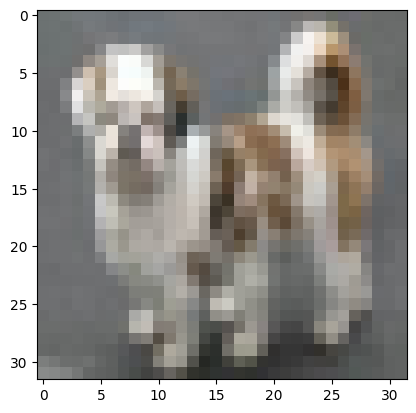

In [73]:
im = testset[1041][0]
im = im / 2 + 0.5
im = im.detach().cpu().numpy()
im = rescale_image(im).astype(int)
im = np.transpose(im, (1, 2, 0))
plt.imshow(im)

In [84]:
prompt = "What is depicted on the image, choose from this list: bird, a bunny, a car. If none fits, add a new category. Avoid plurals, conjugations, synonyms and answer with a single word."
pred_class = get_a_category(prompt, im)

In [85]:
pred_class

'dog'

In [ ]:
batches_results[1]['']

array([ 5,  0, 11,  4,  8,  1,  1, 13,  9,  6,  0,  8,  6,  1,  3,  4,  1,
       16,  0,  5,  1,  1, 17, 17, 18,  5, 19, 17, 20,  6,  3,  3, 20,  3,
        6,  6, 17,  7,  2,  2,  2, 22, 20, 23,  8,  5,  2,  1,  1,  4,  3,
        2, 17,  3,  1,  5, 20,  7,  6,  8,  9,  1,  6,  4, 24,  3,  1, 17,
        9,  6,  3,  6, 17,  7,  3,  8, 17, 17, 17,  6,  6,  6, 25,  2,  5,
        4,  4, 20, 20,  6, 26, 11,  6, 17,  6, 20,  7,  5,  1,  2,  7,  8,
        8, 17, 27,  5, 28,  7, 23, 17,  2,  8,  3,  8, 27,  1,  5,  5, 23,
        7, 23, 20,  8,  3,  3, 19,  2,  8, 23,  5,  7, 29, 20, 20,  1,  6,
        9, 30,  5,  8, 20,  1, 11,  6,  1, 23, 23,  6,  2,  7,  2,  2, 17,
        8, 19,  9,  1, 31,  1,  8, 11, 17,  7,  3, 32, 33,  3, 34,  3,  7,
        7,  9, 35, 20,  1,  9,  1,  9,  6,  3,  3,  3,  1, 17, 20,  1, 34,
        1, 17, 17,  1,  9,  6,  5,  4,  6, 23,  9,  7,  9, 11,  7,  2, 17,
        6, 11,  1,  4,  3,  7, 17, 20,  1, 11,  5,  7, 11,  4,  8,  3,  9,
       29,  9,  8,  7,  6

In [60]:
batches_results[1]['novel_classes_labels']

{'dog': 5,
 'boat': 11,
 'ship': 8,
 'fish': 13,
 'truck': 9,
 'frog': 6,
 'fox': 16,
 'airplane': 17,
 'hand': 18,
 'lizard': 19,
 'unidentifiable': 20,
 'horse': 7,
 'dogs': 22,
 'ostrich': 23,
 'mailbox': 24,
 'towtruck': 25,
 'seaplane': 26,
 'firetruck': 27,
 'bus': 28,
 'van': 29,
 'boot': 30,
 'unicorn': 31,
 'sailboat': 32,
 'clouds': 33,
 'moose': 34,
 'bear': 35,
 'mushrooms': 36,
 'parrot': 37,
 'tugboat': 38,
 'jet-ski': 39,
 'elk': 40,
 'keyboard': 41,
 'shark': 42,
 'llama': 43,
 'rooster': 44,
 'squirrel': 45,
 'caribou': 46,
 'stairs': 47,
 'rabbit': 48,
 'people': 49,
 'donut': 50,
 'flamingo': 51,
 'policecar': 52,
 'helicopter': 53,
 'monkey': 54,
 'cats': 55,
 'elephant': 56,
 'trailer': 57,
 'hat': 58,
 'generator': 59,
 'cassowary': 60,
 'bridge': 61,
 'sheep': 62,
 'kangaroo': 63}

#### save to drive

In [95]:
with open(f"{folder_path}/{DS}_{exp_type}_batches_results_new_prompt.pkl", "wb") as f:
    pickle.dump(batches_results, f)

In [ ]:
full_dict = {exp_type: np.array(batches_results)}
np.savez_compressed(f"{folder_path}/{DS}/{DS}_{exp_type}.npz", **full_dict)